In [1]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import metrics
import datetime
import matplotlib.pyplot as plt

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    # Since finta not on Google CoLab.
    from finta import TA
    print("Note: not using Google CoLab")
    COLAB = False
    


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)


def to_sequences(seq_size, obs, target_col):
    x = []
    y = []

    for i in range(len(obs) - seq_size):
        window = obs.iloc[i : (i + seq_size), target_col:].values
        after_window = obs.iloc[i + seq_size, target_col]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)

    x_train = np.array(x)
    y_train = np.array(y)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[3]))

    return x_train, y_train


def backtest(
    pred,
    y_test,
    periods_per_day=10,
    capital=1_000_000,
    mult=10_000,
    contracts=1,
    idx=None,
):
    total = 0
    pnls = []
    counter = 0

    # TODO: Fix to correct date indexing.
    # idx_n = []

    for x in range(len(pred)):
        if pred[x] > 0.0:
            total += y_test[x] * mult * contracts
        elif pred[x] < 0.0:
            total -= y_test[x] * mult * contracts
        if counter % periods_per_day == 0:
            pnls.append(total)
            # idx_n.append(idx[counter])
        counter += 1

    rets = pd.DataFrame(data=pnls, columns=["cum_pnl"])  # , index=idx_n)
    rets["portfolio"] = rets["cum_pnl"] + capital
    rets["pct_pnl"] = rets["portfolio"].pct_change()
    rets = rets.dropna()

    return rets


def perf_summ(data: pd.DataFrame, adj: int = 12, title="Metric") -> pd.DataFrame:
    summary = pd.DataFrame(
        data=data.mean() * adj, index=[title], columns=["Annualized Return"]
    )
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = summary["Annualized Return"] / (
        (data[data < 0]).std() * np.sqrt(adj)
    )

    summary["Skewness"] = data.skew()
    summary["Kurtosis"] = data.kurtosis()
    summary["VaR (0.05)"] = data.quantile(0.05)
    summary["CVaR (0.05)"] = data[data <= data.quantile(0.05)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()

    # TODO: Add absolute value/fix Calmar calculation.
    summary["Calmar Ratio"] = np.abs(((data.mean() * adj) / drawdowns.min()))

    return summary.T


periods_per_day = 10
fn = "/content/drive/MyDrive/Colab Notebooks/data/qm_data_tufv.csv"


Mounted at /content/drive
Note: using Google CoLab


In [2]:
target_col = 'target'

df = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=False)

df['Date'] = pd.to_datetime(df['Date'])

df = df.set_index("Date")
df = df.drop("Sum", axis=1)

col = df.pop(target_col)
df.insert(0, col.name, col)

df = df.reset_index(drop=False)

df["CosHour"] = np.cos(2 * np.pi * df["Date"].dt.hour / 24)
df["SinHour"] = np.sin(2 * np.pi * df["Date"].dt.hour / 24)
df["CosDay"] = np.cos(2 * np.pi * df["Date"].dt.day / 30)
df["SinDay"] = np.sin(2 * np.pi * df["Date"].dt.day / 30)
df["SinMonth"] = np.sin(2 * np.pi * df["Date"].dt.month / 12)
df["SinMoth"] = np.sin(2 * np.pi * df["Date"].dt.month / 12)
df["Year"] = df["Date"].dt.year

df = df.dropna()
df = df.drop("Date", axis=1)

df_train = df.iloc[:1000, :]
df_test = df.iloc[950:, :]

x_train = df_train.drop(target_col, axis=1)
y_train = df_train[target_col]

x_train = (x_train - x_train.expanding().mean()) / x_train.expanding().std()
y_train = y_train.iloc[1:]
x_train = x_train.dropna()

x_test = df_test.drop(target_col, axis=1)
y_test = df_test[target_col]

y_train = y_train.to_numpy().reshape((-1, 1))
y_test = y_test.to_numpy().reshape((-1, 1))

df = (df - df.expanding().mean()) / df.expanding().std()

x_train, y_train = to_sequences(50, df_train, 0)
x_test, y_test = to_sequences(50, df_test, 0)

In [3]:
model = build_model(
    x_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]


try:
    with tf.device("/device:GPU:0"):
        model.fit(
            x_train,
            y_train,
            epochs=200,
            batch_size=64,
            callbacks=callbacks,
        )
except:
    model.fit(
        x_train,
        y_train,
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 26)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 50, 26)      52          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 50, 26)      109594      ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

15/15 [==============================] - 16s 37ms/step - loss: 1970.0696
Epoch 2/200
15/15 [==============================] - ETA: 0s - loss: 1638.3469

15/15 [==============================] - 0s 27ms/step - loss: 1638.3469
Epoch 3/200
15/15 [==============================] - ETA: 0s - loss: 1460.7229

15/15 [==============================] - 0s 28ms/step - loss: 1460.7229
Epoch 4/200
15/15 [==============================] - ETA: 0s - loss: 1282.0438

15/15 [==============================] - 0s 27ms/step - loss: 1282.0438
Epoch 5/200
15/15 [==============================] - ETA: 0s - loss: 1129.0292

15/15 [==============================] - 0s 27ms/step - loss: 1129.0292
Epoch 6/200
15/15 [==============================] - ETA: 0s - loss: 990.9316 

15/15 [==============================] - 0s 27ms/step - loss: 990.9316
Epoch 7/200
13/15 [=========================>....] - ETA: 0s - loss: 895.4366

15/15 [==============================] - 0s 28ms/step - loss: 887.8089
Epoch 8/200
15/15 [==============================] - ETA: 0s - loss: 719.5143

15/15 [==============================] - 0s 32ms/step - loss: 719.5143
Epoch 9/200
15/15 [==============================] - ETA: 0s - loss: 571.7283

15/15 [==============================] - 0s 30ms/step - loss: 571.7283
Epoch 10/200
15/15 [==============================] - ETA: 0s - loss: 528.2239

15/15 [==============================] - 0s 30ms/step - loss: 528.2239
Epoch 11/200
15/15 [==============================] - ETA: 0s - loss: 416.1046

15/15 [==============================] - 0s 30ms/step - loss: 416.1046
Epoch 12/200
15/15 [==============================] - ETA: 0s - loss: 370.4984

15/15 [==============================] - 0s 31ms/step - loss: 370.4984
Epoch 13/200
15/15 [==============================] - ETA: 0s - loss: 305.2914

15/15 [==============================] - 0s 30ms/step - loss: 305.2914
Epoch 14/200
15/15 [==============================] - ETA: 0s - loss: 251.1662

15/15 [==============================] - 0s 29ms/step - loss: 251.1662
Epoch 15/200
15/15 [==============================] - ETA: 0s - loss: 221.5220

15/15 [==============================] - 0s 31ms/step - loss: 221.5220
Epoch 16/200
15/15 [==============================] - ETA: 0s - loss: 174.9822

15/15 [==============================] - 0s 32ms/step - loss: 174.9822
Epoch 17/200
15/15 [==============================] - ETA: 0s - loss: 158.0373

15/15 [==============================] - 0s 28ms/step - loss: 158.0373
Epoch 18/200
15/15 [==============================] - ETA: 0s - loss: 134.0214

15/15 [==============================] - 0s 28ms/step - loss: 134.0214
Epoch 19/200
13/15 [=========================>....] - ETA: 0s - loss: 115.1153

15/15 [==============================] - 0s 27ms/step - loss: 114.0709
Epoch 20/200
15/15 [==============================] - ETA: 0s - loss: 96.8071

15/15 [==============================] - 0s 28ms/step - loss: 96.8071
Epoch 21/200
15/15 [==============================] - ETA: 0s - loss: 82.8341

15/15 [==============================] - 0s 28ms/step - loss: 82.8341
Epoch 22/200
13/15 [=========================>....] - ETA: 0s - loss: 73.9812

15/15 [==============================] - 0s 27ms/step - loss: 72.1910
Epoch 23/200
13/15 [=========================>....] - ETA: 0s - loss: 58.2671

15/15 [==============================] - 0s 27ms/step - loss: 57.8074
Epoch 24/200
15/15 [==============================] - ETA: 0s - loss: 50.8237

15/15 [==============================] - 0s 28ms/step - loss: 50.8237
Epoch 25/200
15/15 [==============================] - ETA: 0s - loss: 44.4748

15/15 [==============================] - 0s 28ms/step - loss: 44.4748
Epoch 26/200
15/15 [==============================] - ETA: 0s - loss: 36.5673

15/15 [==============================] - 0s 28ms/step - loss: 36.5673
Epoch 27/200
15/15 [==============================] - ETA: 0s - loss: 36.2310

15/15 [==============================] - 0s 27ms/step - loss: 36.2310
Epoch 28/200
15/15 [==============================] - ETA: 0s - loss: 31.8905

15/15 [==============================] - 0s 27ms/step - loss: 31.8905
Epoch 29/200
15/15 [==============================] - ETA: 0s - loss: 26.8393

15/15 [==============================] - 0s 27ms/step - loss: 26.8393
Epoch 30/200
15/15 [==============================] - ETA: 0s - loss: 23.1125

15/15 [==============================] - 0s 27ms/step - loss: 23.1125
Epoch 31/200
14/15 [===========================>..] - ETA: 0s - loss: 20.3730

15/15 [==============================] - 0s 31ms/step - loss: 20.1042
Epoch 32/200
15/15 [==============================] - ETA: 0s - loss: 18.5840

15/15 [==============================] - 1s 48ms/step - loss: 18.5840
Epoch 33/200
13/15 [=========================>....] - ETA: 0s - loss: 16.4256

15/15 [==============================] - 0s 28ms/step - loss: 16.5203
Epoch 34/200
14/15 [===========================>..] - ETA: 0s - loss: 14.9386

15/15 [==============================] - 1s 55ms/step - loss: 14.7694
Epoch 35/200
15/15 [==============================] - ETA: 0s - loss: 14.3509

15/15 [==============================] - 0s 29ms/step - loss: 14.3509
Epoch 36/200
15/15 [==============================] - ETA: 0s - loss: 12.8195

15/15 [==============================] - 0s 28ms/step - loss: 12.8195
Epoch 37/200
15/15 [==============================] - ETA: 0s - loss: 10.8327

15/15 [==============================] - 0s 29ms/step - loss: 10.8327
Epoch 38/200
15/15 [==============================] - ETA: 0s - loss: 10.8529

15/15 [==============================] - 0s 28ms/step - loss: 10.8529
Epoch 39/200
15/15 [==============================] - ETA: 0s - loss: 10.9409

15/15 [==============================] - 0s 32ms/step - loss: 10.9409
Epoch 40/200
15/15 [==============================] - ETA: 0s - loss: 10.4183

15/15 [==============================] - 0s 29ms/step - loss: 10.4183
Epoch 41/200
15/15 [==============================] - ETA: 0s - loss: 9.9539 

15/15 [==============================] - 0s 31ms/step - loss: 9.9539
Epoch 42/200
15/15 [==============================] - ETA: 0s - loss: 10.0648

15/15 [==============================] - 0s 31ms/step - loss: 10.0648
Epoch 43/200
15/15 [==============================] - ETA: 0s - loss: 9.4424

15/15 [==============================] - 0s 29ms/step - loss: 9.4424
Epoch 44/200
15/15 [==============================] - ETA: 0s - loss: 8.5730

15/15 [==============================] - 0s 31ms/step - loss: 8.5730
Epoch 45/200
15/15 [==============================] - ETA: 0s - loss: 8.7495

15/15 [==============================] - 0s 28ms/step - loss: 8.7495
Epoch 46/200
15/15 [==============================] - ETA: 0s - loss: 8.9355

15/15 [==============================] - 0s 31ms/step - loss: 8.9355
Epoch 47/200
15/15 [==============================] - ETA: 0s - loss: 9.1481

15/15 [==============================] - 0s 31ms/step - loss: 9.1481
Epoch 48/200
15/15 [==============================] - ETA: 0s - loss: 9.4658

15/15 [==============================] - 0s 28ms/step - loss: 9.4658
Epoch 49/200
15/15 [==============================] - ETA: 0s - loss: 9.3092

15/15 [==============================] - 0s 28ms/step - loss: 9.3092
Epoch 50/200
15/15 [==============================] - ETA: 0s - loss: 7.9994

15/15 [==============================] - 0s 29ms/step - loss: 7.9994
Epoch 51/200
15/15 [==============================] - ETA: 0s - loss: 9.0913

15/15 [==============================] - 0s 28ms/step - loss: 9.0913
Epoch 52/200
15/15 [==============================] - ETA: 0s - loss: 8.6754

15/15 [==============================] - 0s 27ms/step - loss: 8.6754
Epoch 53/200
15/15 [==============================] - ETA: 0s - loss: 9.1815

15/15 [==============================] - 0s 27ms/step - loss: 9.1815
Epoch 54/200
15/15 [==============================] - ETA: 0s - loss: 8.5194

15/15 [==============================] - 0s 28ms/step - loss: 8.5194
Epoch 55/200
15/15 [==============================] - ETA: 0s - loss: 7.7270

15/15 [==============================] - 0s 29ms/step - loss: 7.7270
Epoch 56/200
15/15 [==============================] - ETA: 0s - loss: 8.1962

15/15 [==============================] - 0s 29ms/step - loss: 8.1962
Epoch 57/200
15/15 [==============================] - ETA: 0s - loss: 8.0686

15/15 [==============================] - 0s 28ms/step - loss: 8.0686
Epoch 58/200
15/15 [==============================] - ETA: 0s - loss: 7.9666

15/15 [==============================] - 0s 29ms/step - loss: 7.9666
Epoch 59/200
15/15 [==============================] - ETA: 0s - loss: 7.8076

15/15 [==============================] - 0s 28ms/step - loss: 7.8076
Epoch 60/200
15/15 [==============================] - ETA: 0s - loss: 8.1934

15/15 [==============================] - 0s 29ms/step - loss: 8.1934
Epoch 61/200
15/15 [==============================] - ETA: 0s - loss: 7.4635

15/15 [==============================] - 0s 28ms/step - loss: 7.4635
Epoch 62/200
15/15 [==============================] - ETA: 0s - loss: 7.7221

15/15 [==============================] - 0s 28ms/step - loss: 7.7221
Epoch 63/200
15/15 [==============================] - ETA: 0s - loss: 8.0139

15/15 [==============================] - 0s 28ms/step - loss: 8.0139
Epoch 64/200
15/15 [==============================] - ETA: 0s - loss: 7.5883

15/15 [==============================] - 0s 27ms/step - loss: 7.5883
Epoch 65/200
15/15 [==============================] - ETA: 0s - loss: 8.0875

15/15 [==============================] - 0s 29ms/step - loss: 8.0875
Epoch 66/200
15/15 [==============================] - ETA: 0s - loss: 7.5668

15/15 [==============================] - 0s 29ms/step - loss: 7.5668
Epoch 67/200
15/15 [==============================] - ETA: 0s - loss: 7.2808

15/15 [==============================] - 0s 30ms/step - loss: 7.2808
Epoch 68/200
15/15 [==============================] - ETA: 0s - loss: 8.0771

15/15 [==============================] - 0s 28ms/step - loss: 8.0771
Epoch 69/200
15/15 [==============================] - ETA: 0s - loss: 7.7099

15/15 [==============================] - 0s 27ms/step - loss: 7.7099
Epoch 70/200
15/15 [==============================] - ETA: 0s - loss: 7.2027

15/15 [==============================] - 0s 29ms/step - loss: 7.2027
Epoch 71/200
15/15 [==============================] - ETA: 0s - loss: 7.9030

15/15 [==============================] - 0s 32ms/step - loss: 7.9030
Epoch 72/200
15/15 [==============================] - ETA: 0s - loss: 7.6413

15/15 [==============================] - 0s 33ms/step - loss: 7.6413
Epoch 73/200
15/15 [==============================] - ETA: 0s - loss: 6.8070

15/15 [==============================] - 0s 31ms/step - loss: 6.8070
Epoch 74/200
15/15 [==============================] - ETA: 0s - loss: 7.6097

15/15 [==============================] - 0s 31ms/step - loss: 7.6097
Epoch 75/200
15/15 [==============================] - ETA: 0s - loss: 6.8744

15/15 [==============================] - 0s 31ms/step - loss: 6.8744
Epoch 76/200
15/15 [==============================] - ETA: 0s - loss: 7.2111

15/15 [==============================] - 0s 31ms/step - loss: 7.2111
Epoch 77/200
15/15 [==============================] - ETA: 0s - loss: 7.0215

15/15 [==============================] - 0s 32ms/step - loss: 7.0215
Epoch 78/200
15/15 [==============================] - ETA: 0s - loss: 6.9764

15/15 [==============================] - 0s 31ms/step - loss: 6.9764
Epoch 79/200
15/15 [==============================] - ETA: 0s - loss: 6.7738

15/15 [==============================] - 0s 32ms/step - loss: 6.7738
Epoch 80/200
15/15 [==============================] - ETA: 0s - loss: 7.0611

15/15 [==============================] - 0s 30ms/step - loss: 7.0611
Epoch 81/200
15/15 [==============================] - ETA: 0s - loss: 7.2743

15/15 [==============================] - 0s 28ms/step - loss: 7.2743
Epoch 82/200
15/15 [==============================] - ETA: 0s - loss: 6.9678

15/15 [==============================] - 0s 28ms/step - loss: 6.9678
Epoch 83/200
15/15 [==============================] - ETA: 0s - loss: 6.8097

15/15 [==============================] - 0s 29ms/step - loss: 6.8097
Epoch 84/200
15/15 [==============================] - ETA: 0s - loss: 6.9188

15/15 [==============================] - 0s 29ms/step - loss: 6.9188
Epoch 85/200
15/15 [==============================] - ETA: 0s - loss: 6.8064

15/15 [==============================] - 0s 28ms/step - loss: 6.8064
Epoch 86/200
15/15 [==============================] - ETA: 0s - loss: 6.5400

15/15 [==============================] - 0s 29ms/step - loss: 6.5400
Epoch 87/200
15/15 [==============================] - ETA: 0s - loss: 7.2201

15/15 [==============================] - 0s 29ms/step - loss: 7.2201
Epoch 88/200
15/15 [==============================] - ETA: 0s - loss: 7.0866

15/15 [==============================] - 0s 28ms/step - loss: 7.0866
Epoch 89/200
15/15 [==============================] - ETA: 0s - loss: 6.5671

15/15 [==============================] - 0s 27ms/step - loss: 6.5671
Epoch 90/200
15/15 [==============================] - ETA: 0s - loss: 6.4770

15/15 [==============================] - 0s 29ms/step - loss: 6.4770
Epoch 91/200
15/15 [==============================] - ETA: 0s - loss: 7.3852

15/15 [==============================] - 0s 28ms/step - loss: 7.3852
Epoch 92/200
15/15 [==============================] - ETA: 0s - loss: 7.0579

15/15 [==============================] - 0s 28ms/step - loss: 7.0579
Epoch 93/200
15/15 [==============================] - ETA: 0s - loss: 6.0465

15/15 [==============================] - 0s 28ms/step - loss: 6.0465
Epoch 94/200
15/15 [==============================] - ETA: 0s - loss: 6.4640

15/15 [==============================] - 0s 27ms/step - loss: 6.4640
Epoch 95/200
15/15 [==============================] - ETA: 0s - loss: 6.5874

15/15 [==============================] - 0s 29ms/step - loss: 6.5874
Epoch 96/200
15/15 [==============================] - ETA: 0s - loss: 6.6645

15/15 [==============================] - 0s 28ms/step - loss: 6.6645
Epoch 97/200
15/15 [==============================] - ETA: 0s - loss: 7.5902

15/15 [==============================] - 0s 28ms/step - loss: 7.5902
Epoch 98/200
15/15 [==============================] - ETA: 0s - loss: 6.1335

15/15 [==============================] - 0s 28ms/step - loss: 6.1335
Epoch 99/200
15/15 [==============================] - ETA: 0s - loss: 6.3633

15/15 [==============================] - 0s 28ms/step - loss: 6.3633
Epoch 100/200
15/15 [==============================] - ETA: 0s - loss: 6.3367

15/15 [==============================] - 0s 28ms/step - loss: 6.3367
Epoch 101/200
15/15 [==============================] - ETA: 0s - loss: 6.0493

15/15 [==============================] - 0s 29ms/step - loss: 6.0493
Epoch 102/200
15/15 [==============================] - ETA: 0s - loss: 6.5896

15/15 [==============================] - 0s 29ms/step - loss: 6.5896
Epoch 103/200
15/15 [==============================] - ETA: 0s - loss: 6.0544

15/15 [==============================] - 0s 32ms/step - loss: 6.0544
Epoch 104/200
15/15 [==============================] - ETA: 0s - loss: 6.5007

15/15 [==============================] - 0s 32ms/step - loss: 6.5007
Epoch 105/200
15/15 [==============================] - ETA: 0s - loss: 6.4765

15/15 [==============================] - 0s 28ms/step - loss: 6.4765
Epoch 106/200
15/15 [==============================] - ETA: 0s - loss: 5.9045

15/15 [==============================] - 0s 29ms/step - loss: 5.9045
Epoch 107/200
15/15 [==============================] - ETA: 0s - loss: 6.1485

15/15 [==============================] - 1s 55ms/step - loss: 6.1485
Epoch 108/200
15/15 [==============================] - ETA: 0s - loss: 6.2890

15/15 [==============================] - 1s 61ms/step - loss: 6.2890
Epoch 109/200
15/15 [==============================] - ETA: 0s - loss: 6.6366

15/15 [==============================] - 0s 29ms/step - loss: 6.6366
Epoch 110/200
15/15 [==============================] - ETA: 0s - loss: 6.6935

15/15 [==============================] - 0s 31ms/step - loss: 6.6935
Epoch 111/200
15/15 [==============================] - ETA: 0s - loss: 6.1168

15/15 [==============================] - 0s 28ms/step - loss: 6.1168
Epoch 112/200
15/15 [==============================] - ETA: 0s - loss: 6.2091

15/15 [==============================] - 0s 28ms/step - loss: 6.2091
Epoch 113/200
15/15 [==============================] - ETA: 0s - loss: 5.8382

15/15 [==============================] - 0s 28ms/step - loss: 5.8382
Epoch 114/200
15/15 [==============================] - ETA: 0s - loss: 6.3698

15/15 [==============================] - 0s 29ms/step - loss: 6.3698
Epoch 115/200
15/15 [==============================] - ETA: 0s - loss: 6.5153

15/15 [==============================] - 0s 28ms/step - loss: 6.5153
Epoch 116/200
15/15 [==============================] - ETA: 0s - loss: 5.9813

15/15 [==============================] - 0s 28ms/step - loss: 5.9813
Epoch 117/200
15/15 [==============================] - ETA: 0s - loss: 5.8053

15/15 [==============================] - 0s 28ms/step - loss: 5.8053
Epoch 118/200
15/15 [==============================] - ETA: 0s - loss: 5.9764

15/15 [==============================] - 0s 29ms/step - loss: 5.9764
Epoch 119/200
15/15 [==============================] - ETA: 0s - loss: 6.1143

15/15 [==============================] - 0s 28ms/step - loss: 6.1143
Epoch 120/200
15/15 [==============================] - ETA: 0s - loss: 5.9534

15/15 [==============================] - 0s 28ms/step - loss: 5.9534
Epoch 121/200
15/15 [==============================] - ETA: 0s - loss: 6.2297

15/15 [==============================] - 0s 28ms/step - loss: 6.2297
Epoch 122/200
15/15 [==============================] - ETA: 0s - loss: 5.5078

15/15 [==============================] - 0s 28ms/step - loss: 5.5078
Epoch 123/200
15/15 [==============================] - ETA: 0s - loss: 6.3143

15/15 [==============================] - 0s 28ms/step - loss: 6.3143
Epoch 124/200
15/15 [==============================] - ETA: 0s - loss: 5.7275

15/15 [==============================] - 0s 30ms/step - loss: 5.7275
Epoch 125/200
15/15 [==============================] - ETA: 0s - loss: 6.0851

15/15 [==============================] - 0s 29ms/step - loss: 6.0851
Epoch 126/200
15/15 [==============================] - ETA: 0s - loss: 6.0686

15/15 [==============================] - 0s 28ms/step - loss: 6.0686
Epoch 127/200
15/15 [==============================] - ETA: 0s - loss: 5.7587

15/15 [==============================] - 0s 28ms/step - loss: 5.7587
Epoch 128/200
15/15 [==============================] - ETA: 0s - loss: 5.6569

15/15 [==============================] - 0s 29ms/step - loss: 5.6569
Epoch 129/200
15/15 [==============================] - ETA: 0s - loss: 5.9681

15/15 [==============================] - 0s 28ms/step - loss: 5.9681
Epoch 130/200
15/15 [==============================] - ETA: 0s - loss: 6.1258

15/15 [==============================] - 0s 29ms/step - loss: 6.1258
Epoch 131/200
15/15 [==============================] - ETA: 0s - loss: 5.5357

15/15 [==============================] - 0s 28ms/step - loss: 5.5357
Epoch 132/200
15/15 [==============================] - ETA: 0s - loss: 5.9785

15/15 [==============================] - 0s 27ms/step - loss: 5.9785
Epoch 133/200
15/15 [==============================] - ETA: 0s - loss: 5.4800

15/15 [==============================] - 0s 29ms/step - loss: 5.4800
Epoch 134/200
15/15 [==============================] - ETA: 0s - loss: 5.9026

15/15 [==============================] - 0s 30ms/step - loss: 5.9026
Epoch 135/200
15/15 [==============================] - ETA: 0s - loss: 5.6966

15/15 [==============================] - 0s 29ms/step - loss: 5.6966
Epoch 136/200
15/15 [==============================] - ETA: 0s - loss: 5.3102

15/15 [==============================] - 0s 30ms/step - loss: 5.3102
Epoch 137/200
15/15 [==============================] - ETA: 0s - loss: 5.5484

15/15 [==============================] - 0s 31ms/step - loss: 5.5484
Epoch 138/200
15/15 [==============================] - ETA: 0s - loss: 6.2785

15/15 [==============================] - 0s 33ms/step - loss: 6.2785
Epoch 139/200
15/15 [==============================] - ETA: 0s - loss: 5.8456

15/15 [==============================] - 0s 30ms/step - loss: 5.8456
Epoch 140/200
15/15 [==============================] - ETA: 0s - loss: 5.7825

15/15 [==============================] - 0s 32ms/step - loss: 5.7825
Epoch 141/200
15/15 [==============================] - ETA: 0s - loss: 5.8944

15/15 [==============================] - 0s 29ms/step - loss: 5.8944
Epoch 142/200
15/15 [==============================] - ETA: 0s - loss: 5.3362

15/15 [==============================] - 0s 31ms/step - loss: 5.3362
Epoch 143/200
15/15 [==============================] - ETA: 0s - loss: 5.2858

15/15 [==============================] - 0s 29ms/step - loss: 5.2858
Epoch 144/200
15/15 [==============================] - ETA: 0s - loss: 5.3829

15/15 [==============================] - 0s 29ms/step - loss: 5.3829
Epoch 145/200
15/15 [==============================] - ETA: 0s - loss: 5.4687

15/15 [==============================] - 0s 28ms/step - loss: 5.4687
Epoch 146/200
15/15 [==============================] - ETA: 0s - loss: 5.3334

15/15 [==============================] - 0s 28ms/step - loss: 5.3334
Epoch 147/200
15/15 [==============================] - ETA: 0s - loss: 5.9712

15/15 [==============================] - 0s 30ms/step - loss: 5.9712
Epoch 148/200
15/15 [==============================] - ETA: 0s - loss: 5.7165

15/15 [==============================] - 0s 28ms/step - loss: 5.7165
Epoch 149/200
15/15 [==============================] - ETA: 0s - loss: 5.7624

15/15 [==============================] - 0s 29ms/step - loss: 5.7624
Epoch 150/200
15/15 [==============================] - ETA: 0s - loss: 5.2227

15/15 [==============================] - 0s 28ms/step - loss: 5.2227
Epoch 151/200
15/15 [==============================] - ETA: 0s - loss: 5.2494

15/15 [==============================] - 0s 28ms/step - loss: 5.2494
Epoch 152/200
15/15 [==============================] - ETA: 0s - loss: 6.0767

15/15 [==============================] - 0s 29ms/step - loss: 6.0767
Epoch 153/200
15/15 [==============================] - ETA: 0s - loss: 5.5059

15/15 [==============================] - 0s 28ms/step - loss: 5.5059
Epoch 154/200
15/15 [==============================] - ETA: 0s - loss: 4.8222

15/15 [==============================] - 0s 29ms/step - loss: 4.8222
Epoch 155/200
15/15 [==============================] - ETA: 0s - loss: 5.2597

15/15 [==============================] - 0s 28ms/step - loss: 5.2597
Epoch 156/200
15/15 [==============================] - ETA: 0s - loss: 5.2655

15/15 [==============================] - 0s 29ms/step - loss: 5.2655
Epoch 157/200
15/15 [==============================] - ETA: 0s - loss: 5.3695

15/15 [==============================] - 0s 28ms/step - loss: 5.3695
Epoch 158/200
15/15 [==============================] - ETA: 0s - loss: 5.2452

15/15 [==============================] - 0s 30ms/step - loss: 5.2452
Epoch 159/200
15/15 [==============================] - ETA: 0s - loss: 5.2269

15/15 [==============================] - 0s 29ms/step - loss: 5.2269
Epoch 160/200
15/15 [==============================] - ETA: 0s - loss: 4.4618

15/15 [==============================] - 0s 28ms/step - loss: 4.4618
Epoch 161/200
15/15 [==============================] - ETA: 0s - loss: 4.9384

15/15 [==============================] - 0s 29ms/step - loss: 4.9384
Epoch 162/200
15/15 [==============================] - ETA: 0s - loss: 5.2741

15/15 [==============================] - 0s 28ms/step - loss: 5.2741
Epoch 163/200
15/15 [==============================] - ETA: 0s - loss: 5.2715

15/15 [==============================] - 0s 29ms/step - loss: 5.2715
Epoch 164/200
15/15 [==============================] - ETA: 0s - loss: 5.8991

15/15 [==============================] - 0s 29ms/step - loss: 5.8991
Epoch 165/200
15/15 [==============================] - ETA: 0s - loss: 4.9482

15/15 [==============================] - 0s 28ms/step - loss: 4.9482
Epoch 166/200
15/15 [==============================] - ETA: 0s - loss: 5.1630

15/15 [==============================] - 0s 31ms/step - loss: 5.1630
Epoch 167/200
15/15 [==============================] - ETA: 0s - loss: 5.1532

15/15 [==============================] - 0s 31ms/step - loss: 5.1532
Epoch 168/200
15/15 [==============================] - ETA: 0s - loss: 5.1089

15/15 [==============================] - 0s 30ms/step - loss: 5.1089
Epoch 169/200
15/15 [==============================] - ETA: 0s - loss: 5.2812

15/15 [==============================] - 0s 29ms/step - loss: 5.2812
Epoch 170/200
15/15 [==============================] - ETA: 0s - loss: 5.4376

15/15 [==============================] - 0s 31ms/step - loss: 5.4376
Epoch 171/200
15/15 [==============================] - ETA: 0s - loss: 5.2336

15/15 [==============================] - 0s 30ms/step - loss: 5.2336
Epoch 172/200
15/15 [==============================] - ETA: 0s - loss: 5.1000

15/15 [==============================] - 0s 31ms/step - loss: 5.1000
Epoch 173/200
15/15 [==============================] - ETA: 0s - loss: 4.7687

15/15 [==============================] - 0s 31ms/step - loss: 4.7687
Epoch 174/200
15/15 [==============================] - ETA: 0s - loss: 4.9950

15/15 [==============================] - 0s 30ms/step - loss: 4.9950
Epoch 175/200
15/15 [==============================] - ETA: 0s - loss: 5.1967

15/15 [==============================] - 0s 30ms/step - loss: 5.1967
Epoch 176/200
15/15 [==============================] - ETA: 0s - loss: 5.3224

15/15 [==============================] - 0s 30ms/step - loss: 5.3224
Epoch 177/200
15/15 [==============================] - ETA: 0s - loss: 5.1478

15/15 [==============================] - 0s 29ms/step - loss: 5.1478
Epoch 178/200
15/15 [==============================] - ETA: 0s - loss: 4.5911

15/15 [==============================] - 0s 28ms/step - loss: 4.5911
Epoch 179/200
15/15 [==============================] - ETA: 0s - loss: 4.8281

15/15 [==============================] - 0s 29ms/step - loss: 4.8281
Epoch 180/200
15/15 [==============================] - ETA: 0s - loss: 5.3257

15/15 [==============================] - 0s 30ms/step - loss: 5.3257
Epoch 181/200
15/15 [==============================] - ETA: 0s - loss: 5.0209

15/15 [==============================] - 0s 28ms/step - loss: 5.0209
Epoch 182/200
14/15 [===========================>..] - ETA: 0s - loss: 4.6159

15/15 [==============================] - 1s 39ms/step - loss: 4.6476
Epoch 183/200
14/15 [===========================>..] - ETA: 0s - loss: 4.6267

15/15 [==============================] - 1s 41ms/step - loss: 4.7069
Epoch 184/200
15/15 [==============================] - ETA: 0s - loss: 5.2117

15/15 [==============================] - 1s 36ms/step - loss: 5.2117
Epoch 185/200
14/15 [===========================>..] - ETA: 0s - loss: 5.1361

15/15 [==============================] - 1s 41ms/step - loss: 5.0904
Epoch 186/200
15/15 [==============================] - ETA: 0s - loss: 4.8658

15/15 [==============================] - 0s 28ms/step - loss: 4.8658
Epoch 187/200
15/15 [==============================] - ETA: 0s - loss: 5.0397

15/15 [==============================] - 0s 28ms/step - loss: 5.0397
Epoch 188/200
15/15 [==============================] - ETA: 0s - loss: 4.8226

15/15 [==============================] - 0s 28ms/step - loss: 4.8226
Epoch 189/200
15/15 [==============================] - ETA: 0s - loss: 5.1071

15/15 [==============================] - 0s 28ms/step - loss: 5.1071
Epoch 190/200
15/15 [==============================] - ETA: 0s - loss: 4.8828

15/15 [==============================] - 0s 28ms/step - loss: 4.8828
Epoch 191/200
15/15 [==============================] - ETA: 0s - loss: 4.6560

15/15 [==============================] - 0s 31ms/step - loss: 4.6560
Epoch 192/200
15/15 [==============================] - ETA: 0s - loss: 4.9960

15/15 [==============================] - 0s 29ms/step - loss: 4.9960
Epoch 193/200
15/15 [==============================] - ETA: 0s - loss: 4.6522

15/15 [==============================] - 0s 29ms/step - loss: 4.6522
Epoch 194/200
15/15 [==============================] - ETA: 0s - loss: 5.0057

15/15 [==============================] - 0s 29ms/step - loss: 5.0057
Epoch 195/200
15/15 [==============================] - ETA: 0s - loss: 4.2775

15/15 [==============================] - 0s 29ms/step - loss: 4.2775
Epoch 196/200
15/15 [==============================] - ETA: 0s - loss: 4.4050

15/15 [==============================] - 0s 29ms/step - loss: 4.4050
Epoch 197/200
15/15 [==============================] - ETA: 0s - loss: 4.5124

15/15 [==============================] - 0s 30ms/step - loss: 4.5124
Epoch 198/200
15/15 [==============================] - ETA: 0s - loss: 4.7676

15/15 [==============================] - 0s 32ms/step - loss: 4.7676
Epoch 199/200
15/15 [==============================] - ETA: 0s - loss: 4.8494

15/15 [==============================] - 0s 30ms/step - loss: 4.8494
Epoch 200/200
15/15 [==============================] - ETA: 0s - loss: 4.4454

15/15 [==============================] - 0s 30ms/step - loss: 4.4454


In [4]:
from tqdm import tqdm 

def run_stepped_inc(model, x_test, y_test, step_size, stop_at=None, **model_kwargs):
    stop_at = len(x_test) if stop_at is None else stop_at
    x_test = x_test[:stop_at]
    y_test = y_test[:stop_at]
    preds = []

    for i in tqdm(range(0, stop_at, step_size)):
        # Check if we reached end of data.
        if i + step_size >= stop_at:
            x_step = x_test[i:]
            y_step = y_test[i:]
        else:
            x_step = x_test[i : i + step_size]
            y_step = y_test[i : i + step_size]

        # Predict the data.
        pred = model.predict(x_step)

        # Append to output list.
        try:
            preds += pred[:, 0].tolist()
        except:
            preds += pred.tolist()

        # Re-fit the model.
        try:
            with tf.device("/device:GPU:0"):
                model.fit(x_step, y_step, **model_kwargs)
        except:
            model.fit(x_step, y_step)
    # At the end, return x/y
    preds_np = np.array(preds)
    return preds_np, y_test[:stop_at]



def run_stepped_retrain(model, x_all, y_all, step_size, start_at=0.8, **model_kwargs):
    start_at = int(len(x_all) * start_at) if start_at % 1 != 0 else start_at

    x_train = x_all[:start_at]
    y_train = y_all[:start_at]

    x_test = x_all[start_at:]
    y_test = y_all[start_at:]
    preds = []

    model.fit(x_train, y_train)
    
    stop = len(x_test)

    for i in tqdm(range(0, stop, step_size)):
        
        if i + step_size >= stop:
            x_step = x_test[i:]
            y_step = y_test[i:]
        else:
            x_step = x_test[i:i + step_size]
            y_step = y_test[i:i + step_size]
        
        x_step_train = x_test[:i + step_size]
        y_step_train = y_test[:i + step_size]
        
        pred = model.predict(x_step)
        try:
            preds += pred[:, 0].tolist()
        except:
            preds += pred.tolist()
        
        # Re-Train entire model.
        try:
            with tf.device("/device:GPU:0"):
                model.fit(x_step_train, y_step_train, **model_kwargs)
        except:
            model.fit(x_step_train, y_step_train)

    # At the end, return x/y
    preds_np = np.array(preds)
    return preds_np, y_test

x, y = run_stepped_inc(
    model, x_test, y_test, step_size=25, epochs=5, batch_size=64, callbacks=callbacks
)

  0%|          | 0/277 [00:00<?, ?it/s]

1/1 [==============================] - 0s 460ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4959

1/1 [==============================] - 0s 74ms/step - loss: 3.4959
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.9137

1/1 [==============================] - 0s 34ms/step - loss: 2.9137
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2638

1/1 [==============================] - 0s 33ms/step - loss: 4.2638
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6383

1/1 [==============================] - 0s 27ms/step - loss: 4.6383
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3111

1/1 [==============================] - 0s 26ms/step - loss: 4.3111


  0%|          | 1/277 [00:00<03:39,  1.26it/s]

1/1 [==============================] - 0s 22ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6954

1/1 [==============================] - 0s 33ms/step - loss: 3.6954
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.6289

1/1 [==============================] - 0s 29ms/step - loss: 5.6289
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.7777

1/1 [==============================] - 0s 30ms/step - loss: 4.7777
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5489

1/1 [==============================] - 0s 29ms/step - loss: 4.5489
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3131

1/1 [==============================] - 0s 33ms/step - loss: 4.3131


  1%|          | 2/277 [00:01<02:19,  1.97it/s]

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4314

1/1 [==============================] - 0s 33ms/step - loss: 3.4314
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2822

1/1 [==============================] - 0s 30ms/step - loss: 3.2822
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3450

1/1 [==============================] - 0s 33ms/step - loss: 3.3450
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.1024

1/1 [==============================] - 0s 28ms/step - loss: 5.1024
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6327

1/1 [==============================] - 0s 30ms/step - loss: 4.6327


  1%|          | 3/277 [00:01<02:10,  2.11it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1462

1/1 [==============================] - 0s 34ms/step - loss: 5.1462
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.2486

1/1 [==============================] - 0s 35ms/step - loss: 6.2486
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.4538

1/1 [==============================] - 0s 29ms/step - loss: 3.4538
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.0414

1/1 [==============================] - 0s 29ms/step - loss: 3.0414
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0001

1/1 [==============================] - 0s 37ms/step - loss: 5.0001


  1%|▏         | 4/277 [00:01<01:52,  2.43it/s]

1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2743

1/1 [==============================] - 0s 32ms/step - loss: 3.2743
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.1405

1/1 [==============================] - 0s 28ms/step - loss: 3.1405
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.1217

1/1 [==============================] - 0s 29ms/step - loss: 4.1217
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8166

1/1 [==============================] - 0s 29ms/step - loss: 2.8166
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0315

1/1 [==============================] - 0s 31ms/step - loss: 3.0315


  2%|▏         | 5/277 [00:02<01:54,  2.37it/s]

1/1 [==============================] - 0s 31ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1883

1/1 [==============================] - 0s 29ms/step - loss: 4.1883
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6589

1/1 [==============================] - 0s 35ms/step - loss: 4.6589
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.7899

1/1 [==============================] - 0s 31ms/step - loss: 5.7899
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6547

1/1 [==============================] - 0s 32ms/step - loss: 3.6547
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.4441

1/1 [==============================] - 0s 36ms/step - loss: 4.4441


  2%|▏         | 6/277 [00:02<01:44,  2.59it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6016

1/1 [==============================] - 0s 32ms/step - loss: 4.6016
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7773

1/1 [==============================] - 0s 33ms/step - loss: 3.7773
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.1179

1/1 [==============================] - 0s 28ms/step - loss: 6.1179
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.1861

1/1 [==============================] - 0s 28ms/step - loss: 4.1861
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.5455

1/1 [==============================] - 0s 34ms/step - loss: 6.5455


  3%|▎         | 7/277 [00:02<01:38,  2.74it/s]

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.0353

1/1 [==============================] - 0s 33ms/step - loss: 3.0353
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9218

1/1 [==============================] - 0s 39ms/step - loss: 3.9218
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2499

1/1 [==============================] - 0s 28ms/step - loss: 4.2499
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6638

1/1 [==============================] - 0s 32ms/step - loss: 3.6638
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6475

1/1 [==============================] - 0s 35ms/step - loss: 4.6475


  3%|▎         | 8/277 [00:03<01:35,  2.82it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.4535

1/1 [==============================] - 0s 30ms/step - loss: 6.4535
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9204

1/1 [==============================] - 0s 35ms/step - loss: 3.9204
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.3549

1/1 [==============================] - 0s 35ms/step - loss: 4.3549
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.1412

1/1 [==============================] - 0s 36ms/step - loss: 4.1412
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.1143

1/1 [==============================] - 0s 29ms/step - loss: 3.1143


  3%|▎         | 9/277 [00:03<01:42,  2.63it/s]

1/1 [==============================] - 0s 31ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.9789

1/1 [==============================] - 0s 34ms/step - loss: 5.9789
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3342

1/1 [==============================] - 0s 44ms/step - loss: 3.3342
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0332

1/1 [==============================] - 0s 43ms/step - loss: 3.0332
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8349

1/1 [==============================] - 0s 34ms/step - loss: 4.8349
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.2207

1/1 [==============================] - 0s 29ms/step - loss: 4.2207


  4%|▎         | 10/277 [00:04<01:46,  2.51it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8247

1/1 [==============================] - 0s 31ms/step - loss: 4.8247
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2082

1/1 [==============================] - 0s 34ms/step - loss: 3.2082
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.7622

1/1 [==============================] - 0s 32ms/step - loss: 5.7622
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8354

1/1 [==============================] - 0s 28ms/step - loss: 4.8354
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8133

1/1 [==============================] - 0s 28ms/step - loss: 2.8133


  4%|▍         | 11/277 [00:04<01:38,  2.69it/s]

1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7950

1/1 [==============================] - 0s 32ms/step - loss: 4.7950
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5762

1/1 [==============================] - 0s 36ms/step - loss: 4.5762
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 7.5709

1/1 [==============================] - 0s 29ms/step - loss: 7.5709
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5587

1/1 [==============================] - 0s 44ms/step - loss: 4.5587
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8635

1/1 [==============================] - 0s 52ms/step - loss: 4.8635


  4%|▍         | 12/277 [00:04<01:43,  2.56it/s]

1/1 [==============================] - 0s 42ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4455

1/1 [==============================] - 0s 38ms/step - loss: 5.4455
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.9152

1/1 [==============================] - 0s 41ms/step - loss: 5.9152
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.3313

1/1 [==============================] - 0s 54ms/step - loss: 5.3313
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5771

1/1 [==============================] - 0s 40ms/step - loss: 4.5771
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.5197

1/1 [==============================] - 0s 44ms/step - loss: 5.5197


  5%|▍         | 13/277 [00:05<01:46,  2.48it/s]

1/1 [==============================] - 0s 32ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.8090

1/1 [==============================] - 0s 42ms/step - loss: 3.8090
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.5067

1/1 [==============================] - 0s 39ms/step - loss: 6.5067
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6885

1/1 [==============================] - 0s 37ms/step - loss: 4.6885
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5176

1/1 [==============================] - 0s 37ms/step - loss: 3.5176
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3239

1/1 [==============================] - 0s 36ms/step - loss: 4.3239


  5%|▌         | 14/277 [00:05<01:52,  2.34it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6395

1/1 [==============================] - 0s 53ms/step - loss: 3.6395
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4242

1/1 [==============================] - 0s 43ms/step - loss: 4.4242
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2263

1/1 [==============================] - 0s 39ms/step - loss: 4.2263
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6727

1/1 [==============================] - 0s 39ms/step - loss: 3.6727
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3377

1/1 [==============================] - 0s 41ms/step - loss: 3.3377


  5%|▌         | 15/277 [00:06<01:56,  2.24it/s]

1/1 [==============================] - 0s 32ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.7013

1/1 [==============================] - 0s 42ms/step - loss: 5.7013
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.0587

1/1 [==============================] - 0s 39ms/step - loss: 6.0587
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7996

1/1 [==============================] - 0s 37ms/step - loss: 3.7996
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 8.3882

1/1 [==============================] - 0s 42ms/step - loss: 8.3882
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8673

1/1 [==============================] - 0s 37ms/step - loss: 3.8673


  6%|▌         | 16/277 [00:06<01:59,  2.19it/s]

1/1 [==============================] - 0s 50ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.8255

1/1 [==============================] - 0s 47ms/step - loss: 6.8255
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2343

1/1 [==============================] - 0s 45ms/step - loss: 3.2343
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 7.1081

1/1 [==============================] - 0s 48ms/step - loss: 7.1081
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3083

1/1 [==============================] - 0s 44ms/step - loss: 3.3083
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6843

1/1 [==============================] - 0s 49ms/step - loss: 4.6843


  6%|▌         | 17/277 [00:07<02:02,  2.13it/s]

1/1 [==============================] - 0s 39ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.0876

1/1 [==============================] - 0s 45ms/step - loss: 3.0876
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5205

1/1 [==============================] - 0s 41ms/step - loss: 3.5205
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4155

1/1 [==============================] - 0s 43ms/step - loss: 4.4155
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7276

1/1 [==============================] - 0s 36ms/step - loss: 4.7276
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3016

1/1 [==============================] - 0s 36ms/step - loss: 3.3016


  6%|▋         | 18/277 [00:07<01:57,  2.21it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.6273

1/1 [==============================] - 0s 50ms/step - loss: 6.6273
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 7.4368

1/1 [==============================] - 0s 47ms/step - loss: 7.4368
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.9866

1/1 [==============================] - 0s 42ms/step - loss: 5.9866
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3624

1/1 [==============================] - 0s 45ms/step - loss: 4.3624
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.6524

1/1 [==============================] - 0s 40ms/step - loss: 6.6524


  7%|▋         | 19/277 [00:08<01:59,  2.16it/s]

1/1 [==============================] - 0s 40ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 7.7011

1/1 [==============================] - 0s 40ms/step - loss: 7.7011
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5068

1/1 [==============================] - 0s 38ms/step - loss: 3.5068
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.5369

1/1 [==============================] - 0s 37ms/step - loss: 5.5369
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3005

1/1 [==============================] - 0s 41ms/step - loss: 4.3005
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5018

1/1 [==============================] - 0s 36ms/step - loss: 3.5018


  7%|▋         | 20/277 [00:08<02:01,  2.11it/s]

1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.9649

1/1 [==============================] - 0s 33ms/step - loss: 6.9649
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2030

1/1 [==============================] - 0s 31ms/step - loss: 3.2030
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.7757

1/1 [==============================] - 0s 30ms/step - loss: 6.7757
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5287

1/1 [==============================] - 0s 43ms/step - loss: 3.5287
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.9959

1/1 [==============================] - 0s 37ms/step - loss: 2.9959


  8%|▊         | 21/277 [00:09<01:59,  2.14it/s]

1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.9295

1/1 [==============================] - 0s 33ms/step - loss: 4.9295
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5248

1/1 [==============================] - 0s 36ms/step - loss: 2.5248
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8319

1/1 [==============================] - 0s 31ms/step - loss: 4.8319
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3484

1/1 [==============================] - 0s 31ms/step - loss: 4.3484
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.2961

1/1 [==============================] - 0s 35ms/step - loss: 3.2961


  8%|▊         | 22/277 [00:09<01:50,  2.31it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7661

1/1 [==============================] - 0s 31ms/step - loss: 4.7661
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0156

1/1 [==============================] - 0s 29ms/step - loss: 4.0156
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5379

1/1 [==============================] - 0s 35ms/step - loss: 3.5379
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 8.4728

1/1 [==============================] - 0s 33ms/step - loss: 8.4728
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.6195

1/1 [==============================] - 0s 33ms/step - loss: 6.6195


  8%|▊         | 23/277 [00:09<01:41,  2.50it/s]

1/1 [==============================] - 0s 22ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.8141

1/1 [==============================] - 0s 41ms/step - loss: 3.8141
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.9248

1/1 [==============================] - 0s 39ms/step - loss: 5.9248
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9958

1/1 [==============================] - 0s 37ms/step - loss: 3.9958
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.3934

1/1 [==============================] - 0s 37ms/step - loss: 5.3934
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.2353

1/1 [==============================] - 0s 35ms/step - loss: 6.2353


  9%|▊         | 24/277 [00:10<01:36,  2.62it/s]

1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.6813

1/1 [==============================] - 0s 31ms/step - loss: 2.6813
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.1989

1/1 [==============================] - 0s 37ms/step - loss: 5.1989
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9930

1/1 [==============================] - 0s 31ms/step - loss: 3.9930
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0540

1/1 [==============================] - 0s 31ms/step - loss: 4.0540
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.9754

1/1 [==============================] - 0s 32ms/step - loss: 2.9754


  9%|▉         | 25/277 [00:10<01:40,  2.51it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3339

1/1 [==============================] - 0s 35ms/step - loss: 3.3339
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9522

1/1 [==============================] - 0s 36ms/step - loss: 3.9522
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7428

1/1 [==============================] - 0s 31ms/step - loss: 3.7428
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5703

1/1 [==============================] - 0s 34ms/step - loss: 3.5703
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7667

1/1 [==============================] - 0s 31ms/step - loss: 3.7667


  9%|▉         | 26/277 [00:10<01:34,  2.64it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 7.7088

1/1 [==============================] - 0s 33ms/step - loss: 7.7088
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8725

1/1 [==============================] - 0s 29ms/step - loss: 3.8725
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6153

1/1 [==============================] - 0s 38ms/step - loss: 2.6153
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8648

1/1 [==============================] - 0s 29ms/step - loss: 4.8648
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.4563

1/1 [==============================] - 0s 39ms/step - loss: 5.4563


 10%|▉         | 27/277 [00:11<01:39,  2.51it/s]

1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.1868

1/1 [==============================] - 0s 32ms/step - loss: 3.1868
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.7159

1/1 [==============================] - 0s 36ms/step - loss: 5.7159
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5675

1/1 [==============================] - 0s 32ms/step - loss: 4.5675
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.4641

1/1 [==============================] - 0s 30ms/step - loss: 5.4641
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.7851

1/1 [==============================] - 0s 36ms/step - loss: 6.7851


 10%|█         | 28/277 [00:11<01:33,  2.68it/s]

1/1 [==============================] - 0s 22ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2676

1/1 [==============================] - 0s 33ms/step - loss: 5.2676
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7289

1/1 [==============================] - 0s 34ms/step - loss: 2.7289
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 7.0385

1/1 [==============================] - 0s 32ms/step - loss: 7.0385
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.7082

1/1 [==============================] - 0s 34ms/step - loss: 5.7082
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3035

1/1 [==============================] - 0s 31ms/step - loss: 3.3035


 10%|█         | 29/277 [00:11<01:28,  2.80it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.7806

1/1 [==============================] - 0s 34ms/step - loss: 3.7806
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8497

1/1 [==============================] - 0s 35ms/step - loss: 4.8497
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 7.9094

1/1 [==============================] - 0s 39ms/step - loss: 7.9094
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2687

1/1 [==============================] - 0s 32ms/step - loss: 4.2687
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.4476

1/1 [==============================] - 0s 35ms/step - loss: 2.4476


 11%|█         | 30/277 [00:12<01:28,  2.80it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.1458

1/1 [==============================] - 0s 33ms/step - loss: 2.1458
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.1837

1/1 [==============================] - 0s 34ms/step - loss: 5.1837
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.7663

1/1 [==============================] - 0s 33ms/step - loss: 4.7663
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.3353

1/1 [==============================] - 0s 35ms/step - loss: 5.3353
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5722

1/1 [==============================] - 0s 32ms/step - loss: 4.5722


 11%|█         | 31/277 [00:12<01:26,  2.86it/s]

1/1 [==============================] - 0s 22ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2364

1/1 [==============================] - 0s 32ms/step - loss: 3.2364
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3796

1/1 [==============================] - 0s 34ms/step - loss: 4.3796
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2981

1/1 [==============================] - 0s 36ms/step - loss: 4.2981
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.8118

1/1 [==============================] - 0s 33ms/step - loss: 5.8118
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.4318

1/1 [==============================] - 0s 31ms/step - loss: 5.4318


 12%|█▏        | 32/277 [00:12<01:23,  2.92it/s]

1/1 [==============================] - 0s 32ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0972

1/1 [==============================] - 0s 36ms/step - loss: 4.0972
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8303

1/1 [==============================] - 0s 37ms/step - loss: 2.8303
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3902

1/1 [==============================] - 0s 36ms/step - loss: 3.3902
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.2244

1/1 [==============================] - 0s 39ms/step - loss: 5.2244
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2133

1/1 [==============================] - 0s 35ms/step - loss: 5.2133


 12%|█▏        | 33/277 [00:13<01:32,  2.65it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.5166

1/1 [==============================] - 0s 41ms/step - loss: 2.5166
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.6692

1/1 [==============================] - 0s 34ms/step - loss: 5.6692
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.5755

1/1 [==============================] - 0s 33ms/step - loss: 6.5755
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.0601

1/1 [==============================] - 0s 37ms/step - loss: 5.0601
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.7571

1/1 [==============================] - 0s 33ms/step - loss: 5.7571


 12%|█▏        | 34/277 [00:13<01:28,  2.74it/s]

1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.4963

1/1 [==============================] - 0s 37ms/step - loss: 2.4963
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9016

1/1 [==============================] - 0s 30ms/step - loss: 3.9016
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.8357

1/1 [==============================] - 0s 37ms/step - loss: 5.8357
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.5239

1/1 [==============================] - 0s 46ms/step - loss: 5.5239
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.9613

1/1 [==============================] - 0s 44ms/step - loss: 2.9613


 13%|█▎        | 35/277 [00:14<01:34,  2.57it/s]

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8549

1/1 [==============================] - 0s 47ms/step - loss: 4.8549
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4981

1/1 [==============================] - 0s 34ms/step - loss: 4.4981
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1697

1/1 [==============================] - 0s 37ms/step - loss: 5.1697
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9403

1/1 [==============================] - 0s 31ms/step - loss: 3.9403
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.0275

1/1 [==============================] - 0s 31ms/step - loss: 4.0275


 13%|█▎        | 36/277 [00:14<01:36,  2.49it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8056

1/1 [==============================] - 0s 31ms/step - loss: 4.8056
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7149

1/1 [==============================] - 0s 35ms/step - loss: 2.7149
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6406

1/1 [==============================] - 0s 34ms/step - loss: 4.6406
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8983

1/1 [==============================] - 0s 32ms/step - loss: 4.8983
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.6300

1/1 [==============================] - 0s 35ms/step - loss: 2.6300


 13%|█▎        | 37/277 [00:14<01:30,  2.65it/s]

1/1 [==============================] - 0s 22ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.9513

1/1 [==============================] - 0s 36ms/step - loss: 2.9513
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5126

1/1 [==============================] - 0s 38ms/step - loss: 4.5126
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.2645

1/1 [==============================] - 0s 34ms/step - loss: 5.2645
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.5284

1/1 [==============================] - 0s 39ms/step - loss: 5.5284
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.0310

1/1 [==============================] - 0s 33ms/step - loss: 4.0310


 14%|█▎        | 38/277 [00:15<01:34,  2.52it/s]

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.5043

1/1 [==============================] - 0s 34ms/step - loss: 6.5043
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.0565

1/1 [==============================] - 0s 31ms/step - loss: 5.0565
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.6333

1/1 [==============================] - 0s 36ms/step - loss: 5.6333
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7922

1/1 [==============================] - 0s 39ms/step - loss: 4.7922
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.6650

1/1 [==============================] - 0s 32ms/step - loss: 5.6650


 14%|█▍        | 39/277 [00:15<01:38,  2.43it/s]

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1015

1/1 [==============================] - 0s 39ms/step - loss: 5.1015
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8984

1/1 [==============================] - 0s 42ms/step - loss: 3.8984
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.4163

1/1 [==============================] - 0s 45ms/step - loss: 3.4163
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6488

1/1 [==============================] - 0s 30ms/step - loss: 3.6488
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.4901

1/1 [==============================] - 0s 40ms/step - loss: 4.4901


 14%|█▍        | 40/277 [00:16<01:34,  2.52it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.3345

1/1 [==============================] - 0s 34ms/step - loss: 5.3345
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8326

1/1 [==============================] - 0s 40ms/step - loss: 4.8326
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 8.6343

1/1 [==============================] - 0s 29ms/step - loss: 8.6343
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8257

1/1 [==============================] - 0s 37ms/step - loss: 2.8257
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.0371

1/1 [==============================] - 0s 37ms/step - loss: 6.0371


 15%|█▍        | 41/277 [00:16<01:37,  2.43it/s]

1/1 [==============================] - 0s 22ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.3576

1/1 [==============================] - 0s 38ms/step - loss: 2.3576
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.9421

1/1 [==============================] - 0s 36ms/step - loss: 4.9421
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.1282

1/1 [==============================] - 0s 34ms/step - loss: 4.1282
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.6642

1/1 [==============================] - 0s 34ms/step - loss: 5.6642
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.7869

1/1 [==============================] - 0s 36ms/step - loss: 5.7869


 15%|█▌        | 42/277 [00:17<01:37,  2.40it/s]

1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9239

1/1 [==============================] - 0s 43ms/step - loss: 3.9239
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4071

1/1 [==============================] - 0s 33ms/step - loss: 4.4071
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.0273

1/1 [==============================] - 0s 35ms/step - loss: 5.0273
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9565

1/1 [==============================] - 0s 33ms/step - loss: 3.9565
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.0546

1/1 [==============================] - 0s 37ms/step - loss: 2.0546


 16%|█▌        | 43/277 [00:17<01:32,  2.52it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.4494

1/1 [==============================] - 0s 32ms/step - loss: 6.4494
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2446

1/1 [==============================] - 0s 36ms/step - loss: 3.2446
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.8987

1/1 [==============================] - 0s 34ms/step - loss: 6.8987
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.7158

1/1 [==============================] - 0s 30ms/step - loss: 2.7158
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.9130

1/1 [==============================] - 0s 35ms/step - loss: 4.9130


 16%|█▌        | 44/277 [00:17<01:35,  2.44it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3558

1/1 [==============================] - 0s 38ms/step - loss: 3.3558
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.3889

1/1 [==============================] - 0s 42ms/step - loss: 5.3889
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.2242

1/1 [==============================] - 0s 44ms/step - loss: 6.2242
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 8.4687

1/1 [==============================] - 0s 45ms/step - loss: 8.4687
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.7984

1/1 [==============================] - 0s 39ms/step - loss: 2.7984


 16%|█▌        | 45/277 [00:18<01:31,  2.53it/s]

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.7647

1/1 [==============================] - 0s 45ms/step - loss: 6.7647
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6582

1/1 [==============================] - 0s 29ms/step - loss: 3.6582
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.3535

1/1 [==============================] - 0s 40ms/step - loss: 2.3535
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3202

1/1 [==============================] - 0s 34ms/step - loss: 3.3202
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8495

1/1 [==============================] - 0s 34ms/step - loss: 2.8495


 17%|█▋        | 46/277 [00:18<01:27,  2.63it/s]

1/1 [==============================] - 0s 29ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0104

1/1 [==============================] - 0s 41ms/step - loss: 5.0104
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6271

1/1 [==============================] - 0s 53ms/step - loss: 3.6271
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2436

1/1 [==============================] - 0s 50ms/step - loss: 3.2436
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 7.8457

1/1 [==============================] - 0s 55ms/step - loss: 7.8457
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.7493

1/1 [==============================] - 0s 39ms/step - loss: 2.7493


 17%|█▋        | 47/277 [00:19<01:31,  2.51it/s]

1/1 [==============================] - 0s 38ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1481

1/1 [==============================] - 0s 54ms/step - loss: 5.1481
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2293

1/1 [==============================] - 0s 53ms/step - loss: 3.2293
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.8517

1/1 [==============================] - 0s 40ms/step - loss: 1.8517
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.1356

1/1 [==============================] - 0s 40ms/step - loss: 6.1356
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.0128

1/1 [==============================] - 0s 37ms/step - loss: 4.0128


 17%|█▋        | 48/277 [00:19<01:39,  2.30it/s]

1/1 [==============================] - 0s 44ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1780

1/1 [==============================] - 0s 41ms/step - loss: 4.1780
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7761

1/1 [==============================] - 0s 51ms/step - loss: 2.7761
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.0505

1/1 [==============================] - 0s 41ms/step - loss: 6.0505
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8884

1/1 [==============================] - 0s 42ms/step - loss: 4.8884
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4470

1/1 [==============================] - 0s 47ms/step - loss: 3.4470


 18%|█▊        | 49/277 [00:20<01:43,  2.21it/s]

1/1 [==============================] - 0s 38ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4715

1/1 [==============================] - 0s 53ms/step - loss: 4.4715
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.9873

1/1 [==============================] - 0s 50ms/step - loss: 4.9873
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.0070

1/1 [==============================] - 0s 47ms/step - loss: 6.0070
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.9875

1/1 [==============================] - 0s 48ms/step - loss: 6.9875
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8088

1/1 [==============================] - 0s 47ms/step - loss: 2.8088


 18%|█▊        | 50/277 [00:20<01:46,  2.14it/s]

1/1 [==============================] - 0s 32ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4854

1/1 [==============================] - 0s 46ms/step - loss: 5.4854
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.9169

1/1 [==============================] - 0s 59ms/step - loss: 4.9169
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2174

1/1 [==============================] - 0s 54ms/step - loss: 3.2174
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7193

1/1 [==============================] - 0s 52ms/step - loss: 4.7193
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4221

1/1 [==============================] - 0s 49ms/step - loss: 3.4221


 18%|█▊        | 51/277 [00:21<01:46,  2.12it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.5693

1/1 [==============================] - 0s 56ms/step - loss: 5.5693
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3992

1/1 [==============================] - 0s 55ms/step - loss: 4.3992
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.3774

1/1 [==============================] - 0s 42ms/step - loss: 5.3774
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.4769

1/1 [==============================] - 0s 38ms/step - loss: 6.4769
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8053

1/1 [==============================] - 0s 47ms/step - loss: 3.8053


 19%|█▉        | 52/277 [00:21<01:49,  2.06it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2865

1/1 [==============================] - 0s 52ms/step - loss: 5.2865
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.0843

1/1 [==============================] - 0s 40ms/step - loss: 6.0843
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.3041

1/1 [==============================] - 0s 43ms/step - loss: 6.3041
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.7351

1/1 [==============================] - 0s 40ms/step - loss: 2.7351
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3745

1/1 [==============================] - 0s 40ms/step - loss: 4.3745


 19%|█▉        | 53/277 [00:21<01:44,  2.15it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0939

1/1 [==============================] - 0s 43ms/step - loss: 5.0939
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.6809

1/1 [==============================] - 0s 43ms/step - loss: 6.6809
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.4560

1/1 [==============================] - 0s 39ms/step - loss: 2.4560
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.3161

1/1 [==============================] - 0s 44ms/step - loss: 2.3161
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0567

1/1 [==============================] - 0s 47ms/step - loss: 3.0567


 19%|█▉        | 54/277 [00:22<01:45,  2.11it/s]

1/1 [==============================] - 0s 32ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4440

1/1 [==============================] - 0s 47ms/step - loss: 4.4440
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3227

1/1 [==============================] - 0s 50ms/step - loss: 4.3227
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 9.1617

1/1 [==============================] - 0s 42ms/step - loss: 9.1617
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5924

1/1 [==============================] - 0s 54ms/step - loss: 3.5924
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.1250

1/1 [==============================] - 0s 47ms/step - loss: 5.1250


 20%|█▉        | 55/277 [00:22<01:45,  2.10it/s]

1/1 [==============================] - 0s 42ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0757

1/1 [==============================] - 0s 52ms/step - loss: 4.0757
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.8011

1/1 [==============================] - 0s 45ms/step - loss: 5.8011
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6693

1/1 [==============================] - 0s 48ms/step - loss: 4.6693
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.7409

1/1 [==============================] - 0s 59ms/step - loss: 3.7409
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8559

1/1 [==============================] - 0s 44ms/step - loss: 4.8559


 20%|██        | 56/277 [00:23<01:48,  2.05it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1344

1/1 [==============================] - 0s 36ms/step - loss: 5.1344
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1498

1/1 [==============================] - 0s 39ms/step - loss: 4.1498
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0378

1/1 [==============================] - 0s 38ms/step - loss: 4.0378
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9900

1/1 [==============================] - 0s 33ms/step - loss: 3.9900
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9276

1/1 [==============================] - 0s 38ms/step - loss: 3.9276


 21%|██        | 57/277 [00:23<01:46,  2.07it/s]

1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.3417

1/1 [==============================] - 0s 39ms/step - loss: 4.3417
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.9886

1/1 [==============================] - 0s 39ms/step - loss: 4.9886
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3445

1/1 [==============================] - 0s 40ms/step - loss: 3.3445
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6966

1/1 [==============================] - 0s 39ms/step - loss: 4.6966
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0593

1/1 [==============================] - 0s 41ms/step - loss: 3.0593


 21%|██        | 58/277 [00:24<01:44,  2.10it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.2939

1/1 [==============================] - 0s 36ms/step - loss: 4.2939
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0545

1/1 [==============================] - 0s 40ms/step - loss: 3.0545
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.5002

1/1 [==============================] - 0s 35ms/step - loss: 5.5002
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6899

1/1 [==============================] - 0s 40ms/step - loss: 2.6899
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.7068

1/1 [==============================] - 0s 35ms/step - loss: 2.7068


 21%|██▏       | 59/277 [00:24<01:42,  2.13it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5479

1/1 [==============================] - 0s 36ms/step - loss: 3.5479
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9060

1/1 [==============================] - 0s 32ms/step - loss: 3.9060
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.1946

1/1 [==============================] - 0s 37ms/step - loss: 4.1946
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4965

1/1 [==============================] - 0s 45ms/step - loss: 3.4965
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3660

1/1 [==============================] - 0s 36ms/step - loss: 4.3660


 22%|██▏       | 60/277 [00:25<01:40,  2.17it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.6040

1/1 [==============================] - 0s 38ms/step - loss: 2.6040
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.4934

1/1 [==============================] - 0s 37ms/step - loss: 2.4934
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6993

1/1 [==============================] - 0s 36ms/step - loss: 3.6993
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.3813

1/1 [==============================] - 0s 36ms/step - loss: 5.3813
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 7.5902

1/1 [==============================] - 0s 36ms/step - loss: 7.5902


 22%|██▏       | 61/277 [00:25<01:32,  2.35it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.8001

1/1 [==============================] - 0s 36ms/step - loss: 3.8001
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5086

1/1 [==============================] - 0s 35ms/step - loss: 2.5086
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8322

1/1 [==============================] - 0s 42ms/step - loss: 4.8322
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2091

1/1 [==============================] - 0s 34ms/step - loss: 2.2091
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8269

1/1 [==============================] - 0s 34ms/step - loss: 4.8269


 22%|██▏       | 62/277 [00:25<01:25,  2.51it/s]

1/1 [==============================] - 0s 31ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.2467

1/1 [==============================] - 0s 34ms/step - loss: 6.2467
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.2204

1/1 [==============================] - 0s 42ms/step - loss: 4.2204
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 8.7173

1/1 [==============================] - 0s 37ms/step - loss: 8.7173
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.8186

1/1 [==============================] - 0s 37ms/step - loss: 1.8186
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 7.6099

1/1 [==============================] - 0s 44ms/step - loss: 7.6099


 23%|██▎       | 63/277 [00:26<01:23,  2.58it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5654

1/1 [==============================] - 0s 40ms/step - loss: 3.5654
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5273

1/1 [==============================] - 0s 34ms/step - loss: 4.5273
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.9638

1/1 [==============================] - 0s 38ms/step - loss: 6.9638
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4747

1/1 [==============================] - 0s 40ms/step - loss: 3.4747
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0053

1/1 [==============================] - 0s 33ms/step - loss: 3.0053


 23%|██▎       | 64/277 [00:26<01:27,  2.45it/s]

1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.9238

1/1 [==============================] - 0s 36ms/step - loss: 6.9238
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.9053

1/1 [==============================] - 0s 36ms/step - loss: 4.9053
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4224

1/1 [==============================] - 0s 34ms/step - loss: 4.4224
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6563

1/1 [==============================] - 0s 36ms/step - loss: 3.6563
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.5645

1/1 [==============================] - 0s 37ms/step - loss: 5.5645


 23%|██▎       | 65/277 [00:27<01:28,  2.39it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.3712

1/1 [==============================] - 0s 36ms/step - loss: 4.3712
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3645

1/1 [==============================] - 0s 39ms/step - loss: 4.3645
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2207

1/1 [==============================] - 0s 51ms/step - loss: 4.2207
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.3280

1/1 [==============================] - 0s 36ms/step - loss: 6.3280
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.0250

1/1 [==============================] - 0s 42ms/step - loss: 4.0250


 24%|██▍       | 66/277 [00:27<01:29,  2.37it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.1715

1/1 [==============================] - 0s 39ms/step - loss: 3.1715
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3380

1/1 [==============================] - 0s 39ms/step - loss: 3.3380
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7485

1/1 [==============================] - 0s 35ms/step - loss: 3.7485
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0170

1/1 [==============================] - 0s 36ms/step - loss: 4.0170
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.7554

1/1 [==============================] - 0s 36ms/step - loss: 4.7554


 24%|██▍       | 67/277 [00:28<01:23,  2.50it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2752

1/1 [==============================] - 0s 42ms/step - loss: 3.2752
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5658

1/1 [==============================] - 0s 39ms/step - loss: 3.5658
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9218

1/1 [==============================] - 0s 43ms/step - loss: 3.9218
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0066

1/1 [==============================] - 0s 44ms/step - loss: 4.0066
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2305

1/1 [==============================] - 0s 41ms/step - loss: 5.2305


 25%|██▍       | 68/277 [00:28<01:22,  2.53it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4615

1/1 [==============================] - 0s 42ms/step - loss: 4.4615
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8331

1/1 [==============================] - 0s 38ms/step - loss: 3.8331
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6396

1/1 [==============================] - 0s 38ms/step - loss: 4.6396
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3166

1/1 [==============================] - 0s 45ms/step - loss: 4.3166
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.2569

1/1 [==============================] - 0s 41ms/step - loss: 2.2569


 25%|██▍       | 69/277 [00:28<01:26,  2.39it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.7714

1/1 [==============================] - 0s 39ms/step - loss: 6.7714
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.4356

1/1 [==============================] - 0s 37ms/step - loss: 6.4356
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.3088

1/1 [==============================] - 0s 38ms/step - loss: 5.3088
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.9123

1/1 [==============================] - 0s 39ms/step - loss: 4.9123
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8895

1/1 [==============================] - 0s 40ms/step - loss: 3.8895


 25%|██▌       | 70/277 [00:29<01:27,  2.36it/s]

1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.3733

1/1 [==============================] - 0s 36ms/step - loss: 2.3733
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.9373

1/1 [==============================] - 0s 39ms/step - loss: 5.9373
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.4395

1/1 [==============================] - 0s 48ms/step - loss: 5.4395
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3534

1/1 [==============================] - 0s 38ms/step - loss: 4.3534
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.7502

1/1 [==============================] - 0s 39ms/step - loss: 5.7502


 26%|██▌       | 71/277 [00:29<01:28,  2.34it/s]

1/1 [==============================] - 0s 32ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8742

1/1 [==============================] - 0s 40ms/step - loss: 4.8742
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6496

1/1 [==============================] - 0s 39ms/step - loss: 4.6496
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.4986

1/1 [==============================] - 0s 39ms/step - loss: 3.4986
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.5841

1/1 [==============================] - 0s 40ms/step - loss: 1.5841
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.4465

1/1 [==============================] - 0s 35ms/step - loss: 2.4465


 26%|██▌       | 72/277 [00:30<01:24,  2.43it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0572

1/1 [==============================] - 0s 42ms/step - loss: 4.0572
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.6369

1/1 [==============================] - 0s 32ms/step - loss: 2.6369
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4724

1/1 [==============================] - 0s 40ms/step - loss: 4.4724
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5328

1/1 [==============================] - 0s 40ms/step - loss: 3.5328
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8008

1/1 [==============================] - 0s 35ms/step - loss: 3.8008


 26%|██▋       | 73/277 [00:30<01:26,  2.35it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3464

1/1 [==============================] - 0s 34ms/step - loss: 3.3464
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 7.2571

1/1 [==============================] - 0s 36ms/step - loss: 7.2571
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8719

1/1 [==============================] - 0s 52ms/step - loss: 3.8719
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2708

1/1 [==============================] - 0s 41ms/step - loss: 4.2708
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6222

1/1 [==============================] - 0s 40ms/step - loss: 4.6222


 27%|██▋       | 74/277 [00:31<01:27,  2.32it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.8184

1/1 [==============================] - 0s 46ms/step - loss: 2.8184
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.1860

1/1 [==============================] - 0s 44ms/step - loss: 3.1860
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5813

1/1 [==============================] - 0s 41ms/step - loss: 3.5813
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7626

1/1 [==============================] - 0s 36ms/step - loss: 4.7626
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0770

1/1 [==============================] - 0s 38ms/step - loss: 3.0770


 27%|██▋       | 75/277 [00:31<01:23,  2.41it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2743

1/1 [==============================] - 0s 42ms/step - loss: 5.2743
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.4196

1/1 [==============================] - 0s 44ms/step - loss: 5.4196
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.3281

1/1 [==============================] - 0s 36ms/step - loss: 5.3281
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.1513

1/1 [==============================] - 0s 38ms/step - loss: 3.1513
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8422

1/1 [==============================] - 0s 40ms/step - loss: 3.8422


 27%|██▋       | 76/277 [00:31<01:24,  2.37it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.3226

1/1 [==============================] - 0s 49ms/step - loss: 4.3226
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.1802

1/1 [==============================] - 0s 39ms/step - loss: 3.1802
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.8711

1/1 [==============================] - 0s 37ms/step - loss: 1.8711
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.9587

1/1 [==============================] - 0s 43ms/step - loss: 4.9587
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.5247

1/1 [==============================] - 0s 36ms/step - loss: 5.5247


 28%|██▊       | 77/277 [00:32<01:25,  2.33it/s]

1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.2386

1/1 [==============================] - 0s 45ms/step - loss: 4.2386
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7023

1/1 [==============================] - 0s 39ms/step - loss: 3.7023
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4530

1/1 [==============================] - 0s 34ms/step - loss: 4.4530
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0830

1/1 [==============================] - 0s 43ms/step - loss: 4.0830
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8238

1/1 [==============================] - 0s 41ms/step - loss: 4.8238


 28%|██▊       | 78/277 [00:32<01:21,  2.43it/s]

1/1 [==============================] - 0s 30ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.7239

1/1 [==============================] - 0s 40ms/step - loss: 3.7239
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0675

1/1 [==============================] - 0s 37ms/step - loss: 4.0675
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0077

1/1 [==============================] - 0s 44ms/step - loss: 4.0077
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.1341

1/1 [==============================] - 0s 37ms/step - loss: 4.1341
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 8.0256

1/1 [==============================] - 0s 34ms/step - loss: 8.0256


 29%|██▊       | 79/277 [00:33<01:23,  2.36it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0255

1/1 [==============================] - 0s 37ms/step - loss: 5.0255
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.6363

1/1 [==============================] - 0s 40ms/step - loss: 6.6363
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.7780

1/1 [==============================] - 0s 41ms/step - loss: 2.7780
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6917

1/1 [==============================] - 0s 35ms/step - loss: 4.6917
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3418

1/1 [==============================] - 0s 38ms/step - loss: 3.3418


 29%|██▉       | 80/277 [00:33<01:19,  2.48it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4505

1/1 [==============================] - 0s 57ms/step - loss: 3.4505
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0265

1/1 [==============================] - 0s 58ms/step - loss: 3.0265
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3530

1/1 [==============================] - 0s 51ms/step - loss: 3.3530
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6085

1/1 [==============================] - 0s 40ms/step - loss: 2.6085
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8795

1/1 [==============================] - 0s 53ms/step - loss: 4.8795


 29%|██▉       | 81/277 [00:33<01:24,  2.33it/s]

1/1 [==============================] - 0s 39ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.6134

1/1 [==============================] - 0s 56ms/step - loss: 5.6134
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3549

1/1 [==============================] - 0s 59ms/step - loss: 4.3549
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.3441

1/1 [==============================] - 0s 42ms/step - loss: 4.3441
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5630

1/1 [==============================] - 0s 45ms/step - loss: 4.5630
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.7415

1/1 [==============================] - 0s 35ms/step - loss: 5.7415


 30%|██▉       | 82/277 [00:34<01:26,  2.26it/s]

1/1 [==============================] - 0s 59ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0608

1/1 [==============================] - 0s 62ms/step - loss: 4.0608
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.2683

1/1 [==============================] - 0s 62ms/step - loss: 4.2683
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8218

1/1 [==============================] - 0s 56ms/step - loss: 4.8218
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5220

1/1 [==============================] - 0s 41ms/step - loss: 4.5220
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.9069

1/1 [==============================] - 0s 38ms/step - loss: 2.9069


 30%|██▉       | 83/277 [00:35<01:33,  2.07it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9477

1/1 [==============================] - 0s 51ms/step - loss: 3.9477
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5210

1/1 [==============================] - 0s 65ms/step - loss: 2.5210
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1579

1/1 [==============================] - 0s 37ms/step - loss: 5.1579
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9372

1/1 [==============================] - 0s 45ms/step - loss: 2.9372
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.1455

1/1 [==============================] - 0s 53ms/step - loss: 5.1455


 30%|███       | 84/277 [00:35<01:31,  2.10it/s]

1/1 [==============================] - 0s 32ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1377

1/1 [==============================] - 0s 50ms/step - loss: 4.1377
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6665

1/1 [==============================] - 0s 37ms/step - loss: 4.6665
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 8.2438

1/1 [==============================] - 0s 37ms/step - loss: 8.2438
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3221

1/1 [==============================] - 0s 40ms/step - loss: 4.3221
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.6845

1/1 [==============================] - 0s 47ms/step - loss: 3.6845


 31%|███       | 85/277 [00:35<01:26,  2.21it/s]

1/1 [==============================] - 0s 75ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7639

1/1 [==============================] - 0s 46ms/step - loss: 4.7639
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9725

1/1 [==============================] - 0s 55ms/step - loss: 3.9725
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.3809

1/1 [==============================] - 0s 45ms/step - loss: 5.3809
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6178

1/1 [==============================] - 0s 53ms/step - loss: 3.6178
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.3276

1/1 [==============================] - 0s 44ms/step - loss: 5.3276


 31%|███       | 86/277 [00:36<01:34,  2.02it/s]

1/1 [==============================] - 0s 46ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.8654

1/1 [==============================] - 0s 58ms/step - loss: 5.8654
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4460

1/1 [==============================] - 0s 37ms/step - loss: 4.4460
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6680

1/1 [==============================] - 0s 35ms/step - loss: 4.6680
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0640

1/1 [==============================] - 0s 39ms/step - loss: 4.0640
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7182

1/1 [==============================] - 0s 37ms/step - loss: 3.7182


 31%|███▏      | 87/277 [00:36<01:34,  2.01it/s]

1/1 [==============================] - 0s 49ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.0466

1/1 [==============================] - 0s 55ms/step - loss: 3.0466
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.2401

1/1 [==============================] - 0s 60ms/step - loss: 5.2401
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.7848

1/1 [==============================] - 0s 43ms/step - loss: 4.7848
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9602

1/1 [==============================] - 0s 45ms/step - loss: 3.9602
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7589

1/1 [==============================] - 0s 47ms/step - loss: 3.7589


 32%|███▏      | 88/277 [00:37<01:33,  2.03it/s]

1/1 [==============================] - 0s 50ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0526

1/1 [==============================] - 0s 48ms/step - loss: 4.0526
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.1978

1/1 [==============================] - 0s 45ms/step - loss: 2.1978
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.0955

1/1 [==============================] - 0s 42ms/step - loss: 5.0955
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3077

1/1 [==============================] - 0s 47ms/step - loss: 4.3077
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.4912

1/1 [==============================] - 0s 44ms/step - loss: 2.4912


 32%|███▏      | 89/277 [00:38<01:36,  1.96it/s]

1/1 [==============================] - 0s 48ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2894

1/1 [==============================] - 0s 56ms/step - loss: 5.2894
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.0411

1/1 [==============================] - 0s 55ms/step - loss: 6.0411
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2388

1/1 [==============================] - 0s 48ms/step - loss: 4.2388
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.2434

1/1 [==============================] - 0s 40ms/step - loss: 3.2434
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.7281

1/1 [==============================] - 0s 43ms/step - loss: 5.7281


 32%|███▏      | 90/277 [00:38<01:33,  1.99it/s]

1/1 [==============================] - 0s 58ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.7110

1/1 [==============================] - 0s 51ms/step - loss: 3.7110
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9008

1/1 [==============================] - 0s 53ms/step - loss: 3.9008
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2759

1/1 [==============================] - 0s 46ms/step - loss: 4.2759
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.3160

1/1 [==============================] - 0s 44ms/step - loss: 5.3160
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.7901

1/1 [==============================] - 0s 39ms/step - loss: 1.7901


 33%|███▎      | 91/277 [00:38<01:33,  1.99it/s]

1/1 [==============================] - 0s 51ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 7.0777

1/1 [==============================] - 0s 64ms/step - loss: 7.0777
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.1118

1/1 [==============================] - 0s 47ms/step - loss: 6.1118
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7068

1/1 [==============================] - 0s 41ms/step - loss: 3.7068
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.1309

1/1 [==============================] - 0s 51ms/step - loss: 3.1309
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8009

1/1 [==============================] - 0s 40ms/step - loss: 3.8009


 33%|███▎      | 92/277 [00:39<01:35,  1.94it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5686

1/1 [==============================] - 0s 38ms/step - loss: 3.5686
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8128

1/1 [==============================] - 0s 36ms/step - loss: 3.8128
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.1516

1/1 [==============================] - 0s 42ms/step - loss: 3.1516
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 7.3441

1/1 [==============================] - 0s 38ms/step - loss: 7.3441
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.9807

1/1 [==============================] - 0s 40ms/step - loss: 4.9807


 34%|███▎      | 93/277 [00:39<01:25,  2.15it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0784

1/1 [==============================] - 0s 40ms/step - loss: 4.0784
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2749

1/1 [==============================] - 0s 48ms/step - loss: 3.2749
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5939

1/1 [==============================] - 0s 38ms/step - loss: 4.5939
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6510

1/1 [==============================] - 0s 40ms/step - loss: 4.6510
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 9.1110

1/1 [==============================] - 0s 44ms/step - loss: 9.1110


 34%|███▍      | 94/277 [00:40<01:24,  2.16it/s]

1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2402

1/1 [==============================] - 0s 37ms/step - loss: 5.2402
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.8983

1/1 [==============================] - 0s 36ms/step - loss: 5.8983
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.9841

1/1 [==============================] - 0s 35ms/step - loss: 4.9841
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.5064

1/1 [==============================] - 0s 39ms/step - loss: 5.5064
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.2461

1/1 [==============================] - 0s 38ms/step - loss: 3.2461


 34%|███▍      | 95/277 [00:40<01:18,  2.33it/s]

1/1 [==============================] - 0s 29ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0331

1/1 [==============================] - 0s 39ms/step - loss: 4.0331
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8303

1/1 [==============================] - 0s 36ms/step - loss: 4.8303
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4153

1/1 [==============================] - 0s 37ms/step - loss: 4.4153
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.3750

1/1 [==============================] - 0s 38ms/step - loss: 5.3750
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5340

1/1 [==============================] - 0s 42ms/step - loss: 4.5340


 35%|███▍      | 96/277 [00:41<01:18,  2.29it/s]

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9026

1/1 [==============================] - 0s 38ms/step - loss: 3.9026
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3487

1/1 [==============================] - 0s 40ms/step - loss: 3.3487
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6813

1/1 [==============================] - 0s 33ms/step - loss: 3.6813
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8136

1/1 [==============================] - 0s 32ms/step - loss: 4.8136
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.1710

1/1 [==============================] - 0s 41ms/step - loss: 4.1710


 35%|███▌      | 97/277 [00:41<01:19,  2.27it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.8327

1/1 [==============================] - 0s 44ms/step - loss: 3.8327
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5774

1/1 [==============================] - 0s 40ms/step - loss: 4.5774
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8112

1/1 [==============================] - 0s 45ms/step - loss: 4.8112
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5231

1/1 [==============================] - 0s 43ms/step - loss: 4.5231
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6326

1/1 [==============================] - 0s 42ms/step - loss: 4.6326


 35%|███▌      | 98/277 [00:42<01:18,  2.27it/s]

1/1 [==============================] - 0s 29ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9114

1/1 [==============================] - 0s 41ms/step - loss: 3.9114
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8878

1/1 [==============================] - 0s 39ms/step - loss: 3.8878
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2488

1/1 [==============================] - 0s 39ms/step - loss: 4.2488
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.1855

1/1 [==============================] - 0s 38ms/step - loss: 4.1855
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.1848

1/1 [==============================] - 0s 41ms/step - loss: 3.1848


 36%|███▌      | 99/277 [00:42<01:15,  2.35it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3327

1/1 [==============================] - 0s 47ms/step - loss: 3.3327
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2387

1/1 [==============================] - 0s 42ms/step - loss: 3.2387
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.6304

1/1 [==============================] - 0s 35ms/step - loss: 5.6304
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8799

1/1 [==============================] - 0s 36ms/step - loss: 4.8799
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5280

1/1 [==============================] - 0s 37ms/step - loss: 4.5280


 36%|███▌      | 100/277 [00:42<01:17,  2.29it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1112

1/1 [==============================] - 0s 36ms/step - loss: 4.1112
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3480

1/1 [==============================] - 0s 47ms/step - loss: 3.3480
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8886

1/1 [==============================] - 0s 41ms/step - loss: 3.8886
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7499

1/1 [==============================] - 0s 41ms/step - loss: 4.7499
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.0510

1/1 [==============================] - 0s 42ms/step - loss: 4.0510


 36%|███▋      | 101/277 [00:43<01:16,  2.29it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1622

1/1 [==============================] - 0s 41ms/step - loss: 4.1622
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5912

1/1 [==============================] - 0s 41ms/step - loss: 3.5912
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.4364

1/1 [==============================] - 0s 40ms/step - loss: 3.4364
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3389

1/1 [==============================] - 0s 42ms/step - loss: 3.3389
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.6545

1/1 [==============================] - 0s 41ms/step - loss: 2.6545


 37%|███▋      | 102/277 [00:43<01:16,  2.27it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3235

1/1 [==============================] - 0s 46ms/step - loss: 3.3235
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5911

1/1 [==============================] - 0s 43ms/step - loss: 4.5911
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.5256

1/1 [==============================] - 0s 40ms/step - loss: 2.5256
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9889

1/1 [==============================] - 0s 44ms/step - loss: 3.9889
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.1078

1/1 [==============================] - 0s 47ms/step - loss: 4.1078


 37%|███▋      | 103/277 [00:44<01:14,  2.33it/s]

1/1 [==============================] - 0s 32ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.6331

1/1 [==============================] - 0s 41ms/step - loss: 5.6331
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 7.6338

1/1 [==============================] - 0s 44ms/step - loss: 7.6338
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.8320

1/1 [==============================] - 0s 42ms/step - loss: 5.8320
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.9113

1/1 [==============================] - 0s 35ms/step - loss: 5.9113
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.0918

1/1 [==============================] - 0s 38ms/step - loss: 6.0918


 38%|███▊      | 104/277 [00:44<01:15,  2.28it/s]

1/1 [==============================] - 0s 22ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0759

1/1 [==============================] - 0s 40ms/step - loss: 4.0759
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5525

1/1 [==============================] - 0s 42ms/step - loss: 4.5525
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.5184

1/1 [==============================] - 0s 37ms/step - loss: 5.5184
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6487

1/1 [==============================] - 0s 42ms/step - loss: 3.6487
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3505

1/1 [==============================] - 0s 42ms/step - loss: 3.3505


 38%|███▊      | 105/277 [00:45<01:11,  2.40it/s]

1/1 [==============================] - 0s 46ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.9821

1/1 [==============================] - 0s 39ms/step - loss: 2.9821
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5837

1/1 [==============================] - 0s 47ms/step - loss: 3.5837
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2763

1/1 [==============================] - 0s 35ms/step - loss: 3.2763
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.0943

1/1 [==============================] - 0s 42ms/step - loss: 5.0943
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8614

1/1 [==============================] - 0s 42ms/step - loss: 4.8614


 38%|███▊      | 106/277 [00:45<01:14,  2.29it/s]

1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6109

1/1 [==============================] - 0s 43ms/step - loss: 4.6109
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5738

1/1 [==============================] - 0s 43ms/step - loss: 2.5738
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8700

1/1 [==============================] - 0s 41ms/step - loss: 4.8700
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.1588

1/1 [==============================] - 0s 41ms/step - loss: 5.1588
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.8770

1/1 [==============================] - 0s 35ms/step - loss: 5.8770


 39%|███▊      | 107/277 [00:45<01:11,  2.39it/s]

1/1 [==============================] - 0s 31ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.3182

1/1 [==============================] - 0s 41ms/step - loss: 6.3182
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3130

1/1 [==============================] - 0s 44ms/step - loss: 3.3130
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0378

1/1 [==============================] - 0s 44ms/step - loss: 4.0378
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.1592

1/1 [==============================] - 0s 49ms/step - loss: 5.1592
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 8.5365

1/1 [==============================] - 0s 37ms/step - loss: 8.5365


 39%|███▉      | 108/277 [00:46<01:10,  2.40it/s]

1/1 [==============================] - 0s 31ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2034

1/1 [==============================] - 0s 38ms/step - loss: 3.2034
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.5682

1/1 [==============================] - 0s 43ms/step - loss: 5.5682
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.4913

1/1 [==============================] - 0s 41ms/step - loss: 6.4913
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8019

1/1 [==============================] - 0s 40ms/step - loss: 2.8019
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8811

1/1 [==============================] - 0s 48ms/step - loss: 3.8811


 39%|███▉      | 109/277 [00:46<01:09,  2.41it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0001

1/1 [==============================] - 0s 37ms/step - loss: 4.0001
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5143

1/1 [==============================] - 0s 40ms/step - loss: 4.5143
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 7.4618

1/1 [==============================] - 0s 35ms/step - loss: 7.4618
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6535

1/1 [==============================] - 0s 35ms/step - loss: 4.6535
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.9476

1/1 [==============================] - 0s 44ms/step - loss: 4.9476


 40%|███▉      | 110/277 [00:47<01:06,  2.50it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.9205

1/1 [==============================] - 0s 50ms/step - loss: 2.9205
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7585

1/1 [==============================] - 0s 39ms/step - loss: 3.7585
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.0550

1/1 [==============================] - 0s 33ms/step - loss: 5.0550
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8255

1/1 [==============================] - 0s 31ms/step - loss: 4.8255
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.2059

1/1 [==============================] - 0s 30ms/step - loss: 3.2059


 40%|████      | 111/277 [00:47<01:04,  2.58it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1161

1/1 [==============================] - 0s 42ms/step - loss: 5.1161
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8891

1/1 [==============================] - 0s 46ms/step - loss: 3.8891
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.7985

1/1 [==============================] - 0s 45ms/step - loss: 4.7985
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3995

1/1 [==============================] - 0s 39ms/step - loss: 3.3995
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8658

1/1 [==============================] - 0s 37ms/step - loss: 3.8658


 40%|████      | 112/277 [00:47<01:04,  2.55it/s]

1/1 [==============================] - 0s 31ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8714

1/1 [==============================] - 0s 37ms/step - loss: 4.8714
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5872

1/1 [==============================] - 0s 42ms/step - loss: 2.5872
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6666

1/1 [==============================] - 0s 47ms/step - loss: 2.6666
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3079

1/1 [==============================] - 0s 43ms/step - loss: 3.3079
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3180

1/1 [==============================] - 0s 44ms/step - loss: 3.3180


 41%|████      | 113/277 [00:48<01:07,  2.41it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4918

1/1 [==============================] - 0s 36ms/step - loss: 4.4918
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8552

1/1 [==============================] - 0s 38ms/step - loss: 4.8552
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.4266

1/1 [==============================] - 0s 35ms/step - loss: 2.4266
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9846

1/1 [==============================] - 0s 37ms/step - loss: 2.9846
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8862

1/1 [==============================] - 0s 39ms/step - loss: 2.8862


 41%|████      | 114/277 [00:48<01:08,  2.37it/s]

1/1 [==============================] - 0s 22ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.2300

1/1 [==============================] - 0s 37ms/step - loss: 4.2300
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7611

1/1 [==============================] - 0s 37ms/step - loss: 2.7611
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.1663

1/1 [==============================] - 0s 38ms/step - loss: 6.1663
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3289

1/1 [==============================] - 0s 41ms/step - loss: 4.3289
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 7.7128

1/1 [==============================] - 0s 36ms/step - loss: 7.7128


 42%|████▏     | 115/277 [00:49<01:09,  2.34it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.5385

1/1 [==============================] - 0s 50ms/step - loss: 1.5385
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6528

1/1 [==============================] - 0s 70ms/step - loss: 4.6528
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.5193

1/1 [==============================] - 0s 55ms/step - loss: 2.5193
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6426

1/1 [==============================] - 0s 47ms/step - loss: 3.6426
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.9268

1/1 [==============================] - 0s 41ms/step - loss: 2.9268


 42%|████▏     | 116/277 [00:49<01:10,  2.30it/s]

1/1 [==============================] - 0s 39ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2793

1/1 [==============================] - 0s 55ms/step - loss: 3.2793
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5187

1/1 [==============================] - 0s 43ms/step - loss: 3.5187
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.9014

1/1 [==============================] - 0s 44ms/step - loss: 4.9014
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6753

1/1 [==============================] - 0s 38ms/step - loss: 3.6753
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8258

1/1 [==============================] - 0s 41ms/step - loss: 4.8258


 42%|████▏     | 117/277 [00:50<01:14,  2.14it/s]

1/1 [==============================] - 0s 71ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.8258

1/1 [==============================] - 0s 59ms/step - loss: 5.8258
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4668

1/1 [==============================] - 0s 45ms/step - loss: 3.4668
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2265

1/1 [==============================] - 0s 51ms/step - loss: 3.2265
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6564

1/1 [==============================] - 0s 46ms/step - loss: 3.6564
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6081

1/1 [==============================] - 0s 57ms/step - loss: 4.6081


 43%|████▎     | 118/277 [00:50<01:17,  2.05it/s]

1/1 [==============================] - 0s 72ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.3398

1/1 [==============================] - 0s 61ms/step - loss: 4.3398
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4256

1/1 [==============================] - 0s 53ms/step - loss: 3.4256
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6381

1/1 [==============================] - 0s 46ms/step - loss: 2.6381
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.1723

1/1 [==============================] - 0s 49ms/step - loss: 3.1723
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0725

1/1 [==============================] - 0s 44ms/step - loss: 5.0725


 43%|████▎     | 119/277 [00:51<01:19,  1.98it/s]

1/1 [==============================] - 0s 60ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1025

1/1 [==============================] - 0s 58ms/step - loss: 5.1025
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0744

1/1 [==============================] - 0s 59ms/step - loss: 4.0744
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0267

1/1 [==============================] - 0s 49ms/step - loss: 3.0267
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7759

1/1 [==============================] - 0s 40ms/step - loss: 4.7759
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8787

1/1 [==============================] - 0s 40ms/step - loss: 4.8787


 43%|████▎     | 120/277 [00:51<01:21,  1.93it/s]

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.5908

1/1 [==============================] - 0s 65ms/step - loss: 2.5908
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7119

1/1 [==============================] - 0s 48ms/step - loss: 4.7119
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2121

1/1 [==============================] - 0s 42ms/step - loss: 3.2121
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5884

1/1 [==============================] - 0s 36ms/step - loss: 4.5884
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8590

1/1 [==============================] - 0s 32ms/step - loss: 3.8590


 44%|████▎     | 121/277 [00:52<01:21,  1.91it/s]

1/1 [==============================] - 0s 60ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9373

1/1 [==============================] - 0s 43ms/step - loss: 3.9373
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6461

1/1 [==============================] - 0s 43ms/step - loss: 3.6461
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9234

1/1 [==============================] - 0s 43ms/step - loss: 3.9234
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6179

1/1 [==============================] - 0s 36ms/step - loss: 3.6179
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.8245

1/1 [==============================] - 0s 40ms/step - loss: 6.8245


 44%|████▍     | 122/277 [00:52<01:19,  1.96it/s]

1/1 [==============================] - 0s 43ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.1653

1/1 [==============================] - 0s 66ms/step - loss: 3.1653
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.2298

1/1 [==============================] - 0s 59ms/step - loss: 2.2298
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.4379

1/1 [==============================] - 0s 50ms/step - loss: 2.4379
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3078

1/1 [==============================] - 0s 49ms/step - loss: 4.3078
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.6664

1/1 [==============================] - 0s 45ms/step - loss: 3.6664


 44%|████▍     | 123/277 [00:53<01:18,  1.97it/s]

1/1 [==============================] - 0s 45ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 7.1901

1/1 [==============================] - 0s 69ms/step - loss: 7.1901
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1286

1/1 [==============================] - 0s 56ms/step - loss: 4.1286
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5164

1/1 [==============================] - 0s 56ms/step - loss: 4.5164
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.5204

1/1 [==============================] - 0s 50ms/step - loss: 6.5204
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.1923

1/1 [==============================] - 0s 36ms/step - loss: 4.1923


 45%|████▍     | 124/277 [00:53<01:19,  1.93it/s]

1/1 [==============================] - 0s 44ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6944

1/1 [==============================] - 0s 80ms/step - loss: 4.6944
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8870

1/1 [==============================] - 0s 55ms/step - loss: 2.8870
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.8830

1/1 [==============================] - 0s 56ms/step - loss: 2.8830
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5671

1/1 [==============================] - 0s 47ms/step - loss: 3.5671
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.2724

1/1 [==============================] - 0s 42ms/step - loss: 4.2724


 45%|████▌     | 125/277 [00:54<01:18,  1.93it/s]

1/1 [==============================] - 0s 48ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6466

1/1 [==============================] - 0s 43ms/step - loss: 3.6466
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.3092

1/1 [==============================] - 0s 38ms/step - loss: 1.3092
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.9807

1/1 [==============================] - 0s 52ms/step - loss: 4.9807
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6292

1/1 [==============================] - 0s 51ms/step - loss: 3.6292
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.4651

1/1 [==============================] - 0s 45ms/step - loss: 4.4651


 45%|████▌     | 126/277 [00:54<01:16,  1.98it/s]

1/1 [==============================] - 0s 72ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4988

1/1 [==============================] - 0s 60ms/step - loss: 3.4988
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4243

1/1 [==============================] - 0s 41ms/step - loss: 4.4243
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6163

1/1 [==============================] - 0s 39ms/step - loss: 3.6163
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0828

1/1 [==============================] - 0s 41ms/step - loss: 4.0828
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8710

1/1 [==============================] - 0s 39ms/step - loss: 2.8710


 46%|████▌     | 127/277 [00:55<01:19,  1.89it/s]

1/1 [==============================] - 0s 46ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.7105

1/1 [==============================] - 0s 41ms/step - loss: 2.7105
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6583

1/1 [==============================] - 0s 43ms/step - loss: 3.6583
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6195

1/1 [==============================] - 0s 39ms/step - loss: 3.6195
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.1085

1/1 [==============================] - 0s 35ms/step - loss: 6.1085
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.7107

1/1 [==============================] - 0s 36ms/step - loss: 5.7107


 46%|████▌     | 128/277 [00:55<01:17,  1.93it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.9779

1/1 [==============================] - 0s 43ms/step - loss: 2.9779
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7355

1/1 [==============================] - 0s 46ms/step - loss: 4.7355
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.1486

1/1 [==============================] - 0s 40ms/step - loss: 3.1486
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0498

1/1 [==============================] - 0s 47ms/step - loss: 4.0498
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 7.2373

1/1 [==============================] - 0s 40ms/step - loss: 7.2373


 47%|████▋     | 129/277 [00:56<01:15,  1.97it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.6744

1/1 [==============================] - 0s 42ms/step - loss: 6.6744
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1169

1/1 [==============================] - 0s 42ms/step - loss: 4.1169
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.7325

1/1 [==============================] - 0s 42ms/step - loss: 4.7325
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.4281

1/1 [==============================] - 0s 39ms/step - loss: 2.4281
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.7168

1/1 [==============================] - 0s 41ms/step - loss: 4.7168


 47%|████▋     | 130/277 [00:56<01:09,  2.11it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4195

1/1 [==============================] - 0s 48ms/step - loss: 4.4195
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3164

1/1 [==============================] - 0s 44ms/step - loss: 3.3164
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.2728

1/1 [==============================] - 0s 41ms/step - loss: 5.2728
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.1700

1/1 [==============================] - 0s 50ms/step - loss: 3.1700
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7894

1/1 [==============================] - 0s 37ms/step - loss: 3.7894


 47%|████▋     | 131/277 [00:57<01:06,  2.21it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0995

1/1 [==============================] - 0s 35ms/step - loss: 5.0995
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7509

1/1 [==============================] - 0s 43ms/step - loss: 3.7509
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.5111

1/1 [==============================] - 0s 49ms/step - loss: 2.5111
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8729

1/1 [==============================] - 0s 34ms/step - loss: 3.8729
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7962

1/1 [==============================] - 0s 42ms/step - loss: 3.7962


 48%|████▊     | 132/277 [00:57<01:06,  2.19it/s]

1/1 [==============================] - 0s 30ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.7010

1/1 [==============================] - 0s 39ms/step - loss: 2.7010
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.3786

1/1 [==============================] - 0s 44ms/step - loss: 5.3786
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.1166

1/1 [==============================] - 0s 35ms/step - loss: 6.1166
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.0983

1/1 [==============================] - 0s 36ms/step - loss: 6.0983
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.2886

1/1 [==============================] - 0s 41ms/step - loss: 2.2886


 48%|████▊     | 133/277 [00:58<01:01,  2.35it/s]

1/1 [==============================] - 0s 37ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 7.0009

1/1 [==============================] - 0s 42ms/step - loss: 7.0009
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.9402

1/1 [==============================] - 0s 49ms/step - loss: 4.9402
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1834

1/1 [==============================] - 0s 41ms/step - loss: 5.1834
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6268

1/1 [==============================] - 0s 40ms/step - loss: 3.6268
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4263

1/1 [==============================] - 0s 40ms/step - loss: 3.4263


 48%|████▊     | 134/277 [00:58<01:04,  2.22it/s]

1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.9612

1/1 [==============================] - 0s 38ms/step - loss: 4.9612
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6520

1/1 [==============================] - 0s 43ms/step - loss: 3.6520
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4102

1/1 [==============================] - 0s 37ms/step - loss: 4.4102
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.4411

1/1 [==============================] - 0s 40ms/step - loss: 4.4411
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.1998

1/1 [==============================] - 0s 35ms/step - loss: 5.1998


 49%|████▊     | 135/277 [00:58<01:04,  2.22it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0131

1/1 [==============================] - 0s 42ms/step - loss: 4.0131
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.0086

1/1 [==============================] - 0s 51ms/step - loss: 5.0086
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0465

1/1 [==============================] - 0s 40ms/step - loss: 4.0465
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6089

1/1 [==============================] - 0s 37ms/step - loss: 4.6089
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.2295

1/1 [==============================] - 0s 38ms/step - loss: 3.2295


 49%|████▉     | 136/277 [00:59<01:00,  2.34it/s]

1/1 [==============================] - 0s 42ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.2430

1/1 [==============================] - 0s 49ms/step - loss: 6.2430
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5998

1/1 [==============================] - 0s 33ms/step - loss: 4.5998
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8106

1/1 [==============================] - 0s 45ms/step - loss: 3.8106
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.7073

1/1 [==============================] - 0s 35ms/step - loss: 3.7073
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.6454

1/1 [==============================] - 0s 31ms/step - loss: 2.6454


 49%|████▉     | 137/277 [00:59<01:02,  2.25it/s]

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9090

1/1 [==============================] - 0s 44ms/step - loss: 3.9090
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0591

1/1 [==============================] - 0s 44ms/step - loss: 4.0591
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.3051

1/1 [==============================] - 0s 46ms/step - loss: 5.3051
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6720

1/1 [==============================] - 0s 35ms/step - loss: 2.6720
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4579

1/1 [==============================] - 0s 38ms/step - loss: 3.4579


 50%|████▉     | 138/277 [01:00<00:59,  2.35it/s]

1/1 [==============================] - 0s 37ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.8188

1/1 [==============================] - 0s 42ms/step - loss: 2.8188
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.7854

1/1 [==============================] - 0s 38ms/step - loss: 5.7854
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.8229

1/1 [==============================] - 0s 41ms/step - loss: 2.8229
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5319

1/1 [==============================] - 0s 38ms/step - loss: 4.5319
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0179

1/1 [==============================] - 0s 43ms/step - loss: 3.0179


 50%|█████     | 139/277 [01:00<01:01,  2.26it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.6141

1/1 [==============================] - 0s 44ms/step - loss: 5.6141
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2964

1/1 [==============================] - 0s 46ms/step - loss: 3.2964
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.5688

1/1 [==============================] - 0s 44ms/step - loss: 2.5688
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.1694

1/1 [==============================] - 0s 41ms/step - loss: 4.1694
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2259

1/1 [==============================] - 0s 40ms/step - loss: 5.2259


 51%|█████     | 140/277 [01:01<01:00,  2.26it/s]

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.2641

1/1 [==============================] - 0s 43ms/step - loss: 4.2641
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7123

1/1 [==============================] - 0s 45ms/step - loss: 2.7123
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4289

1/1 [==============================] - 0s 39ms/step - loss: 4.4289
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.4481

1/1 [==============================] - 0s 41ms/step - loss: 5.4481
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.4619

1/1 [==============================] - 0s 36ms/step - loss: 2.4619


 51%|█████     | 141/277 [01:01<00:57,  2.37it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1249

1/1 [==============================] - 0s 51ms/step - loss: 4.1249
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.6615

1/1 [==============================] - 0s 42ms/step - loss: 2.6615
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1950

1/1 [==============================] - 0s 42ms/step - loss: 5.1950
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6283

1/1 [==============================] - 0s 42ms/step - loss: 2.6283
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9197

1/1 [==============================] - 0s 44ms/step - loss: 3.9197


 51%|█████▏    | 142/277 [01:01<00:57,  2.33it/s]

1/1 [==============================] - 0s 42ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.3340

1/1 [==============================] - 0s 50ms/step - loss: 4.3340
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.1381

1/1 [==============================] - 0s 41ms/step - loss: 5.1381
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.1164

1/1 [==============================] - 0s 39ms/step - loss: 4.1164
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5838

1/1 [==============================] - 0s 51ms/step - loss: 3.5838
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.7884

1/1 [==============================] - 0s 37ms/step - loss: 2.7884


 52%|█████▏    | 143/277 [01:02<01:00,  2.22it/s]

1/1 [==============================] - 0s 22ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.3403

1/1 [==============================] - 0s 44ms/step - loss: 5.3403
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0359

1/1 [==============================] - 0s 42ms/step - loss: 3.0359
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.0251

1/1 [==============================] - 0s 38ms/step - loss: 5.0251
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.7551

1/1 [==============================] - 0s 42ms/step - loss: 2.7551
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7667

1/1 [==============================] - 0s 40ms/step - loss: 3.7667


 52%|█████▏    | 144/277 [01:02<00:59,  2.23it/s]

1/1 [==============================] - 0s 32ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5576

1/1 [==============================] - 0s 39ms/step - loss: 3.5576
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.6050

1/1 [==============================] - 0s 37ms/step - loss: 2.6050
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.7248

1/1 [==============================] - 0s 35ms/step - loss: 2.7248
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5090

1/1 [==============================] - 0s 53ms/step - loss: 3.5090
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.1693

1/1 [==============================] - 0s 34ms/step - loss: 2.1693


 52%|█████▏    | 145/277 [01:03<00:58,  2.24it/s]

1/1 [==============================] - 0s 22ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.0711

1/1 [==============================] - 0s 43ms/step - loss: 6.0711
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9760

1/1 [==============================] - 0s 42ms/step - loss: 3.9760
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8190

1/1 [==============================] - 0s 37ms/step - loss: 3.8190
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.1639

1/1 [==============================] - 0s 38ms/step - loss: 4.1639
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 7.9314

1/1 [==============================] - 0s 37ms/step - loss: 7.9314


 53%|█████▎    | 146/277 [01:03<00:58,  2.24it/s]

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4078

1/1 [==============================] - 0s 44ms/step - loss: 3.4078
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0337

1/1 [==============================] - 0s 41ms/step - loss: 4.0337
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6511

1/1 [==============================] - 0s 56ms/step - loss: 3.6511
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.0151

1/1 [==============================] - 0s 40ms/step - loss: 5.0151
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0514

1/1 [==============================] - 0s 46ms/step - loss: 5.0514


 53%|█████▎    | 147/277 [01:04<00:56,  2.30it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4590

1/1 [==============================] - 0s 41ms/step - loss: 3.4590
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6347

1/1 [==============================] - 0s 43ms/step - loss: 3.6347
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.8671

1/1 [==============================] - 0s 39ms/step - loss: 2.8671
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2067

1/1 [==============================] - 0s 41ms/step - loss: 2.2067
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.3443

1/1 [==============================] - 0s 37ms/step - loss: 2.3443


 53%|█████▎    | 148/277 [01:04<00:54,  2.36it/s]

1/1 [==============================] - 0s 44ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.6158

1/1 [==============================] - 0s 49ms/step - loss: 2.6158
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7436

1/1 [==============================] - 0s 33ms/step - loss: 2.7436
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0391

1/1 [==============================] - 0s 42ms/step - loss: 4.0391
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8658

1/1 [==============================] - 0s 42ms/step - loss: 3.8658
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2066

1/1 [==============================] - 0s 44ms/step - loss: 5.2066


 54%|█████▍    | 149/277 [01:05<00:54,  2.37it/s]

1/1 [==============================] - 0s 64ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9348

1/1 [==============================] - 0s 44ms/step - loss: 3.9348
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6711

1/1 [==============================] - 0s 66ms/step - loss: 4.6711
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3194

1/1 [==============================] - 0s 45ms/step - loss: 3.3194
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.5099

1/1 [==============================] - 0s 46ms/step - loss: 5.5099
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8087

1/1 [==============================] - 0s 43ms/step - loss: 3.8087


 54%|█████▍    | 150/277 [01:05<00:58,  2.19it/s]

1/1 [==============================] - 0s 52ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.9834

1/1 [==============================] - 0s 66ms/step - loss: 4.9834
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7788

1/1 [==============================] - 0s 59ms/step - loss: 3.7788
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.4344

1/1 [==============================] - 0s 61ms/step - loss: 5.4344
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4099

1/1 [==============================] - 0s 40ms/step - loss: 3.4099
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0749

1/1 [==============================] - 0s 38ms/step - loss: 3.0749


 55%|█████▍    | 151/277 [01:06<01:00,  2.08it/s]

1/1 [==============================] - 0s 47ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3853

1/1 [==============================] - 0s 49ms/step - loss: 3.3853
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.6621

1/1 [==============================] - 0s 43ms/step - loss: 5.6621
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6100

1/1 [==============================] - 0s 36ms/step - loss: 3.6100
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8501

1/1 [==============================] - 0s 41ms/step - loss: 4.8501
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9072

1/1 [==============================] - 0s 35ms/step - loss: 3.9072


 55%|█████▍    | 152/277 [01:06<00:58,  2.15it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2141

1/1 [==============================] - 0s 42ms/step - loss: 5.2141
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.4442

1/1 [==============================] - 0s 39ms/step - loss: 5.4442
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8993

1/1 [==============================] - 0s 42ms/step - loss: 3.8993
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4687

1/1 [==============================] - 0s 42ms/step - loss: 3.4687
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6303

1/1 [==============================] - 0s 43ms/step - loss: 4.6303


 55%|█████▌    | 153/277 [01:07<00:58,  2.13it/s]

1/1 [==============================] - 0s 53ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.8870

1/1 [==============================] - 0s 49ms/step - loss: 2.8870
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6241

1/1 [==============================] - 0s 33ms/step - loss: 4.6241
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8276

1/1 [==============================] - 0s 38ms/step - loss: 3.8276
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2298

1/1 [==============================] - 0s 37ms/step - loss: 2.2298
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0654

1/1 [==============================] - 0s 35ms/step - loss: 3.0654


 56%|█████▌    | 154/277 [01:07<00:56,  2.17it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.7062

1/1 [==============================] - 0s 58ms/step - loss: 3.7062
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.0305

1/1 [==============================] - 0s 51ms/step - loss: 5.0305
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.0468

1/1 [==============================] - 0s 45ms/step - loss: 5.0468
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.7300

1/1 [==============================] - 0s 48ms/step - loss: 4.7300
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 8.5871

1/1 [==============================] - 0s 59ms/step - loss: 8.5871


 56%|█████▌    | 155/277 [01:07<00:57,  2.12it/s]

1/1 [==============================] - 0s 42ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2788

1/1 [==============================] - 0s 72ms/step - loss: 5.2788
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8819

1/1 [==============================] - 0s 38ms/step - loss: 4.8819
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8829

1/1 [==============================] - 0s 62ms/step - loss: 4.8829
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.5721

1/1 [==============================] - 0s 54ms/step - loss: 5.5721
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2196

1/1 [==============================] - 0s 50ms/step - loss: 5.2196


 56%|█████▋    | 156/277 [01:08<00:59,  2.03it/s]

1/1 [==============================] - 0s 55ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3421

1/1 [==============================] - 0s 72ms/step - loss: 3.3421
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8902

1/1 [==============================] - 0s 59ms/step - loss: 3.8902
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.0321

1/1 [==============================] - 0s 49ms/step - loss: 5.0321
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.3197

1/1 [==============================] - 0s 63ms/step - loss: 2.3197
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.1421

1/1 [==============================] - 0s 57ms/step - loss: 4.1421


 57%|█████▋    | 157/277 [01:09<01:11,  1.67it/s]

1/1 [==============================] - 0s 53ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.5417

1/1 [==============================] - 0s 62ms/step - loss: 4.5417
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9857

1/1 [==============================] - 0s 53ms/step - loss: 3.9857
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.7471

1/1 [==============================] - 0s 46ms/step - loss: 5.7471
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.0433

1/1 [==============================] - 0s 42ms/step - loss: 2.0433
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.2833

1/1 [==============================] - 0s 42ms/step - loss: 2.2833


 57%|█████▋    | 158/277 [01:09<01:07,  1.77it/s]

1/1 [==============================] - 0s 61ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1533

1/1 [==============================] - 0s 61ms/step - loss: 4.1533
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4231

1/1 [==============================] - 0s 51ms/step - loss: 3.4231
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6842

1/1 [==============================] - 0s 46ms/step - loss: 3.6842
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.7814

1/1 [==============================] - 0s 44ms/step - loss: 5.7814
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.9447

1/1 [==============================] - 0s 50ms/step - loss: 4.9447


 57%|█████▋    | 159/277 [01:10<01:07,  1.76it/s]

1/1 [==============================] - 0s 41ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0938

1/1 [==============================] - 0s 49ms/step - loss: 4.0938
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5358

1/1 [==============================] - 0s 55ms/step - loss: 3.5358
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.3962

1/1 [==============================] - 0s 43ms/step - loss: 4.3962
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8981

1/1 [==============================] - 0s 38ms/step - loss: 2.8981
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.6590

1/1 [==============================] - 0s 44ms/step - loss: 3.6590


 58%|█████▊    | 160/277 [01:10<01:05,  1.79it/s]

1/1 [==============================] - 0s 74ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.3778

1/1 [==============================] - 0s 69ms/step - loss: 5.3778
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8785

1/1 [==============================] - 0s 36ms/step - loss: 4.8785
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1457

1/1 [==============================] - 0s 35ms/step - loss: 5.1457
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.5999

1/1 [==============================] - 0s 38ms/step - loss: 6.5999
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5967

1/1 [==============================] - 0s 33ms/step - loss: 4.5967


 58%|█████▊    | 161/277 [01:11<01:04,  1.79it/s]

1/1 [==============================] - 0s 38ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7132

1/1 [==============================] - 0s 44ms/step - loss: 4.7132
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.7305

1/1 [==============================] - 0s 46ms/step - loss: 5.7305
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5884

1/1 [==============================] - 0s 41ms/step - loss: 3.5884
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5070

1/1 [==============================] - 0s 36ms/step - loss: 4.5070
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4942

1/1 [==============================] - 0s 34ms/step - loss: 3.4942


 58%|█████▊    | 162/277 [01:11<00:58,  1.96it/s]

1/1 [==============================] - 0s 40ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9604

1/1 [==============================] - 0s 42ms/step - loss: 3.9604
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6156

1/1 [==============================] - 0s 39ms/step - loss: 3.6156
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5949

1/1 [==============================] - 0s 38ms/step - loss: 4.5949
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2323

1/1 [==============================] - 0s 38ms/step - loss: 4.2323
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.5422

1/1 [==============================] - 0s 37ms/step - loss: 2.5422


 59%|█████▉    | 163/277 [01:12<00:56,  2.00it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6746

1/1 [==============================] - 0s 55ms/step - loss: 3.6746
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5017

1/1 [==============================] - 0s 36ms/step - loss: 4.5017
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5685

1/1 [==============================] - 0s 36ms/step - loss: 3.5685
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2374

1/1 [==============================] - 0s 47ms/step - loss: 4.2374
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3971

1/1 [==============================] - 0s 34ms/step - loss: 4.3971


 59%|█████▉    | 164/277 [01:12<00:53,  2.10it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2782

1/1 [==============================] - 0s 38ms/step - loss: 3.2782
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.9000

1/1 [==============================] - 0s 36ms/step - loss: 2.9000
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0553

1/1 [==============================] - 0s 50ms/step - loss: 3.0553
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8075

1/1 [==============================] - 0s 38ms/step - loss: 2.8075
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.2780

1/1 [==============================] - 0s 35ms/step - loss: 3.2780


 60%|█████▉    | 165/277 [01:13<00:50,  2.21it/s]

1/1 [==============================] - 0s 47ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.1458

1/1 [==============================] - 0s 43ms/step - loss: 3.1458
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6281

1/1 [==============================] - 0s 38ms/step - loss: 3.6281
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6886

1/1 [==============================] - 0s 36ms/step - loss: 4.6886
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.8133

1/1 [==============================] - 0s 38ms/step - loss: 1.8133
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2519

1/1 [==============================] - 0s 33ms/step - loss: 5.2519


 60%|█████▉    | 166/277 [01:13<00:51,  2.15it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6746

1/1 [==============================] - 0s 43ms/step - loss: 3.6746
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6269

1/1 [==============================] - 0s 38ms/step - loss: 4.6269
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5411

1/1 [==============================] - 0s 40ms/step - loss: 4.5411
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.9321

1/1 [==============================] - 0s 38ms/step - loss: 4.9321
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.5241

1/1 [==============================] - 0s 42ms/step - loss: 5.5241


 60%|██████    | 167/277 [01:14<00:51,  2.12it/s]

1/1 [==============================] - 0s 46ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.0927

1/1 [==============================] - 0s 42ms/step - loss: 3.0927
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0234

1/1 [==============================] - 0s 44ms/step - loss: 3.0234
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.9605

1/1 [==============================] - 0s 41ms/step - loss: 4.9605
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.4493

1/1 [==============================] - 0s 45ms/step - loss: 4.4493
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4374

1/1 [==============================] - 0s 35ms/step - loss: 3.4374


 61%|██████    | 168/277 [01:14<00:50,  2.18it/s]

1/1 [==============================] - 0s 37ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.9217

1/1 [==============================] - 0s 46ms/step - loss: 0.9217
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.2090

1/1 [==============================] - 0s 39ms/step - loss: 5.2090
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5921

1/1 [==============================] - 0s 37ms/step - loss: 4.5921
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.5857

1/1 [==============================] - 0s 44ms/step - loss: 5.5857
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8070

1/1 [==============================] - 0s 45ms/step - loss: 2.8070


 61%|██████    | 169/277 [01:14<00:47,  2.27it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.1123

1/1 [==============================] - 0s 38ms/step - loss: 5.1123
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.2881

1/1 [==============================] - 0s 55ms/step - loss: 4.2881
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.1028

1/1 [==============================] - 0s 51ms/step - loss: 3.1028
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.3709

1/1 [==============================] - 0s 45ms/step - loss: 2.3709
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.1517

1/1 [==============================] - 0s 35ms/step - loss: 2.1517


 61%|██████▏   | 170/277 [01:15<00:48,  2.18it/s]

1/1 [==============================] - 0s 38ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.1892

1/1 [==============================] - 0s 43ms/step - loss: 3.1892
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8230

1/1 [==============================] - 0s 42ms/step - loss: 3.8230
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7907

1/1 [==============================] - 0s 38ms/step - loss: 3.7907
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.9255

1/1 [==============================] - 0s 45ms/step - loss: 4.9255
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.6385

1/1 [==============================] - 0s 43ms/step - loss: 3.6385


 62%|██████▏   | 171/277 [01:15<00:49,  2.13it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3137

1/1 [==============================] - 0s 39ms/step - loss: 3.3137
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0622

1/1 [==============================] - 0s 37ms/step - loss: 4.0622
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6750

1/1 [==============================] - 0s 37ms/step - loss: 4.6750
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.1421

1/1 [==============================] - 0s 38ms/step - loss: 5.1421
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5406

1/1 [==============================] - 0s 40ms/step - loss: 4.5406


 62%|██████▏   | 172/277 [01:16<00:46,  2.23it/s]

1/1 [==============================] - 0s 41ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.6425

1/1 [==============================] - 0s 44ms/step - loss: 5.6425
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4029

1/1 [==============================] - 0s 38ms/step - loss: 4.4029
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.9033

1/1 [==============================] - 0s 35ms/step - loss: 4.9033
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.3911

1/1 [==============================] - 0s 37ms/step - loss: 5.3911
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9280

1/1 [==============================] - 0s 35ms/step - loss: 3.9280


 62%|██████▏   | 173/277 [01:16<00:48,  2.14it/s]

1/1 [==============================] - 0s 48ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.1009

1/1 [==============================] - 0s 46ms/step - loss: 3.1009
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3316

1/1 [==============================] - 0s 36ms/step - loss: 3.3316
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5918

1/1 [==============================] - 0s 49ms/step - loss: 4.5918
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9055

1/1 [==============================] - 0s 36ms/step - loss: 2.9055
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.6360

1/1 [==============================] - 0s 40ms/step - loss: 2.6360


 63%|██████▎   | 174/277 [01:17<00:50,  2.05it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.7865

1/1 [==============================] - 0s 39ms/step - loss: 3.7865
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3154

1/1 [==============================] - 0s 42ms/step - loss: 3.3154
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1846

1/1 [==============================] - 0s 42ms/step - loss: 5.1846
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.0264

1/1 [==============================] - 0s 38ms/step - loss: 3.0264
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.6946

1/1 [==============================] - 0s 39ms/step - loss: 3.6946


 63%|██████▎   | 175/277 [01:17<00:49,  2.04it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9441

1/1 [==============================] - 0s 44ms/step - loss: 3.9441
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.6632

1/1 [==============================] - 0s 40ms/step - loss: 1.6632
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6950

1/1 [==============================] - 0s 39ms/step - loss: 2.6950
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.3013

1/1 [==============================] - 0s 36ms/step - loss: 5.3013
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4852

1/1 [==============================] - 0s 37ms/step - loss: 3.4852


 64%|██████▎   | 176/277 [01:18<00:49,  2.05it/s]

1/1 [==============================] - 0s 43ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4088

1/1 [==============================] - 0s 48ms/step - loss: 3.4088
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1576

1/1 [==============================] - 0s 46ms/step - loss: 4.1576
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7445

1/1 [==============================] - 0s 40ms/step - loss: 3.7445
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6966

1/1 [==============================] - 0s 43ms/step - loss: 2.6966
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.7839

1/1 [==============================] - 0s 36ms/step - loss: 4.7839


 64%|██████▍   | 177/277 [01:18<00:47,  2.13it/s]

1/1 [==============================] - 0s 49ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4783

1/1 [==============================] - 0s 55ms/step - loss: 3.4783
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.2417

1/1 [==============================] - 0s 39ms/step - loss: 5.2417
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.8221

1/1 [==============================] - 0s 42ms/step - loss: 5.8221
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 8.0560

1/1 [==============================] - 0s 47ms/step - loss: 8.0560
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.4127

1/1 [==============================] - 0s 37ms/step - loss: 4.4127


 64%|██████▍   | 178/277 [01:19<00:45,  2.19it/s]

1/1 [==============================] - 0s 46ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.6847

1/1 [==============================] - 0s 47ms/step - loss: 2.6847
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.1918

1/1 [==============================] - 0s 37ms/step - loss: 6.1918
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2473

1/1 [==============================] - 0s 35ms/step - loss: 3.2473
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.7174

1/1 [==============================] - 0s 35ms/step - loss: 3.7174
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.7817

1/1 [==============================] - 0s 34ms/step - loss: 4.7817


 65%|██████▍   | 179/277 [01:19<00:45,  2.16it/s]

1/1 [==============================] - 0s 37ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.8774

1/1 [==============================] - 0s 47ms/step - loss: 4.8774
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5811

1/1 [==============================] - 0s 35ms/step - loss: 2.5811
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.1086

1/1 [==============================] - 0s 37ms/step - loss: 3.1086
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9435

1/1 [==============================] - 0s 50ms/step - loss: 3.9435
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8630

1/1 [==============================] - 0s 36ms/step - loss: 4.8630


 65%|██████▍   | 180/277 [01:20<00:43,  2.24it/s]

1/1 [==============================] - 0s 41ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.8313

1/1 [==============================] - 0s 41ms/step - loss: 2.8313
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0562

1/1 [==============================] - 0s 40ms/step - loss: 3.0562
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.4950

1/1 [==============================] - 0s 36ms/step - loss: 5.4950
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3922

1/1 [==============================] - 0s 51ms/step - loss: 3.3922
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7796

1/1 [==============================] - 0s 46ms/step - loss: 3.7796


 65%|██████▌   | 181/277 [01:20<00:42,  2.26it/s]

1/1 [==============================] - 0s 46ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.1999

1/1 [==============================] - 0s 50ms/step - loss: 2.1999
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6082

1/1 [==============================] - 0s 43ms/step - loss: 3.6082
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7816

1/1 [==============================] - 0s 41ms/step - loss: 3.7816
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3083

1/1 [==============================] - 0s 41ms/step - loss: 3.3083
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.6556

1/1 [==============================] - 0s 40ms/step - loss: 1.6556


 66%|██████▌   | 182/277 [01:21<00:43,  2.18it/s]

1/1 [==============================] - 0s 40ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1049

1/1 [==============================] - 0s 65ms/step - loss: 4.1049
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.7732

1/1 [==============================] - 0s 48ms/step - loss: 5.7732
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.7545

1/1 [==============================] - 0s 49ms/step - loss: 2.7545
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.5916

1/1 [==============================] - 0s 40ms/step - loss: 2.5916
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.7791

1/1 [==============================] - 0s 45ms/step - loss: 4.7791


 66%|██████▌   | 183/277 [01:21<00:43,  2.17it/s]

1/1 [==============================] - 0s 31ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.8437

1/1 [==============================] - 0s 63ms/step - loss: 2.8437
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.9633

1/1 [==============================] - 0s 43ms/step - loss: 2.9633
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.1862

1/1 [==============================] - 0s 49ms/step - loss: 4.1862
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.4816

1/1 [==============================] - 0s 45ms/step - loss: 4.4816
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.2189

1/1 [==============================] - 0s 45ms/step - loss: 3.2189


 66%|██████▋   | 184/277 [01:22<00:44,  2.11it/s]

1/1 [==============================] - 0s 54ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3557

1/1 [==============================] - 0s 45ms/step - loss: 3.3557
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9184

1/1 [==============================] - 0s 55ms/step - loss: 3.9184
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7715

1/1 [==============================] - 0s 49ms/step - loss: 3.7715
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9449

1/1 [==============================] - 0s 44ms/step - loss: 3.9449
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0622

1/1 [==============================] - 0s 38ms/step - loss: 3.0622


 67%|██████▋   | 185/277 [01:22<00:46,  1.97it/s]

1/1 [==============================] - 0s 51ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2211

1/1 [==============================] - 0s 48ms/step - loss: 3.2211
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0850

1/1 [==============================] - 0s 51ms/step - loss: 3.0850
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5752

1/1 [==============================] - 0s 55ms/step - loss: 3.5752
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2797

1/1 [==============================] - 0s 49ms/step - loss: 2.2797
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9469

1/1 [==============================] - 0s 57ms/step - loss: 3.9469


 67%|██████▋   | 186/277 [01:23<00:47,  1.90it/s]

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.6880

1/1 [==============================] - 0s 65ms/step - loss: 2.6880
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.1531

1/1 [==============================] - 0s 57ms/step - loss: 6.1531
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.7612

1/1 [==============================] - 0s 53ms/step - loss: 5.7612
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3593

1/1 [==============================] - 0s 46ms/step - loss: 4.3593
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.2810

1/1 [==============================] - 0s 44ms/step - loss: 4.2810


 68%|██████▊   | 187/277 [01:23<00:48,  1.84it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.2644

1/1 [==============================] - 0s 82ms/step - loss: 4.2644
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.9244

1/1 [==============================] - 0s 55ms/step - loss: 5.9244
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.0991

1/1 [==============================] - 0s 38ms/step - loss: 4.0991
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.0754

1/1 [==============================] - 0s 34ms/step - loss: 6.0754
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.1040

1/1 [==============================] - 0s 46ms/step - loss: 4.1040


 68%|██████▊   | 188/277 [01:24<00:47,  1.87it/s]

1/1 [==============================] - 0s 52ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1234

1/1 [==============================] - 0s 58ms/step - loss: 4.1234
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1323

1/1 [==============================] - 0s 43ms/step - loss: 4.1323
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2903

1/1 [==============================] - 0s 49ms/step - loss: 3.2903
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.3383

1/1 [==============================] - 0s 52ms/step - loss: 4.3383
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2186

1/1 [==============================] - 0s 57ms/step - loss: 5.2186


 68%|██████▊   | 189/277 [01:24<00:47,  1.86it/s]

1/1 [==============================] - 0s 60ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0198

1/1 [==============================] - 0s 53ms/step - loss: 4.0198
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.5990

1/1 [==============================] - 0s 48ms/step - loss: 5.5990
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.9315

1/1 [==============================] - 0s 43ms/step - loss: 5.9315
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9776

1/1 [==============================] - 0s 37ms/step - loss: 3.9776
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3501

1/1 [==============================] - 0s 37ms/step - loss: 4.3501


 69%|██████▊   | 190/277 [01:25<00:47,  1.84it/s]

1/1 [==============================] - 0s 79ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0005

1/1 [==============================] - 0s 63ms/step - loss: 4.0005
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.5749

1/1 [==============================] - 0s 58ms/step - loss: 5.5749
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.7581

1/1 [==============================] - 0s 55ms/step - loss: 2.7581
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3476

1/1 [==============================] - 0s 53ms/step - loss: 3.3476
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.5172

1/1 [==============================] - 0s 45ms/step - loss: 2.5172


 69%|██████▉   | 191/277 [01:26<00:48,  1.77it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2025

1/1 [==============================] - 0s 56ms/step - loss: 5.2025
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0986

1/1 [==============================] - 0s 69ms/step - loss: 3.0986
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6121

1/1 [==============================] - 0s 52ms/step - loss: 2.6121
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.5399

1/1 [==============================] - 0s 54ms/step - loss: 2.5399
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.7234

1/1 [==============================] - 0s 53ms/step - loss: 5.7234


 69%|██████▉   | 192/277 [01:26<00:47,  1.78it/s]

1/1 [==============================] - 0s 58ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4365

1/1 [==============================] - 0s 45ms/step - loss: 3.4365
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8432

1/1 [==============================] - 0s 40ms/step - loss: 2.8432
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 7.4927

1/1 [==============================] - 0s 41ms/step - loss: 7.4927
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9910

1/1 [==============================] - 0s 44ms/step - loss: 3.9910
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3435

1/1 [==============================] - 0s 38ms/step - loss: 3.3435


 70%|██████▉   | 193/277 [01:27<00:46,  1.81it/s]

1/1 [==============================] - 0s 44ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6707

1/1 [==============================] - 0s 56ms/step - loss: 4.6707
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 7.4966

1/1 [==============================] - 0s 47ms/step - loss: 7.4966
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2267

1/1 [==============================] - 0s 39ms/step - loss: 4.2267
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.1933

1/1 [==============================] - 0s 42ms/step - loss: 4.1933
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8082

1/1 [==============================] - 0s 49ms/step - loss: 2.8082


 70%|███████   | 194/277 [01:27<00:44,  1.86it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5523

1/1 [==============================] - 0s 45ms/step - loss: 3.5523
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.8597

1/1 [==============================] - 0s 42ms/step - loss: 5.8597
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6980

1/1 [==============================] - 0s 42ms/step - loss: 3.6980
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8268

1/1 [==============================] - 0s 44ms/step - loss: 2.8268
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.5593

1/1 [==============================] - 0s 40ms/step - loss: 5.5593


 70%|███████   | 195/277 [01:28<00:43,  1.90it/s]

1/1 [==============================] - 0s 40ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.0153

1/1 [==============================] - 0s 51ms/step - loss: 3.0153
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8066

1/1 [==============================] - 0s 37ms/step - loss: 2.8066
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7135

1/1 [==============================] - 0s 38ms/step - loss: 3.7135
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.1415

1/1 [==============================] - 0s 40ms/step - loss: 4.1415
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.7860

1/1 [==============================] - 0s 36ms/step - loss: 5.7860


 71%|███████   | 196/277 [01:28<00:40,  2.02it/s]

1/1 [==============================] - 0s 38ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.4066

1/1 [==============================] - 0s 42ms/step - loss: 2.4066
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5791

1/1 [==============================] - 0s 39ms/step - loss: 3.5791
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.0065

1/1 [==============================] - 0s 50ms/step - loss: 5.0065
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.8703

1/1 [==============================] - 0s 45ms/step - loss: 4.8703
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.1949

1/1 [==============================] - 0s 41ms/step - loss: 5.1949


 71%|███████   | 197/277 [01:29<00:39,  2.02it/s]

1/1 [==============================] - 0s 40ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.6280

1/1 [==============================] - 0s 42ms/step - loss: 4.6280
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0926

1/1 [==============================] - 0s 41ms/step - loss: 3.0926
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2990

1/1 [==============================] - 0s 39ms/step - loss: 4.2990
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5949

1/1 [==============================] - 0s 41ms/step - loss: 3.5949
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.9689

1/1 [==============================] - 0s 39ms/step - loss: 2.9689


 71%|███████▏  | 198/277 [01:29<00:39,  2.02it/s]

1/1 [==============================] - 0s 42ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.3787

1/1 [==============================] - 0s 42ms/step - loss: 4.3787
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3271

1/1 [==============================] - 0s 41ms/step - loss: 4.3271
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4008

1/1 [==============================] - 0s 43ms/step - loss: 4.4008
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0542

1/1 [==============================] - 0s 42ms/step - loss: 4.0542
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9783

1/1 [==============================] - 0s 37ms/step - loss: 3.9783


 72%|███████▏  | 199/277 [01:30<00:38,  2.01it/s]

1/1 [==============================] - 0s 44ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.9140

1/1 [==============================] - 0s 42ms/step - loss: 2.9140
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8465

1/1 [==============================] - 0s 37ms/step - loss: 2.8465
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.5845

1/1 [==============================] - 0s 37ms/step - loss: 5.5845
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.3919

1/1 [==============================] - 0s 36ms/step - loss: 2.3919
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.9786

1/1 [==============================] - 0s 36ms/step - loss: 4.9786


 72%|███████▏  | 200/277 [01:30<00:38,  2.00it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4759

1/1 [==============================] - 0s 38ms/step - loss: 4.4759
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4063

1/1 [==============================] - 0s 40ms/step - loss: 3.4063
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.0290

1/1 [==============================] - 0s 48ms/step - loss: 5.0290
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6843

1/1 [==============================] - 0s 39ms/step - loss: 3.6843
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.6212

1/1 [==============================] - 0s 38ms/step - loss: 2.6212


 73%|███████▎  | 201/277 [01:30<00:37,  2.03it/s]

1/1 [==============================] - 0s 38ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.5458

1/1 [==============================] - 0s 49ms/step - loss: 2.5458
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4901

1/1 [==============================] - 0s 36ms/step - loss: 3.4901
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8583

1/1 [==============================] - 0s 38ms/step - loss: 3.8583
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.7490

1/1 [==============================] - 0s 35ms/step - loss: 3.7490
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.1500

1/1 [==============================] - 0s 33ms/step - loss: 4.1500


 73%|███████▎  | 202/277 [01:31<00:34,  2.17it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0924

1/1 [==============================] - 0s 42ms/step - loss: 4.0924
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4214

1/1 [==============================] - 0s 40ms/step - loss: 3.4214
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.7958

1/1 [==============================] - 0s 32ms/step - loss: 1.7958
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.8836

1/1 [==============================] - 0s 40ms/step - loss: 5.8836
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.1323

1/1 [==============================] - 0s 35ms/step - loss: 3.1323


 73%|███████▎  | 203/277 [01:31<00:34,  2.12it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4516

1/1 [==============================] - 0s 37ms/step - loss: 3.4516
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8727

1/1 [==============================] - 0s 39ms/step - loss: 2.8727
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6693

1/1 [==============================] - 0s 39ms/step - loss: 3.6693
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3007

1/1 [==============================] - 0s 42ms/step - loss: 3.3007
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.0645

1/1 [==============================] - 0s 42ms/step - loss: 2.0645


 74%|███████▎  | 204/277 [01:32<00:32,  2.23it/s]

1/1 [==============================] - 0s 44ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0145

1/1 [==============================] - 0s 50ms/step - loss: 5.0145
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4826

1/1 [==============================] - 0s 34ms/step - loss: 4.4826
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5652

1/1 [==============================] - 0s 39ms/step - loss: 4.5652
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.6591

1/1 [==============================] - 0s 38ms/step - loss: 5.6591
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.7573

1/1 [==============================] - 0s 35ms/step - loss: 4.7573


 74%|███████▍  | 205/277 [01:32<00:33,  2.17it/s]

1/1 [==============================] - 0s 45ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5458

1/1 [==============================] - 0s 52ms/step - loss: 3.5458
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7728

1/1 [==============================] - 0s 45ms/step - loss: 4.7728
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3373

1/1 [==============================] - 0s 43ms/step - loss: 3.3373
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2501

1/1 [==============================] - 0s 39ms/step - loss: 2.2501
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.7896

1/1 [==============================] - 0s 34ms/step - loss: 2.7896


 74%|███████▍  | 206/277 [01:33<00:33,  2.13it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.2212

1/1 [==============================] - 0s 52ms/step - loss: 2.2212
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7501

1/1 [==============================] - 0s 37ms/step - loss: 2.7501
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.1708

1/1 [==============================] - 0s 41ms/step - loss: 3.1708
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8679

1/1 [==============================] - 0s 38ms/step - loss: 2.8679
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.5878

1/1 [==============================] - 0s 39ms/step - loss: 5.5878


 75%|███████▍  | 207/277 [01:33<00:33,  2.11it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4345

1/1 [==============================] - 0s 40ms/step - loss: 4.4345
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.4362

1/1 [==============================] - 0s 53ms/step - loss: 6.4362
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2611

1/1 [==============================] - 0s 42ms/step - loss: 3.2611
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6649

1/1 [==============================] - 0s 56ms/step - loss: 2.6649
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.1185

1/1 [==============================] - 0s 35ms/step - loss: 6.1185


 75%|███████▌  | 208/277 [01:34<00:31,  2.16it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.3395

1/1 [==============================] - 0s 44ms/step - loss: 2.3395
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.7482

1/1 [==============================] - 0s 44ms/step - loss: 3.7482
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8192

1/1 [==============================] - 0s 39ms/step - loss: 3.8192
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6593

1/1 [==============================] - 0s 38ms/step - loss: 2.6593
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5980

1/1 [==============================] - 0s 41ms/step - loss: 3.5980


 75%|███████▌  | 209/277 [01:34<00:32,  2.12it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4010

1/1 [==============================] - 0s 39ms/step - loss: 5.4010
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.1965

1/1 [==============================] - 0s 36ms/step - loss: 5.1965
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5015

1/1 [==============================] - 0s 35ms/step - loss: 3.5015
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 8.4995

1/1 [==============================] - 0s 35ms/step - loss: 8.4995
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9912

1/1 [==============================] - 0s 36ms/step - loss: 3.9912


 76%|███████▌  | 210/277 [01:35<00:31,  2.10it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0551

1/1 [==============================] - 0s 38ms/step - loss: 4.0551
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4705

1/1 [==============================] - 0s 43ms/step - loss: 4.4705
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.3422

1/1 [==============================] - 0s 40ms/step - loss: 2.3422
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6859

1/1 [==============================] - 0s 40ms/step - loss: 3.6859
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3276

1/1 [==============================] - 0s 37ms/step - loss: 3.3276


 76%|███████▌  | 211/277 [01:35<00:31,  2.10it/s]

1/1 [==============================] - 0s 57ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.8376

1/1 [==============================] - 0s 57ms/step - loss: 2.8376
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8555

1/1 [==============================] - 0s 39ms/step - loss: 2.8555
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2000

1/1 [==============================] - 0s 37ms/step - loss: 3.2000
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.5050

1/1 [==============================] - 0s 40ms/step - loss: 2.5050
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.9523

1/1 [==============================] - 0s 37ms/step - loss: 4.9523


 77%|███████▋  | 212/277 [01:36<00:30,  2.13it/s]

1/1 [==============================] - 0s 64ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3690

1/1 [==============================] - 0s 53ms/step - loss: 3.3690
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8643

1/1 [==============================] - 0s 61ms/step - loss: 3.8643
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9844

1/1 [==============================] - 0s 44ms/step - loss: 3.9844
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.2219

1/1 [==============================] - 0s 37ms/step - loss: 4.2219
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3298

1/1 [==============================] - 0s 35ms/step - loss: 3.3298


 77%|███████▋  | 213/277 [01:36<00:30,  2.08it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9928

1/1 [==============================] - 0s 40ms/step - loss: 3.9928
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.2525

1/1 [==============================] - 0s 48ms/step - loss: 4.2525
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.9797

1/1 [==============================] - 0s 45ms/step - loss: 2.9797
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.3482

1/1 [==============================] - 0s 45ms/step - loss: 5.3482
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.6300

1/1 [==============================] - 0s 43ms/step - loss: 2.6300


 77%|███████▋  | 214/277 [01:37<00:29,  2.17it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.8384

1/1 [==============================] - 0s 59ms/step - loss: 3.8384
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.5716

1/1 [==============================] - 0s 40ms/step - loss: 4.5716
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5508

1/1 [==============================] - 0s 35ms/step - loss: 4.5508
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.4830

1/1 [==============================] - 0s 37ms/step - loss: 4.4830
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0911

1/1 [==============================] - 0s 38ms/step - loss: 5.0911


 78%|███████▊  | 215/277 [01:37<00:29,  2.14it/s]

1/1 [==============================] - 0s 70ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6316

1/1 [==============================] - 0s 44ms/step - loss: 3.6316
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.7843

1/1 [==============================] - 0s 54ms/step - loss: 1.7843
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.2015

1/1 [==============================] - 0s 58ms/step - loss: 2.2015
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5064

1/1 [==============================] - 0s 58ms/step - loss: 3.5064
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8667

1/1 [==============================] - 0s 48ms/step - loss: 3.8667


 78%|███████▊  | 216/277 [01:38<00:29,  2.05it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.6471

1/1 [==============================] - 0s 62ms/step - loss: 2.6471
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8861

1/1 [==============================] - 0s 52ms/step - loss: 4.8861
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0447

1/1 [==============================] - 0s 59ms/step - loss: 3.0447
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.0861

1/1 [==============================] - 0s 44ms/step - loss: 3.0861
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.2608

1/1 [==============================] - 0s 44ms/step - loss: 4.2608


 78%|███████▊  | 217/277 [01:38<00:29,  2.01it/s]

1/1 [==============================] - 0s 49ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.5995

1/1 [==============================] - 0s 48ms/step - loss: 2.5995
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0927

1/1 [==============================] - 0s 38ms/step - loss: 4.0927
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9562

1/1 [==============================] - 0s 42ms/step - loss: 3.9562
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.4085

1/1 [==============================] - 0s 40ms/step - loss: 4.4085
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.4375

1/1 [==============================] - 0s 49ms/step - loss: 4.4375


 79%|███████▊  | 218/277 [01:39<00:30,  1.96it/s]

1/1 [==============================] - 0s 60ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.8716

1/1 [==============================] - 0s 75ms/step - loss: 3.8716
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6738

1/1 [==============================] - 0s 67ms/step - loss: 4.6738
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8107

1/1 [==============================] - 0s 50ms/step - loss: 3.8107
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.0952

1/1 [==============================] - 0s 49ms/step - loss: 3.0952
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.1341

1/1 [==============================] - 0s 49ms/step - loss: 5.1341


 79%|███████▉  | 219/277 [01:39<00:30,  1.89it/s]

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.1062

1/1 [==============================] - 0s 63ms/step - loss: 2.1062
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5801

1/1 [==============================] - 0s 57ms/step - loss: 2.5801
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.5947

1/1 [==============================] - 0s 58ms/step - loss: 2.5947
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.4023

1/1 [==============================] - 0s 62ms/step - loss: 2.4023
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.6800

1/1 [==============================] - 0s 46ms/step - loss: 3.6800


 79%|███████▉  | 220/277 [01:40<00:31,  1.82it/s]

1/1 [==============================] - 0s 55ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.2259

1/1 [==============================] - 0s 58ms/step - loss: 5.2259
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4029

1/1 [==============================] - 0s 42ms/step - loss: 4.4029
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.0420

1/1 [==============================] - 0s 41ms/step - loss: 2.0420
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.3638

1/1 [==============================] - 0s 38ms/step - loss: 5.3638
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2757

1/1 [==============================] - 0s 36ms/step - loss: 5.2757


 80%|███████▉  | 221/277 [01:40<00:31,  1.79it/s]

1/1 [==============================] - 0s 69ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2130

1/1 [==============================] - 0s 68ms/step - loss: 3.2130
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0727

1/1 [==============================] - 0s 63ms/step - loss: 3.0727
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6361

1/1 [==============================] - 0s 51ms/step - loss: 4.6361
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8309

1/1 [==============================] - 0s 55ms/step - loss: 3.8309
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.2247

1/1 [==============================] - 0s 55ms/step - loss: 4.2247


 80%|████████  | 222/277 [01:41<00:36,  1.52it/s]

1/1 [==============================] - 0s 54ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.9779

1/1 [==============================] - 0s 73ms/step - loss: 4.9779
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.2176

1/1 [==============================] - 0s 50ms/step - loss: 2.2176
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.4754

1/1 [==============================] - 0s 51ms/step - loss: 3.4754
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9906

1/1 [==============================] - 0s 41ms/step - loss: 2.9906
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.9913

1/1 [==============================] - 0s 38ms/step - loss: 5.9913


 81%|████████  | 223/277 [01:42<00:34,  1.58it/s]

1/1 [==============================] - 0s 51ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.2097

1/1 [==============================] - 0s 55ms/step - loss: 6.2097
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5656

1/1 [==============================] - 0s 57ms/step - loss: 3.5656
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6398

1/1 [==============================] - 0s 49ms/step - loss: 3.6398
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8263

1/1 [==============================] - 0s 49ms/step - loss: 2.8263
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.7287

1/1 [==============================] - 0s 51ms/step - loss: 5.7287


 81%|████████  | 224/277 [01:42<00:31,  1.66it/s]

1/1 [==============================] - 0s 63ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4173

1/1 [==============================] - 0s 57ms/step - loss: 3.4173
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.4816

1/1 [==============================] - 0s 40ms/step - loss: 2.4816
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4349

1/1 [==============================] - 0s 46ms/step - loss: 4.4349
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.7533

1/1 [==============================] - 0s 47ms/step - loss: 5.7533
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8097

1/1 [==============================] - 0s 50ms/step - loss: 4.8097


 81%|████████  | 225/277 [01:43<00:29,  1.73it/s]

1/1 [==============================] - 0s 42ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6038

1/1 [==============================] - 0s 42ms/step - loss: 3.6038
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.7063

1/1 [==============================] - 0s 44ms/step - loss: 4.7063
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0831

1/1 [==============================] - 0s 42ms/step - loss: 3.0831
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6982

1/1 [==============================] - 0s 39ms/step - loss: 2.6982
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0041

1/1 [==============================] - 0s 37ms/step - loss: 3.0041


 82%|████████▏ | 226/277 [01:43<00:28,  1.79it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.1482

1/1 [==============================] - 0s 45ms/step - loss: 2.1482
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.8768

1/1 [==============================] - 0s 43ms/step - loss: 3.8768
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8735

1/1 [==============================] - 0s 42ms/step - loss: 3.8735
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.1107

1/1 [==============================] - 0s 37ms/step - loss: 3.1107
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0157

1/1 [==============================] - 0s 49ms/step - loss: 5.0157


 82%|████████▏ | 227/277 [01:44<00:25,  1.94it/s]

1/1 [==============================] - 0s 56ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.1067

1/1 [==============================] - 0s 49ms/step - loss: 2.1067
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.4367

1/1 [==============================] - 0s 44ms/step - loss: 4.4367
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4983

1/1 [==============================] - 0s 40ms/step - loss: 4.4983
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3232

1/1 [==============================] - 0s 34ms/step - loss: 3.3232
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5327

1/1 [==============================] - 0s 37ms/step - loss: 4.5327


 82%|████████▏ | 228/277 [01:44<00:23,  2.06it/s]

1/1 [==============================] - 0s 43ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.6310

1/1 [==============================] - 0s 49ms/step - loss: 5.6310
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.2584

1/1 [==============================] - 0s 46ms/step - loss: 4.2584
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.9156

1/1 [==============================] - 0s 40ms/step - loss: 1.9156
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.3117

1/1 [==============================] - 0s 42ms/step - loss: 2.3117
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.4347

1/1 [==============================] - 0s 39ms/step - loss: 4.4347


 83%|████████▎ | 229/277 [01:45<00:23,  2.02it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.6271

1/1 [==============================] - 0s 49ms/step - loss: 2.6271
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1171

1/1 [==============================] - 0s 41ms/step - loss: 4.1171
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2772

1/1 [==============================] - 0s 36ms/step - loss: 3.2772
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6826

1/1 [==============================] - 0s 43ms/step - loss: 3.6826
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.1678

1/1 [==============================] - 0s 41ms/step - loss: 5.1678


 83%|████████▎ | 230/277 [01:45<00:23,  2.04it/s]

1/1 [==============================] - 0s 45ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.1952

1/1 [==============================] - 0s 46ms/step - loss: 6.1952
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1191

1/1 [==============================] - 0s 35ms/step - loss: 4.1191
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.6233

1/1 [==============================] - 0s 40ms/step - loss: 6.6233
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9336

1/1 [==============================] - 0s 43ms/step - loss: 2.9336
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.2348

1/1 [==============================] - 0s 39ms/step - loss: 4.2348


 83%|████████▎ | 231/277 [01:46<00:21,  2.13it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9163

1/1 [==============================] - 0s 43ms/step - loss: 3.9163
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.9694

1/1 [==============================] - 0s 41ms/step - loss: 4.9694
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8381

1/1 [==============================] - 0s 44ms/step - loss: 3.8381
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.7001

1/1 [==============================] - 0s 43ms/step - loss: 3.7001
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6173

1/1 [==============================] - 0s 41ms/step - loss: 4.6173


 84%|████████▍ | 232/277 [01:46<00:20,  2.21it/s]

1/1 [==============================] - 0s 46ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0875

1/1 [==============================] - 0s 39ms/step - loss: 4.0875
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.7673

1/1 [==============================] - 0s 40ms/step - loss: 6.7673
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.5119

1/1 [==============================] - 0s 37ms/step - loss: 2.5119
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5276

1/1 [==============================] - 0s 36ms/step - loss: 3.5276
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.4819

1/1 [==============================] - 0s 39ms/step - loss: 1.4819


 84%|████████▍ | 233/277 [01:47<00:20,  2.13it/s]

1/1 [==============================] - 0s 49ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.8992

1/1 [==============================] - 0s 44ms/step - loss: 3.8992
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.5450

1/1 [==============================] - 0s 43ms/step - loss: 5.5450
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.5577

1/1 [==============================] - 0s 40ms/step - loss: 5.5577
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9207

1/1 [==============================] - 0s 37ms/step - loss: 3.9207
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4965

1/1 [==============================] - 0s 48ms/step - loss: 3.4965


 84%|████████▍ | 234/277 [01:47<00:19,  2.17it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7898

1/1 [==============================] - 0s 52ms/step - loss: 4.7898
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4117

1/1 [==============================] - 0s 44ms/step - loss: 3.4117
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7095

1/1 [==============================] - 0s 42ms/step - loss: 3.7095
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.1932

1/1 [==============================] - 0s 47ms/step - loss: 5.1932
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.0952

1/1 [==============================] - 0s 39ms/step - loss: 4.0952


 85%|████████▍ | 235/277 [01:47<00:19,  2.20it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4909

1/1 [==============================] - 0s 45ms/step - loss: 4.4909
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3057

1/1 [==============================] - 0s 45ms/step - loss: 3.3057
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.6676

1/1 [==============================] - 0s 41ms/step - loss: 4.6676
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.7571

1/1 [==============================] - 0s 38ms/step - loss: 3.7571
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.4766

1/1 [==============================] - 0s 38ms/step - loss: 4.4766


 85%|████████▌ | 236/277 [01:48<00:19,  2.16it/s]

1/1 [==============================] - 0s 41ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.7173

1/1 [==============================] - 0s 44ms/step - loss: 3.7173
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9814

1/1 [==============================] - 0s 46ms/step - loss: 3.9814
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.8391

1/1 [==============================] - 0s 51ms/step - loss: 5.8391
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.0595

1/1 [==============================] - 0s 40ms/step - loss: 2.0595
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.6205

1/1 [==============================] - 0s 38ms/step - loss: 5.6205


 86%|████████▌ | 237/277 [01:48<00:19,  2.10it/s]

1/1 [==============================] - 0s 37ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.9456

1/1 [==============================] - 0s 53ms/step - loss: 4.9456
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.8655

1/1 [==============================] - 0s 46ms/step - loss: 4.8655
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.1328

1/1 [==============================] - 0s 42ms/step - loss: 2.1328
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9820

1/1 [==============================] - 0s 45ms/step - loss: 2.9820
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3706

1/1 [==============================] - 0s 39ms/step - loss: 4.3706


 86%|████████▌ | 238/277 [01:49<00:18,  2.15it/s]

1/1 [==============================] - 0s 38ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.7794

1/1 [==============================] - 0s 44ms/step - loss: 3.7794
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5306

1/1 [==============================] - 0s 38ms/step - loss: 3.5306
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.1108

1/1 [==============================] - 0s 49ms/step - loss: 6.1108
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.0636

1/1 [==============================] - 0s 36ms/step - loss: 5.0636
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0745

1/1 [==============================] - 0s 47ms/step - loss: 3.0745


 86%|████████▋ | 239/277 [01:49<00:17,  2.21it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.6851

1/1 [==============================] - 0s 44ms/step - loss: 2.6851
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.1318

1/1 [==============================] - 0s 43ms/step - loss: 3.1318
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0902

1/1 [==============================] - 0s 39ms/step - loss: 3.0902
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.7299

1/1 [==============================] - 0s 38ms/step - loss: 2.7299
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3445

1/1 [==============================] - 0s 34ms/step - loss: 3.3445


 87%|████████▋ | 240/277 [01:50<00:17,  2.17it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.2205

1/1 [==============================] - 0s 54ms/step - loss: 2.2205
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.3794

1/1 [==============================] - 0s 42ms/step - loss: 4.3794
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.7552

1/1 [==============================] - 0s 38ms/step - loss: 4.7552
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.0333

1/1 [==============================] - 0s 42ms/step - loss: 3.0333
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.8189

1/1 [==============================] - 0s 43ms/step - loss: 4.8189


 87%|████████▋ | 241/277 [01:50<00:16,  2.12it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.4360

1/1 [==============================] - 0s 44ms/step - loss: 5.4360
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.0071

1/1 [==============================] - 0s 48ms/step - loss: 2.0071
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4738

1/1 [==============================] - 0s 42ms/step - loss: 4.4738
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.4349

1/1 [==============================] - 0s 46ms/step - loss: 5.4349
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.2540

1/1 [==============================] - 0s 44ms/step - loss: 3.2540


 87%|████████▋ | 242/277 [01:51<00:16,  2.14it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2265

1/1 [==============================] - 0s 45ms/step - loss: 3.2265
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.3699

1/1 [==============================] - 0s 35ms/step - loss: 3.3699
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.1321

1/1 [==============================] - 0s 37ms/step - loss: 5.1321
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.2431

1/1 [==============================] - 0s 35ms/step - loss: 3.2431
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.5485

1/1 [==============================] - 0s 34ms/step - loss: 2.5485


 88%|████████▊ | 243/277 [01:51<00:14,  2.27it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 6.4894

1/1 [==============================] - 0s 38ms/step - loss: 6.4894
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6169

1/1 [==============================] - 0s 52ms/step - loss: 3.6169
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9846

1/1 [==============================] - 0s 43ms/step - loss: 3.9846
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6068

1/1 [==============================] - 0s 35ms/step - loss: 3.6068
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7067

1/1 [==============================] - 0s 35ms/step - loss: 3.7067


 88%|████████▊ | 244/277 [01:52<00:14,  2.21it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4621

1/1 [==============================] - 0s 43ms/step - loss: 4.4621
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5292

1/1 [==============================] - 0s 39ms/step - loss: 3.5292
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.8900

1/1 [==============================] - 0s 40ms/step - loss: 4.8900
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0299

1/1 [==============================] - 0s 36ms/step - loss: 4.0299
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.1440

1/1 [==============================] - 0s 33ms/step - loss: 3.1440


 88%|████████▊ | 245/277 [01:52<00:13,  2.31it/s]

1/1 [==============================] - 0s 44ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.0793

1/1 [==============================] - 0s 42ms/step - loss: 4.0793
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.5061

1/1 [==============================] - 0s 39ms/step - loss: 3.5061
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.1607

1/1 [==============================] - 0s 49ms/step - loss: 4.1607
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.4084

1/1 [==============================] - 0s 39ms/step - loss: 2.4084
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.5132

1/1 [==============================] - 0s 38ms/step - loss: 2.5132


 89%|████████▉ | 246/277 [01:52<00:14,  2.21it/s]

1/1 [==============================] - 0s 39ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.7356

1/1 [==============================] - 0s 50ms/step - loss: 3.7356
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7573

1/1 [==============================] - 0s 41ms/step - loss: 2.7573
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.3699

1/1 [==============================] - 0s 39ms/step - loss: 2.3699
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.9074

1/1 [==============================] - 0s 36ms/step - loss: 3.9074
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.9626

1/1 [==============================] - 0s 42ms/step - loss: 2.9626


 89%|████████▉ | 247/277 [01:53<00:13,  2.16it/s]

1/1 [==============================] - 0s 52ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.4369

1/1 [==============================] - 0s 47ms/step - loss: 2.4369
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.0715

1/1 [==============================] - 0s 38ms/step - loss: 2.0715
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 6.3143

1/1 [==============================] - 0s 39ms/step - loss: 6.3143
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.5515

1/1 [==============================] - 0s 39ms/step - loss: 2.5515
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.5208

1/1 [==============================] - 0s 37ms/step - loss: 2.5208


 90%|████████▉ | 248/277 [01:53<00:13,  2.21it/s]

1/1 [==============================] - 0s 51ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0393

1/1 [==============================] - 0s 69ms/step - loss: 5.0393
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.1853

1/1 [==============================] - 0s 67ms/step - loss: 5.1853
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5988

1/1 [==============================] - 0s 64ms/step - loss: 3.5988
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8299

1/1 [==============================] - 0s 51ms/step - loss: 3.8299
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.6778

1/1 [==============================] - 0s 51ms/step - loss: 3.6778


 90%|████████▉ | 249/277 [01:54<00:13,  2.10it/s]

1/1 [==============================] - 0s 52ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3640

1/1 [==============================] - 0s 64ms/step - loss: 3.3640
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2780

1/1 [==============================] - 0s 56ms/step - loss: 3.2780
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6571

1/1 [==============================] - 0s 57ms/step - loss: 2.6571
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6800

1/1 [==============================] - 0s 60ms/step - loss: 3.6800
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.3401

1/1 [==============================] - 0s 65ms/step - loss: 2.3401


 90%|█████████ | 250/277 [01:54<00:13,  1.95it/s]

1/1 [==============================] - 0s 72ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1404

1/1 [==============================] - 0s 61ms/step - loss: 4.1404
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.0600

1/1 [==============================] - 0s 55ms/step - loss: 3.0600
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5533

1/1 [==============================] - 0s 50ms/step - loss: 3.5533
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9061

1/1 [==============================] - 0s 41ms/step - loss: 2.9061
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0643

1/1 [==============================] - 0s 49ms/step - loss: 5.0643


 91%|█████████ | 251/277 [01:55<00:13,  1.93it/s]

1/1 [==============================] - 0s 40ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.2572

1/1 [==============================] - 0s 57ms/step - loss: 2.2572
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.4481

1/1 [==============================] - 0s 52ms/step - loss: 6.4481
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5652

1/1 [==============================] - 0s 46ms/step - loss: 3.5652
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.0135

1/1 [==============================] - 0s 48ms/step - loss: 5.0135
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.2744

1/1 [==============================] - 0s 47ms/step - loss: 5.2744


 91%|█████████ | 252/277 [01:56<00:12,  1.97it/s]

1/1 [==============================] - 0s 47ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.0537

1/1 [==============================] - 0s 75ms/step - loss: 3.0537
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6496

1/1 [==============================] - 0s 56ms/step - loss: 4.6496
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2070

1/1 [==============================] - 0s 57ms/step - loss: 3.2070
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.4830

1/1 [==============================] - 0s 56ms/step - loss: 2.4830
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5505

1/1 [==============================] - 0s 52ms/step - loss: 3.5505


 91%|█████████▏| 253/277 [01:56<00:14,  1.62it/s]

1/1 [==============================] - 0s 61ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.4399

1/1 [==============================] - 0s 84ms/step - loss: 4.4399
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8629

1/1 [==============================] - 0s 51ms/step - loss: 2.8629
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3050

1/1 [==============================] - 0s 49ms/step - loss: 3.3050
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3174

1/1 [==============================] - 0s 45ms/step - loss: 3.3174
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8247

1/1 [==============================] - 0s 46ms/step - loss: 2.8247


 92%|█████████▏| 254/277 [01:57<00:13,  1.65it/s]

1/1 [==============================] - 0s 58ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6138

1/1 [==============================] - 0s 55ms/step - loss: 3.6138
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.1319

1/1 [==============================] - 0s 46ms/step - loss: 3.1319
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.4483

1/1 [==============================] - 0s 50ms/step - loss: 4.4483
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.6449

1/1 [==============================] - 0s 49ms/step - loss: 5.6449
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3921

1/1 [==============================] - 0s 47ms/step - loss: 3.3921


 92%|█████████▏| 255/277 [01:57<00:12,  1.70it/s]

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.8587

1/1 [==============================] - 0s 63ms/step - loss: 3.8587
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4694

1/1 [==============================] - 0s 57ms/step - loss: 3.4694
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.0766

1/1 [==============================] - 0s 56ms/step - loss: 2.0766
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9659

1/1 [==============================] - 0s 58ms/step - loss: 2.9659
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6470

1/1 [==============================] - 0s 56ms/step - loss: 4.6470


 92%|█████████▏| 256/277 [01:58<00:14,  1.48it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.7637

1/1 [==============================] - 0s 47ms/step - loss: 4.7637
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7865

1/1 [==============================] - 0s 40ms/step - loss: 2.7865
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0307

1/1 [==============================] - 0s 42ms/step - loss: 3.0307
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4320

1/1 [==============================] - 0s 50ms/step - loss: 3.4320
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5791

1/1 [==============================] - 0s 36ms/step - loss: 4.5791


 93%|█████████▎| 257/277 [01:59<00:12,  1.61it/s]

1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.8706

1/1 [==============================] - 0s 43ms/step - loss: 3.8706
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.6509

1/1 [==============================] - 0s 38ms/step - loss: 4.6509
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.2868

1/1 [==============================] - 0s 38ms/step - loss: 2.2868
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.7391

1/1 [==============================] - 0s 35ms/step - loss: 2.7391
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.0903

1/1 [==============================] - 0s 35ms/step - loss: 2.0903


 93%|█████████▎| 258/277 [01:59<00:10,  1.74it/s]

1/1 [==============================] - 0s 32ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1932

1/1 [==============================] - 0s 41ms/step - loss: 4.1932
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.2639

1/1 [==============================] - 0s 50ms/step - loss: 5.2639
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6977

1/1 [==============================] - 0s 40ms/step - loss: 3.6977
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.7216

1/1 [==============================] - 0s 46ms/step - loss: 3.7216
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8178

1/1 [==============================] - 0s 44ms/step - loss: 2.8178


 94%|█████████▎| 259/277 [02:00<00:09,  1.88it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.7083

1/1 [==============================] - 0s 42ms/step - loss: 2.7083
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.6711

1/1 [==============================] - 0s 42ms/step - loss: 3.6711
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.2057

1/1 [==============================] - 0s 45ms/step - loss: 4.2057
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8078

1/1 [==============================] - 0s 35ms/step - loss: 3.8078
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.8980

1/1 [==============================] - 0s 35ms/step - loss: 1.8980


 94%|█████████▍| 260/277 [02:00<00:08,  2.01it/s]

1/1 [==============================] - 0s 57ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.9844

1/1 [==============================] - 0s 44ms/step - loss: 2.9844
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.9769

1/1 [==============================] - 0s 37ms/step - loss: 2.9769
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6907

1/1 [==============================] - 0s 35ms/step - loss: 2.6907
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6119

1/1 [==============================] - 0s 43ms/step - loss: 4.6119
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5122

1/1 [==============================] - 0s 40ms/step - loss: 3.5122


 94%|█████████▍| 261/277 [02:01<00:08,  2.00it/s]

1/1 [==============================] - 0s 34ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.5489

1/1 [==============================] - 0s 41ms/step - loss: 2.5489
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2268

1/1 [==============================] - 0s 37ms/step - loss: 3.2268
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9934

1/1 [==============================] - 0s 45ms/step - loss: 3.9934
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8655

1/1 [==============================] - 0s 44ms/step - loss: 3.8655
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.9386

1/1 [==============================] - 0s 34ms/step - loss: 3.9386


 95%|█████████▍| 262/277 [02:01<00:07,  2.10it/s]

1/1 [==============================] - 0s 39ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 5.0356

1/1 [==============================] - 0s 51ms/step - loss: 5.0356
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.8492

1/1 [==============================] - 0s 36ms/step - loss: 1.8492
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 5.2914

1/1 [==============================] - 0s 37ms/step - loss: 5.2914
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6790

1/1 [==============================] - 0s 44ms/step - loss: 2.6790
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5780

1/1 [==============================] - 0s 35ms/step - loss: 4.5780


 95%|█████████▍| 263/277 [02:02<00:06,  2.21it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.3902

1/1 [==============================] - 0s 54ms/step - loss: 4.3902
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8855

1/1 [==============================] - 0s 39ms/step - loss: 2.8855
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.8271

1/1 [==============================] - 0s 40ms/step - loss: 2.8271
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 6.6709

1/1 [==============================] - 0s 37ms/step - loss: 6.6709
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.3290

1/1 [==============================] - 0s 37ms/step - loss: 5.3290


 95%|█████████▌| 264/277 [02:02<00:05,  2.26it/s]

1/1 [==============================] - 0s 41ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.5159

1/1 [==============================] - 0s 39ms/step - loss: 2.5159
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 6.0583

1/1 [==============================] - 0s 33ms/step - loss: 6.0583
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.0963

1/1 [==============================] - 0s 35ms/step - loss: 3.0963
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.5522

1/1 [==============================] - 0s 34ms/step - loss: 3.5522
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.5759

1/1 [==============================] - 0s 36ms/step - loss: 3.5759


 96%|█████████▌| 265/277 [02:02<00:05,  2.19it/s]

1/1 [==============================] - 0s 39ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.2627

1/1 [==============================] - 0s 39ms/step - loss: 2.2627
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2908

1/1 [==============================] - 0s 40ms/step - loss: 3.2908
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.1974

1/1 [==============================] - 0s 47ms/step - loss: 4.1974
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8924

1/1 [==============================] - 0s 38ms/step - loss: 3.8924
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.6881

1/1 [==============================] - 0s 44ms/step - loss: 5.6881


 96%|█████████▌| 266/277 [02:03<00:04,  2.27it/s]

1/1 [==============================] - 0s 38ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.9794

1/1 [==============================] - 0s 46ms/step - loss: 4.9794
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.1805

1/1 [==============================] - 0s 42ms/step - loss: 4.1805
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.5202

1/1 [==============================] - 0s 38ms/step - loss: 4.5202
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.4917

1/1 [==============================] - 0s 41ms/step - loss: 2.4917
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.9058

1/1 [==============================] - 0s 36ms/step - loss: 5.9058


 96%|█████████▋| 267/277 [02:03<00:04,  2.15it/s]

1/1 [==============================] - 0s 39ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.9808

1/1 [==============================] - 0s 49ms/step - loss: 2.9808
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0339

1/1 [==============================] - 0s 39ms/step - loss: 4.0339
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.9588

1/1 [==============================] - 0s 43ms/step - loss: 2.9588
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.5073

1/1 [==============================] - 0s 35ms/step - loss: 4.5073
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3667

1/1 [==============================] - 0s 34ms/step - loss: 4.3667


 97%|█████████▋| 268/277 [02:04<00:04,  2.21it/s]

1/1 [==============================] - 0s 38ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.9626

1/1 [==============================] - 0s 48ms/step - loss: 3.9626
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.1028

1/1 [==============================] - 0s 44ms/step - loss: 3.1028
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.1490

1/1 [==============================] - 0s 41ms/step - loss: 3.1490
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.0382

1/1 [==============================] - 0s 34ms/step - loss: 4.0382
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.0451

1/1 [==============================] - 0s 41ms/step - loss: 5.0451


 97%|█████████▋| 269/277 [02:04<00:03,  2.13it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.1434

1/1 [==============================] - 0s 50ms/step - loss: 3.1434
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.9571

1/1 [==============================] - 0s 42ms/step - loss: 3.9571
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.4239

1/1 [==============================] - 0s 42ms/step - loss: 2.4239
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.0906

1/1 [==============================] - 0s 43ms/step - loss: 2.0906
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.5044

1/1 [==============================] - 0s 45ms/step - loss: 4.5044


 97%|█████████▋| 270/277 [02:05<00:03,  2.22it/s]

1/1 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.1511

1/1 [==============================] - 0s 43ms/step - loss: 2.1511
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.3068

1/1 [==============================] - 0s 42ms/step - loss: 2.3068
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.3933

1/1 [==============================] - 0s 37ms/step - loss: 3.3933
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9584

1/1 [==============================] - 0s 55ms/step - loss: 2.9584
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.2532

1/1 [==============================] - 0s 42ms/step - loss: 3.2532


 98%|█████████▊| 271/277 [02:05<00:02,  2.19it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.7270

1/1 [==============================] - 0s 54ms/step - loss: 3.7270
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 5.5679

1/1 [==============================] - 0s 45ms/step - loss: 5.5679
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6923

1/1 [==============================] - 0s 41ms/step - loss: 2.6923
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.1110

1/1 [==============================] - 0s 36ms/step - loss: 2.1110
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 6.4710

1/1 [==============================] - 0s 38ms/step - loss: 6.4710


 98%|█████████▊| 272/277 [02:06<00:02,  2.13it/s]

1/1 [==============================] - 0s 48ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.3992

1/1 [==============================] - 0s 52ms/step - loss: 3.3992
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7160

1/1 [==============================] - 0s 37ms/step - loss: 2.7160
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.6126

1/1 [==============================] - 0s 39ms/step - loss: 3.6126
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6357

1/1 [==============================] - 0s 39ms/step - loss: 4.6357
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 5.7628

1/1 [==============================] - 0s 45ms/step - loss: 5.7628


 99%|█████████▊| 273/277 [02:06<00:01,  2.18it/s]

1/1 [==============================] - 0s 48ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.1674

1/1 [==============================] - 0s 53ms/step - loss: 3.1674
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.3789

1/1 [==============================] - 0s 41ms/step - loss: 2.3789
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.8055

1/1 [==============================] - 0s 48ms/step - loss: 3.8055
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.8211

1/1 [==============================] - 0s 35ms/step - loss: 3.8211
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.6527

1/1 [==============================] - 0s 34ms/step - loss: 4.6527


 99%|█████████▉| 274/277 [02:07<00:01,  2.20it/s]

1/1 [==============================] - 0s 38ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.6616

1/1 [==============================] - 0s 39ms/step - loss: 3.6616
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.6146

1/1 [==============================] - 0s 36ms/step - loss: 2.6146
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.7895

1/1 [==============================] - 0s 34ms/step - loss: 3.7895
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 4.6289

1/1 [==============================] - 0s 35ms/step - loss: 4.6289
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.8803

1/1 [==============================] - 0s 33ms/step - loss: 3.8803


 99%|█████████▉| 275/277 [02:07<00:00,  2.31it/s]

1/1 [==============================] - 0s 33ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.5169

1/1 [==============================] - 0s 50ms/step - loss: 4.5169
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8026

1/1 [==============================] - 0s 45ms/step - loss: 2.8026
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 4.3445

1/1 [==============================] - 0s 39ms/step - loss: 4.3445
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 5.3608

1/1 [==============================] - 0s 41ms/step - loss: 5.3608
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.3857

1/1 [==============================] - 0s 38ms/step - loss: 4.3857


100%|█████████▉| 276/277 [02:07<00:00,  2.20it/s]

1/1 [==============================] - 0s 72ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.3202

1/1 [==============================] - 0s 95ms/step - loss: 4.3202
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 4.0772

1/1 [==============================] - 0s 43ms/step - loss: 4.0772
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.9653

1/1 [==============================] - 0s 42ms/step - loss: 3.9653
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.7600

1/1 [==============================] - 0s 38ms/step - loss: 1.7600
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.7804

1/1 [==============================] - 0s 41ms/step - loss: 3.7804


100%|██████████| 277/277 [02:08<00:00,  2.16it/s]


,Transformer Step Size 25
Annualized Return,0.006417
Annualized Volatility,0.008719
Annualized Sharpe Ratio,0.735893
Annualized Sortino Ratio,1.081631
Skewness,-0.079459
Kurtosis,2.402640
VaR (0.05),-0.000772
CVaR (0.05),-0.001209
Min,-0.002707
Max,0.002136


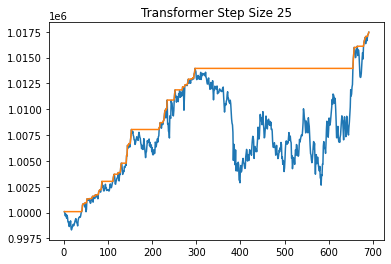

In [5]:
def summ_and_plot(x, y, periods_per_day=10, mult=10_000, capital=1_000_000, contracts=1, adj=252, title=""):
    rets = backtest(x, y, periods_per_day=periods_per_day, mult=mult, capital=capital, contracts=contracts)
    summ = perf_summ(rets["pct_pnl"], adj=adj, title=title)
    display(summ)
    plt.plot(rets["portfolio"])
    plt.plot(rets["portfolio"].cummax())
    plt.title(title)
    plt.show()
    return summ, rets

rets_agg, tf_rets25 = summ_and_plot(x, y, title="Transformer Step Size 25")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 26)]     0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 50, 26)      52          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 50, 26)      109594      ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

15/15 [==============================] - 20s 33ms/step - loss: 3767.9175
Epoch 2/200
15/15 [==============================] - ETA: 0s - loss: 2712.4006

15/15 [==============================] - 0s 31ms/step - loss: 2712.4006
Epoch 3/200
15/15 [==============================] - ETA: 0s - loss: 2208.7581

15/15 [==============================] - 0s 31ms/step - loss: 2208.7581
Epoch 4/200
15/15 [==============================] - ETA: 0s - loss: 2171.7969

15/15 [==============================] - 0s 29ms/step - loss: 2171.7969
Epoch 5/200
15/15 [==============================] - ETA: 0s - loss: 1973.4116

15/15 [==============================] - 1s 34ms/step - loss: 1973.4116
Epoch 6/200
15/15 [==============================] - ETA: 0s - loss: 1798.0338

15/15 [==============================] - 0s 30ms/step - loss: 1798.0338
Epoch 7/200
15/15 [==============================] - ETA: 0s - loss: 1689.4152

15/15 [==============================] - 0s 31ms/step - loss: 1689.4152
Epoch 8/200
15/15 [==============================] - ETA: 0s - loss: 1349.9601

15/15 [==============================] - 0s 31ms/step - loss: 1349.9601
Epoch 9/200
15/15 [==============================] - ETA: 0s - loss: 1301.9948

15/15 [==============================] - 0s 30ms/step - loss: 1301.9948
Epoch 10/200
15/15 [==============================] - ETA: 0s - loss: 1054.6285

15/15 [==============================] - 0s 28ms/step - loss: 1054.6285
Epoch 11/200
15/15 [==============================] - ETA: 0s - loss: 923.1350

15/15 [==============================] - 0s 28ms/step - loss: 923.1350
Epoch 12/200
15/15 [==============================] - ETA: 0s - loss: 787.7369

15/15 [==============================] - 0s 28ms/step - loss: 787.7369
Epoch 13/200
15/15 [==============================] - ETA: 0s - loss: 650.1743

15/15 [==============================] - 0s 28ms/step - loss: 650.1743
Epoch 14/200
15/15 [==============================] - ETA: 0s - loss: 581.7952

15/15 [==============================] - 0s 28ms/step - loss: 581.7952
Epoch 15/200
15/15 [==============================] - ETA: 0s - loss: 461.2827

15/15 [==============================] - 0s 27ms/step - loss: 461.2827
Epoch 16/200
15/15 [==============================] - ETA: 0s - loss: 404.0174

15/15 [==============================] - 0s 27ms/step - loss: 404.0174
Epoch 17/200
15/15 [==============================] - ETA: 0s - loss: 332.9007

15/15 [==============================] - 0s 28ms/step - loss: 332.9007
Epoch 18/200
15/15 [==============================] - ETA: 0s - loss: 276.2914

15/15 [==============================] - 0s 28ms/step - loss: 276.2914
Epoch 19/200
15/15 [==============================] - ETA: 0s - loss: 232.3635

15/15 [==============================] - 0s 29ms/step - loss: 232.3635
Epoch 20/200
15/15 [==============================] - ETA: 0s - loss: 186.3606

15/15 [==============================] - 0s 27ms/step - loss: 186.3606
Epoch 21/200
15/15 [==============================] - ETA: 0s - loss: 146.7883

15/15 [==============================] - 0s 30ms/step - loss: 146.7883
Epoch 22/200
15/15 [==============================] - ETA: 0s - loss: 121.8506

15/15 [==============================] - 0s 28ms/step - loss: 121.8506
Epoch 23/200
15/15 [==============================] - ETA: 0s - loss: 96.3501

15/15 [==============================] - 0s 28ms/step - loss: 96.3501
Epoch 24/200
15/15 [==============================] - ETA: 0s - loss: 78.4998

15/15 [==============================] - 0s 28ms/step - loss: 78.4998
Epoch 25/200
15/15 [==============================] - ETA: 0s - loss: 69.4732

15/15 [==============================] - 0s 27ms/step - loss: 69.4732
Epoch 26/200
15/15 [==============================] - ETA: 0s - loss: 58.8189

15/15 [==============================] - 0s 28ms/step - loss: 58.8189
Epoch 27/200
15/15 [==============================] - ETA: 0s - loss: 41.9266

15/15 [==============================] - 0s 27ms/step - loss: 41.9266
Epoch 28/200
15/15 [==============================] - ETA: 0s - loss: 37.0822

15/15 [==============================] - 0s 27ms/step - loss: 37.0822
Epoch 29/200
15/15 [==============================] - ETA: 0s - loss: 33.9039

15/15 [==============================] - 0s 28ms/step - loss: 33.9039
Epoch 30/200
15/15 [==============================] - ETA: 0s - loss: 29.2029

15/15 [==============================] - 0s 28ms/step - loss: 29.2029
Epoch 31/200
15/15 [==============================] - ETA: 0s - loss: 25.3106

15/15 [==============================] - 0s 28ms/step - loss: 25.3106
Epoch 32/200
15/15 [==============================] - ETA: 0s - loss: 24.6640

15/15 [==============================] - 0s 28ms/step - loss: 24.6640
Epoch 33/200
15/15 [==============================] - ETA: 0s - loss: 20.5000

15/15 [==============================] - 0s 31ms/step - loss: 20.5000
Epoch 34/200
15/15 [==============================] - ETA: 0s - loss: 19.6622

15/15 [==============================] - 0s 31ms/step - loss: 19.6622
Epoch 35/200
15/15 [==============================] - ETA: 0s - loss: 17.6122

15/15 [==============================] - 0s 29ms/step - loss: 17.6122
Epoch 36/200
15/15 [==============================] - ETA: 0s - loss: 17.2431

15/15 [==============================] - 0s 30ms/step - loss: 17.2431
Epoch 37/200
15/15 [==============================] - ETA: 0s - loss: 16.1741

15/15 [==============================] - 0s 29ms/step - loss: 16.1741
Epoch 38/200
15/15 [==============================] - ETA: 0s - loss: 16.4804

15/15 [==============================] - 0s 29ms/step - loss: 16.4804
Epoch 39/200
15/15 [==============================] - ETA: 0s - loss: 15.8439

15/15 [==============================] - 0s 29ms/step - loss: 15.8439
Epoch 40/200
15/15 [==============================] - ETA: 0s - loss: 15.0564

15/15 [==============================] - 0s 30ms/step - loss: 15.0564
Epoch 41/200
15/15 [==============================] - ETA: 0s - loss: 15.0698

15/15 [==============================] - 0s 31ms/step - loss: 15.0698
Epoch 42/200
15/15 [==============================] - ETA: 0s - loss: 15.4085

15/15 [==============================] - 0s 29ms/step - loss: 15.4085
Epoch 43/200
15/15 [==============================] - ETA: 0s - loss: 15.8216

15/15 [==============================] - 0s 28ms/step - loss: 15.8216
Epoch 44/200
15/15 [==============================] - ETA: 0s - loss: 15.5564

15/15 [==============================] - 0s 28ms/step - loss: 15.5564
Epoch 45/200
15/15 [==============================] - ETA: 0s - loss: 13.2073

15/15 [==============================] - 0s 29ms/step - loss: 13.2073
Epoch 46/200
15/15 [==============================] - ETA: 0s - loss: 14.3275

15/15 [==============================] - 0s 27ms/step - loss: 14.3275
Epoch 47/200
15/15 [==============================] - ETA: 0s - loss: 14.1972

15/15 [==============================] - 0s 31ms/step - loss: 14.1972
Epoch 48/200
15/15 [==============================] - ETA: 0s - loss: 13.0685

15/15 [==============================] - 0s 29ms/step - loss: 13.0685
Epoch 49/200
15/15 [==============================] - ETA: 0s - loss: 13.6148

15/15 [==============================] - 0s 29ms/step - loss: 13.6148
Epoch 50/200
15/15 [==============================] - ETA: 0s - loss: 13.7669

15/15 [==============================] - 0s 30ms/step - loss: 13.7669
Epoch 51/200
15/15 [==============================] - ETA: 0s - loss: 13.0524

15/15 [==============================] - 0s 28ms/step - loss: 13.0524
Epoch 52/200
15/15 [==============================] - ETA: 0s - loss: 12.8622

15/15 [==============================] - 0s 28ms/step - loss: 12.8622
Epoch 53/200
15/15 [==============================] - ETA: 0s - loss: 11.8932

15/15 [==============================] - 0s 28ms/step - loss: 11.8932
Epoch 54/200
15/15 [==============================] - ETA: 0s - loss: 13.1444

15/15 [==============================] - 0s 27ms/step - loss: 13.1444
Epoch 55/200
15/15 [==============================] - ETA: 0s - loss: 12.8777

15/15 [==============================] - 0s 28ms/step - loss: 12.8777
Epoch 56/200
15/15 [==============================] - ETA: 0s - loss: 11.6032

15/15 [==============================] - 0s 28ms/step - loss: 11.6032
Epoch 57/200
15/15 [==============================] - ETA: 0s - loss: 11.8212

15/15 [==============================] - 0s 28ms/step - loss: 11.8212
Epoch 58/200
15/15 [==============================] - ETA: 0s - loss: 11.6135

15/15 [==============================] - 0s 28ms/step - loss: 11.6135
Epoch 59/200
15/15 [==============================] - ETA: 0s - loss: 11.9304

15/15 [==============================] - 0s 28ms/step - loss: 11.9304
Epoch 60/200
15/15 [==============================] - ETA: 0s - loss: 12.1634

15/15 [==============================] - 0s 28ms/step - loss: 12.1634
Epoch 61/200
15/15 [==============================] - ETA: 0s - loss: 11.5009

15/15 [==============================] - 0s 28ms/step - loss: 11.5009
Epoch 62/200
15/15 [==============================] - ETA: 0s - loss: 11.3366

15/15 [==============================] - 0s 29ms/step - loss: 11.3366
Epoch 63/200
15/15 [==============================] - ETA: 0s - loss: 11.1361

15/15 [==============================] - 0s 28ms/step - loss: 11.1361
Epoch 64/200
15/15 [==============================] - ETA: 0s - loss: 11.1972

15/15 [==============================] - 0s 28ms/step - loss: 11.1972
Epoch 65/200
15/15 [==============================] - ETA: 0s - loss: 10.6562

15/15 [==============================] - 0s 30ms/step - loss: 10.6562
Epoch 66/200
15/15 [==============================] - ETA: 0s - loss: 9.9481

15/15 [==============================] - 0s 30ms/step - loss: 9.9481
Epoch 67/200
15/15 [==============================] - ETA: 0s - loss: 11.1812

15/15 [==============================] - 0s 29ms/step - loss: 11.1812
Epoch 68/200
15/15 [==============================] - ETA: 0s - loss: 10.9964

15/15 [==============================] - 0s 32ms/step - loss: 10.9964
Epoch 69/200
15/15 [==============================] - ETA: 0s - loss: 10.1989

15/15 [==============================] - 0s 30ms/step - loss: 10.1989
Epoch 70/200
15/15 [==============================] - ETA: 0s - loss: 10.5990

15/15 [==============================] - 0s 30ms/step - loss: 10.5990
Epoch 71/200
15/15 [==============================] - ETA: 0s - loss: 9.9227 

15/15 [==============================] - 0s 31ms/step - loss: 9.9227
Epoch 72/200
15/15 [==============================] - ETA: 0s - loss: 9.9038

15/15 [==============================] - 0s 32ms/step - loss: 9.9038
Epoch 73/200
15/15 [==============================] - ETA: 0s - loss: 9.3219

15/15 [==============================] - 0s 31ms/step - loss: 9.3219
Epoch 74/200
15/15 [==============================] - ETA: 0s - loss: 9.7423

15/15 [==============================] - 0s 30ms/step - loss: 9.7423
Epoch 75/200
15/15 [==============================] - ETA: 0s - loss: 10.2602

15/15 [==============================] - 0s 29ms/step - loss: 10.2602
Epoch 76/200
15/15 [==============================] - ETA: 0s - loss: 9.9245

15/15 [==============================] - 0s 29ms/step - loss: 9.9245
Epoch 77/200
15/15 [==============================] - ETA: 0s - loss: 10.5211

15/15 [==============================] - 0s 28ms/step - loss: 10.5211
Epoch 78/200
15/15 [==============================] - ETA: 0s - loss: 10.3239

15/15 [==============================] - 0s 28ms/step - loss: 10.3239
Epoch 79/200
15/15 [==============================] - ETA: 0s - loss: 9.5377

15/15 [==============================] - 0s 28ms/step - loss: 9.5377
Epoch 80/200
15/15 [==============================] - ETA: 0s - loss: 10.6060

15/15 [==============================] - 0s 28ms/step - loss: 10.6060
Epoch 81/200
15/15 [==============================] - ETA: 0s - loss: 9.2844

15/15 [==============================] - 0s 28ms/step - loss: 9.2844
Epoch 82/200
15/15 [==============================] - ETA: 0s - loss: 9.5671

15/15 [==============================] - 0s 29ms/step - loss: 9.5671
Epoch 83/200
15/15 [==============================] - ETA: 0s - loss: 9.4164

15/15 [==============================] - 0s 28ms/step - loss: 9.4164
Epoch 84/200
15/15 [==============================] - ETA: 0s - loss: 9.5520

15/15 [==============================] - 0s 28ms/step - loss: 9.5520
Epoch 85/200
15/15 [==============================] - ETA: 0s - loss: 9.9922

15/15 [==============================] - 0s 29ms/step - loss: 9.9922
Epoch 86/200
15/15 [==============================] - ETA: 0s - loss: 10.3048

15/15 [==============================] - 0s 28ms/step - loss: 10.3048
Epoch 87/200
15/15 [==============================] - ETA: 0s - loss: 8.7039

15/15 [==============================] - 0s 29ms/step - loss: 8.7039
Epoch 88/200
15/15 [==============================] - ETA: 0s - loss: 9.3074

15/15 [==============================] - 0s 28ms/step - loss: 9.3074
Epoch 89/200
15/15 [==============================] - ETA: 0s - loss: 9.8770 

15/15 [==============================] - 0s 28ms/step - loss: 9.8770
Epoch 90/200
15/15 [==============================] - ETA: 0s - loss: 9.0317

15/15 [==============================] - 0s 28ms/step - loss: 9.0317
Epoch 91/200
15/15 [==============================] - ETA: 0s - loss: 9.0872

15/15 [==============================] - 0s 29ms/step - loss: 9.0872
Epoch 92/200
15/15 [==============================] - ETA: 0s - loss: 8.8227

15/15 [==============================] - 0s 30ms/step - loss: 8.8227
Epoch 93/200
15/15 [==============================] - ETA: 0s - loss: 9.1655

15/15 [==============================] - 0s 28ms/step - loss: 9.1655
Epoch 94/200
15/15 [==============================] - ETA: 0s - loss: 8.6599

15/15 [==============================] - 0s 28ms/step - loss: 8.6599
Epoch 95/200
15/15 [==============================] - ETA: 0s - loss: 8.7196

15/15 [==============================] - 0s 29ms/step - loss: 8.7196
Epoch 96/200
15/15 [==============================] - ETA: 0s - loss: 9.3657

15/15 [==============================] - 0s 29ms/step - loss: 9.3657
Epoch 97/200
15/15 [==============================] - ETA: 0s - loss: 8.6619

15/15 [==============================] - 0s 29ms/step - loss: 8.6619
Epoch 98/200
15/15 [==============================] - ETA: 0s - loss: 8.7977

15/15 [==============================] - 0s 31ms/step - loss: 8.7977
Epoch 99/200
15/15 [==============================] - ETA: 0s - loss: 8.3603

15/15 [==============================] - 0s 31ms/step - loss: 8.3603
Epoch 100/200
15/15 [==============================] - ETA: 0s - loss: 7.9590

15/15 [==============================] - 0s 30ms/step - loss: 7.9590
Epoch 101/200
15/15 [==============================] - ETA: 0s - loss: 9.1074

15/15 [==============================] - 0s 30ms/step - loss: 9.1074
Epoch 102/200
15/15 [==============================] - ETA: 0s - loss: 8.5405

15/15 [==============================] - 0s 29ms/step - loss: 8.5405
Epoch 103/200
15/15 [==============================] - ETA: 0s - loss: 8.5916

15/15 [==============================] - 0s 31ms/step - loss: 8.5916
Epoch 104/200
15/15 [==============================] - ETA: 0s - loss: 9.2059

15/15 [==============================] - 0s 30ms/step - loss: 9.2059
Epoch 105/200
15/15 [==============================] - ETA: 0s - loss: 8.8886

15/15 [==============================] - 0s 30ms/step - loss: 8.8886
Epoch 106/200
15/15 [==============================] - ETA: 0s - loss: 8.6617

15/15 [==============================] - 1s 34ms/step - loss: 8.6617
Epoch 107/200
15/15 [==============================] - ETA: 0s - loss: 8.5247

15/15 [==============================] - 0s 28ms/step - loss: 8.5247
Epoch 108/200
15/15 [==============================] - ETA: 0s - loss: 9.1728

15/15 [==============================] - 0s 30ms/step - loss: 9.1728
Epoch 109/200
15/15 [==============================] - ETA: 0s - loss: 8.1034

15/15 [==============================] - 0s 28ms/step - loss: 8.1034
Epoch 110/200
15/15 [==============================] - ETA: 0s - loss: 8.4204

15/15 [==============================] - 0s 29ms/step - loss: 8.4204
Epoch 111/200
15/15 [==============================] - ETA: 0s - loss: 8.4261

15/15 [==============================] - 0s 29ms/step - loss: 8.4261
Epoch 112/200
15/15 [==============================] - ETA: 0s - loss: 8.5904

15/15 [==============================] - 0s 29ms/step - loss: 8.5904
Epoch 113/200
15/15 [==============================] - ETA: 0s - loss: 8.0732

15/15 [==============================] - 0s 28ms/step - loss: 8.0732
Epoch 114/200
15/15 [==============================] - ETA: 0s - loss: 7.9649

15/15 [==============================] - 0s 28ms/step - loss: 7.9649
Epoch 115/200
15/15 [==============================] - ETA: 0s - loss: 8.4838

15/15 [==============================] - 0s 29ms/step - loss: 8.4838
Epoch 116/200
15/15 [==============================] - ETA: 0s - loss: 8.4166

15/15 [==============================] - 0s 29ms/step - loss: 8.4166
Epoch 117/200
15/15 [==============================] - ETA: 0s - loss: 7.5398

15/15 [==============================] - 0s 28ms/step - loss: 7.5398
Epoch 118/200
15/15 [==============================] - ETA: 0s - loss: 7.5236

15/15 [==============================] - 0s 29ms/step - loss: 7.5236
Epoch 119/200
15/15 [==============================] - ETA: 0s - loss: 7.3925

15/15 [==============================] - 0s 28ms/step - loss: 7.3925
Epoch 120/200
15/15 [==============================] - ETA: 0s - loss: 8.1015

15/15 [==============================] - 0s 29ms/step - loss: 8.1015
Epoch 121/200
15/15 [==============================] - ETA: 0s - loss: 8.4224

15/15 [==============================] - 0s 29ms/step - loss: 8.4224
Epoch 122/200
15/15 [==============================] - ETA: 0s - loss: 8.1528

15/15 [==============================] - 0s 29ms/step - loss: 8.1528
Epoch 123/200
15/15 [==============================] - ETA: 0s - loss: 8.4028

15/15 [==============================] - 0s 28ms/step - loss: 8.4028
Epoch 124/200
15/15 [==============================] - ETA: 0s - loss: 7.9583

15/15 [==============================] - 0s 29ms/step - loss: 7.9583
Epoch 125/200
15/15 [==============================] - ETA: 0s - loss: 8.1045

15/15 [==============================] - 0s 30ms/step - loss: 8.1045
Epoch 126/200
15/15 [==============================] - ETA: 0s - loss: 8.0519

15/15 [==============================] - 0s 29ms/step - loss: 8.0519
Epoch 127/200
15/15 [==============================] - ETA: 0s - loss: 7.8017

15/15 [==============================] - 0s 29ms/step - loss: 7.8017
Epoch 128/200
15/15 [==============================] - ETA: 0s - loss: 8.3645

15/15 [==============================] - 0s 29ms/step - loss: 8.3645
Epoch 129/200
15/15 [==============================] - ETA: 0s - loss: 7.8982

15/15 [==============================] - 0s 30ms/step - loss: 7.8982
Epoch 130/200
15/15 [==============================] - ETA: 0s - loss: 8.5260

15/15 [==============================] - 0s 32ms/step - loss: 8.5260
Epoch 131/200
15/15 [==============================] - ETA: 0s - loss: 7.3563

15/15 [==============================] - 0s 29ms/step - loss: 7.3563
Epoch 132/200
15/15 [==============================] - ETA: 0s - loss: 7.2002

15/15 [==============================] - 0s 30ms/step - loss: 7.2002
Epoch 133/200
15/15 [==============================] - ETA: 0s - loss: 7.8078

15/15 [==============================] - 0s 31ms/step - loss: 7.8078
Epoch 134/200
15/15 [==============================] - ETA: 0s - loss: 7.2174

15/15 [==============================] - 0s 32ms/step - loss: 7.2174
Epoch 135/200
15/15 [==============================] - ETA: 0s - loss: 7.8036

15/15 [==============================] - 0s 31ms/step - loss: 7.8036
Epoch 136/200
15/15 [==============================] - ETA: 0s - loss: 7.7878

15/15 [==============================] - 0s 32ms/step - loss: 7.7878
Epoch 137/200
15/15 [==============================] - ETA: 0s - loss: 7.4521

15/15 [==============================] - 0s 31ms/step - loss: 7.4521
Epoch 138/200
15/15 [==============================] - ETA: 0s - loss: 7.5767

15/15 [==============================] - 0s 31ms/step - loss: 7.5767
Epoch 139/200
15/15 [==============================] - ETA: 0s - loss: 7.7279

15/15 [==============================] - 0s 29ms/step - loss: 7.7279
Epoch 140/200
15/15 [==============================] - ETA: 0s - loss: 6.5762

15/15 [==============================] - 0s 29ms/step - loss: 6.5762
Epoch 141/200
15/15 [==============================] - ETA: 0s - loss: 6.7363

15/15 [==============================] - 0s 28ms/step - loss: 6.7363
Epoch 142/200
15/15 [==============================] - ETA: 0s - loss: 7.0173

15/15 [==============================] - 0s 28ms/step - loss: 7.0173
Epoch 143/200
15/15 [==============================] - ETA: 0s - loss: 6.4820

15/15 [==============================] - 0s 29ms/step - loss: 6.4820
Epoch 144/200
15/15 [==============================] - ETA: 0s - loss: 7.0468

15/15 [==============================] - 0s 29ms/step - loss: 7.0468
Epoch 145/200
15/15 [==============================] - ETA: 0s - loss: 6.6442

15/15 [==============================] - 0s 29ms/step - loss: 6.6442
Epoch 146/200
15/15 [==============================] - ETA: 0s - loss: 6.3445

15/15 [==============================] - 0s 29ms/step - loss: 6.3445
Epoch 147/200
15/15 [==============================] - ETA: 0s - loss: 6.6758

15/15 [==============================] - 0s 28ms/step - loss: 6.6758
Epoch 148/200
15/15 [==============================] - ETA: 0s - loss: 6.6975

15/15 [==============================] - 0s 28ms/step - loss: 6.6975
Epoch 149/200
15/15 [==============================] - ETA: 0s - loss: 6.4907

15/15 [==============================] - 0s 29ms/step - loss: 6.4907
Epoch 150/200
15/15 [==============================] - ETA: 0s - loss: 6.4121

15/15 [==============================] - 0s 28ms/step - loss: 6.4121
Epoch 151/200
15/15 [==============================] - ETA: 0s - loss: 7.1217

15/15 [==============================] - 0s 28ms/step - loss: 7.1217
Epoch 152/200
15/15 [==============================] - ETA: 0s - loss: 6.6222

15/15 [==============================] - 0s 29ms/step - loss: 6.6222
Epoch 153/200
15/15 [==============================] - ETA: 0s - loss: 6.6543

15/15 [==============================] - 0s 29ms/step - loss: 6.6543
Epoch 154/200
15/15 [==============================] - ETA: 0s - loss: 6.7570

15/15 [==============================] - 0s 29ms/step - loss: 6.7570
Epoch 155/200
15/15 [==============================] - ETA: 0s - loss: 6.3459

15/15 [==============================] - 0s 29ms/step - loss: 6.3459
Epoch 156/200
15/15 [==============================] - ETA: 0s - loss: 6.8861

15/15 [==============================] - 0s 28ms/step - loss: 6.8861
Epoch 157/200
15/15 [==============================] - ETA: 0s - loss: 6.3309

15/15 [==============================] - 0s 29ms/step - loss: 6.3309
Epoch 158/200
15/15 [==============================] - ETA: 0s - loss: 6.1199

15/15 [==============================] - 0s 29ms/step - loss: 6.1199
Epoch 159/200
15/15 [==============================] - ETA: 0s - loss: 6.1087

15/15 [==============================] - 0s 29ms/step - loss: 6.1087
Epoch 160/200
15/15 [==============================] - ETA: 0s - loss: 6.2872

15/15 [==============================] - 0s 29ms/step - loss: 6.2872
Epoch 161/200
15/15 [==============================] - ETA: 0s - loss: 5.6271

15/15 [==============================] - 0s 33ms/step - loss: 5.6271
Epoch 162/200
15/15 [==============================] - ETA: 0s - loss: 5.8474

15/15 [==============================] - 1s 33ms/step - loss: 5.8474
Epoch 163/200
15/15 [==============================] - ETA: 0s - loss: 5.7799

15/15 [==============================] - 0s 31ms/step - loss: 5.7799
Epoch 164/200
15/15 [==============================] - ETA: 0s - loss: 5.6011

15/15 [==============================] - 0s 32ms/step - loss: 5.6011
Epoch 165/200
15/15 [==============================] - ETA: 0s - loss: 5.9647

15/15 [==============================] - 1s 33ms/step - loss: 5.9647
Epoch 166/200
15/15 [==============================] - ETA: 0s - loss: 5.9938

15/15 [==============================] - 0s 31ms/step - loss: 5.9938
Epoch 167/200
15/15 [==============================] - ETA: 0s - loss: 5.9758

15/15 [==============================] - 0s 30ms/step - loss: 5.9758
Epoch 168/200
15/15 [==============================] - ETA: 0s - loss: 5.2647

15/15 [==============================] - 0s 31ms/step - loss: 5.2647
Epoch 169/200
15/15 [==============================] - ETA: 0s - loss: 5.6983

15/15 [==============================] - 0s 31ms/step - loss: 5.6983
Epoch 170/200
15/15 [==============================] - ETA: 0s - loss: 5.2807

15/15 [==============================] - 0s 30ms/step - loss: 5.2807
Epoch 171/200
15/15 [==============================] - ETA: 0s - loss: 5.7065

15/15 [==============================] - 0s 29ms/step - loss: 5.7065
Epoch 172/200
15/15 [==============================] - ETA: 0s - loss: 5.3320

15/15 [==============================] - 0s 30ms/step - loss: 5.3320
Epoch 173/200
15/15 [==============================] - ETA: 0s - loss: 5.5537

15/15 [==============================] - 0s 29ms/step - loss: 5.5537
Epoch 174/200
15/15 [==============================] - ETA: 0s - loss: 5.0552

15/15 [==============================] - 0s 29ms/step - loss: 5.0552
Epoch 175/200
15/15 [==============================] - ETA: 0s - loss: 5.0633

15/15 [==============================] - 0s 28ms/step - loss: 5.0633
Epoch 176/200
15/15 [==============================] - ETA: 0s - loss: 5.0968

15/15 [==============================] - 0s 28ms/step - loss: 5.0968
Epoch 177/200
15/15 [==============================] - ETA: 0s - loss: 4.9774

15/15 [==============================] - 0s 30ms/step - loss: 4.9774
Epoch 178/200
15/15 [==============================] - ETA: 0s - loss: 4.8998

15/15 [==============================] - 0s 29ms/step - loss: 4.8998
Epoch 179/200
15/15 [==============================] - ETA: 0s - loss: 4.4938

15/15 [==============================] - 0s 29ms/step - loss: 4.4938
Epoch 180/200
15/15 [==============================] - ETA: 0s - loss: 4.2226

15/15 [==============================] - 0s 29ms/step - loss: 4.2226
Epoch 181/200
15/15 [==============================] - ETA: 0s - loss: 4.6747

15/15 [==============================] - 0s 28ms/step - loss: 4.6747
Epoch 182/200
15/15 [==============================] - ETA: 0s - loss: 4.4411

15/15 [==============================] - 0s 29ms/step - loss: 4.4411
Epoch 183/200
15/15 [==============================] - ETA: 0s - loss: 4.4326

15/15 [==============================] - 0s 29ms/step - loss: 4.4326
Epoch 184/200
15/15 [==============================] - ETA: 0s - loss: 4.4234

15/15 [==============================] - 0s 29ms/step - loss: 4.4234
Epoch 185/200
15/15 [==============================] - ETA: 0s - loss: 4.0565

15/15 [==============================] - 0s 29ms/step - loss: 4.0565
Epoch 186/200
15/15 [==============================] - ETA: 0s - loss: 4.2581

15/15 [==============================] - 0s 29ms/step - loss: 4.2581
Epoch 187/200
15/15 [==============================] - ETA: 0s - loss: 3.9847

15/15 [==============================] - 0s 29ms/step - loss: 3.9847
Epoch 188/200
15/15 [==============================] - ETA: 0s - loss: 3.6235

15/15 [==============================] - 0s 29ms/step - loss: 3.6235
Epoch 189/200
15/15 [==============================] - ETA: 0s - loss: 3.7103

15/15 [==============================] - 0s 29ms/step - loss: 3.7103
Epoch 190/200
15/15 [==============================] - ETA: 0s - loss: 3.8667

15/15 [==============================] - 0s 29ms/step - loss: 3.8667
Epoch 191/200
15/15 [==============================] - ETA: 0s - loss: 3.6257

15/15 [==============================] - 0s 29ms/step - loss: 3.6257
Epoch 192/200
15/15 [==============================] - ETA: 0s - loss: 3.3345

15/15 [==============================] - 0s 29ms/step - loss: 3.3345
Epoch 193/200
15/15 [==============================] - ETA: 0s - loss: 3.3780

15/15 [==============================] - 0s 32ms/step - loss: 3.3780
Epoch 194/200
15/15 [==============================] - ETA: 0s - loss: 3.8080

15/15 [==============================] - 0s 30ms/step - loss: 3.8080
Epoch 195/200
15/15 [==============================] - ETA: 0s - loss: 3.3390

15/15 [==============================] - 0s 31ms/step - loss: 3.3390
Epoch 196/200
15/15 [==============================] - ETA: 0s - loss: 3.2691

15/15 [==============================] - 0s 29ms/step - loss: 3.2691
Epoch 197/200
15/15 [==============================] - ETA: 0s - loss: 3.1731

15/15 [==============================] - 0s 30ms/step - loss: 3.1731
Epoch 198/200
15/15 [==============================] - ETA: 0s - loss: 3.1439

15/15 [==============================] - 0s 31ms/step - loss: 3.1439
Epoch 199/200
15/15 [==============================] - ETA: 0s - loss: 2.8213

15/15 [==============================] - 0s 33ms/step - loss: 2.8213
Epoch 200/200
15/15 [==============================] - ETA: 0s - loss: 2.8156

15/15 [==============================] - 0s 30ms/step - loss: 2.8156


  0%|          | 0/139 [00:00<?, ?it/s]

2/2 [==============================] - 0s 36ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.5586

1/1 [==============================] - 0s 114ms/step - loss: 2.5586
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.7671

1/1 [==============================] - 0s 45ms/step - loss: 1.7671
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.8807

1/1 [==============================] - 0s 37ms/step - loss: 2.8807
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.4219

1/1 [==============================] - 0s 35ms/step - loss: 2.4219
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.9384

1/1 [==============================] - 0s 35ms/step - loss: 2.9384


  1%|          | 1/139 [00:00<02:04,  1.11it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.4934

1/1 [==============================] - 0s 39ms/step - loss: 2.4934
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.1331

1/1 [==============================] - 0s 36ms/step - loss: 3.1331
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.4624

1/1 [==============================] - 0s 39ms/step - loss: 2.4624
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2244

1/1 [==============================] - 0s 37ms/step - loss: 2.2244
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 4.0656

1/1 [==============================] - 0s 35ms/step - loss: 4.0656


  1%|▏         | 2/139 [00:01<01:29,  1.53it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 4.1230

1/1 [==============================] - 0s 35ms/step - loss: 4.1230
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7504

1/1 [==============================] - 0s 39ms/step - loss: 2.7504
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2163

1/1 [==============================] - 0s 40ms/step - loss: 3.2163
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6574

1/1 [==============================] - 0s 53ms/step - loss: 3.6574
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.2043

1/1 [==============================] - 0s 37ms/step - loss: 2.2043


  2%|▏         | 3/139 [00:01<01:13,  1.85it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.0539

1/1 [==============================] - 0s 43ms/step - loss: 3.0539
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.1179

1/1 [==============================] - 0s 41ms/step - loss: 2.1179
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.1783

1/1 [==============================] - 0s 42ms/step - loss: 3.1783
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.0858

1/1 [==============================] - 0s 36ms/step - loss: 3.0858
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.0352

1/1 [==============================] - 0s 35ms/step - loss: 2.0352


  3%|▎         | 4/139 [00:02<01:03,  2.14it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.9375

1/1 [==============================] - 0s 44ms/step - loss: 2.9375
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8569

1/1 [==============================] - 0s 35ms/step - loss: 2.8569
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.1146

1/1 [==============================] - 0s 42ms/step - loss: 2.1146
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.6339

1/1 [==============================] - 0s 36ms/step - loss: 3.6339
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.9145

1/1 [==============================] - 0s 34ms/step - loss: 1.9145


  4%|▎         | 5/139 [00:02<01:01,  2.17it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4010

1/1 [==============================] - 0s 38ms/step - loss: 3.4010
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7008

1/1 [==============================] - 0s 42ms/step - loss: 2.7008
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6017

1/1 [==============================] - 0s 39ms/step - loss: 2.6017
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6737

1/1 [==============================] - 0s 50ms/step - loss: 2.6737
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8658

1/1 [==============================] - 0s 43ms/step - loss: 2.8658


  4%|▍         | 6/139 [00:03<01:00,  2.21it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.1106

1/1 [==============================] - 0s 44ms/step - loss: 2.1106
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7981

1/1 [==============================] - 0s 43ms/step - loss: 2.7981
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.9020

1/1 [==============================] - 0s 43ms/step - loss: 1.9020
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.7491

1/1 [==============================] - 0s 45ms/step - loss: 2.7491
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.8674

1/1 [==============================] - 0s 43ms/step - loss: 1.8674


  5%|▌         | 7/139 [00:03<01:03,  2.09it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.6688

1/1 [==============================] - 0s 44ms/step - loss: 1.6688
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.4511

1/1 [==============================] - 0s 41ms/step - loss: 3.4511
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.4880

1/1 [==============================] - 0s 46ms/step - loss: 1.4880
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.9831

1/1 [==============================] - 0s 46ms/step - loss: 1.9831
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.2945

1/1 [==============================] - 0s 40ms/step - loss: 2.2945


  6%|▌         | 8/139 [00:04<01:05,  2.01it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.4065

1/1 [==============================] - 0s 48ms/step - loss: 2.4065
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5451

1/1 [==============================] - 0s 41ms/step - loss: 2.5451
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.3814

1/1 [==============================] - 0s 39ms/step - loss: 2.3814
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.1366

1/1 [==============================] - 0s 51ms/step - loss: 3.1366
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.2536

1/1 [==============================] - 0s 60ms/step - loss: 3.2536


  6%|▋         | 9/139 [00:04<01:02,  2.08it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.2721

1/1 [==============================] - 0s 45ms/step - loss: 2.2721
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.4857

1/1 [==============================] - 0s 48ms/step - loss: 2.4857
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.4901

1/1 [==============================] - 0s 41ms/step - loss: 2.4901
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.5399

1/1 [==============================] - 0s 55ms/step - loss: 1.5399
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.3259

1/1 [==============================] - 0s 47ms/step - loss: 2.3259


  7%|▋         | 10/139 [00:05<01:04,  2.00it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.8463

1/1 [==============================] - 0s 56ms/step - loss: 1.8463
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5937

1/1 [==============================] - 0s 49ms/step - loss: 2.5937
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.5575

1/1 [==============================] - 0s 52ms/step - loss: 3.5575
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4473

1/1 [==============================] - 0s 51ms/step - loss: 3.4473
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.4470

1/1 [==============================] - 0s 49ms/step - loss: 2.4470


  8%|▊         | 11/139 [00:05<01:05,  1.97it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.1197

1/1 [==============================] - 0s 55ms/step - loss: 2.1197
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7143

1/1 [==============================] - 0s 48ms/step - loss: 2.7143
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.2467

1/1 [==============================] - 0s 51ms/step - loss: 2.2467
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3260

1/1 [==============================] - 0s 51ms/step - loss: 3.3260
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.4544

1/1 [==============================] - 0s 48ms/step - loss: 3.4544


  9%|▊         | 12/139 [00:06<01:04,  1.96it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.5442

1/1 [==============================] - 0s 48ms/step - loss: 2.5442
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5688

1/1 [==============================] - 0s 49ms/step - loss: 2.5688
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.7422

1/1 [==============================] - 0s 44ms/step - loss: 2.7422
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.1067

1/1 [==============================] - 0s 50ms/step - loss: 2.1067
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.7644

1/1 [==============================] - 0s 41ms/step - loss: 2.7644


  9%|▉         | 13/139 [00:06<01:01,  2.06it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.7232

1/1 [==============================] - 0s 53ms/step - loss: 2.7232
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 3.2312

1/1 [==============================] - 0s 49ms/step - loss: 3.2312
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.1934

1/1 [==============================] - 0s 40ms/step - loss: 2.1934
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.9471

1/1 [==============================] - 0s 42ms/step - loss: 1.9471
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8277

1/1 [==============================] - 0s 42ms/step - loss: 2.8277


 10%|█         | 14/139 [00:07<01:03,  1.98it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.6471

1/1 [==============================] - 0s 42ms/step - loss: 2.6471
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.3013

1/1 [==============================] - 0s 41ms/step - loss: 2.3013
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.3906

1/1 [==============================] - 0s 39ms/step - loss: 2.3906
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.3922

1/1 [==============================] - 0s 39ms/step - loss: 3.3922
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.5540

1/1 [==============================] - 0s 41ms/step - loss: 2.5540


 11%|█         | 15/139 [00:07<00:57,  2.14it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.0469

1/1 [==============================] - 0s 37ms/step - loss: 2.0469
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.2798

1/1 [==============================] - 0s 34ms/step - loss: 2.2798
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.1730

1/1 [==============================] - 0s 42ms/step - loss: 2.1730
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8551

1/1 [==============================] - 0s 34ms/step - loss: 2.8551
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.1220

1/1 [==============================] - 0s 38ms/step - loss: 2.1220


 12%|█▏        | 16/139 [00:07<00:56,  2.16it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.0516

1/1 [==============================] - 0s 39ms/step - loss: 2.0516
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.9977

1/1 [==============================] - 0s 36ms/step - loss: 2.9977
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.2562

1/1 [==============================] - 0s 40ms/step - loss: 2.2562
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.5211

1/1 [==============================] - 0s 38ms/step - loss: 2.5211
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.3233

1/1 [==============================] - 0s 40ms/step - loss: 2.3233


 12%|█▏        | 17/139 [00:08<00:52,  2.33it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.4327

1/1 [==============================] - 0s 34ms/step - loss: 2.4327
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8979

1/1 [==============================] - 0s 43ms/step - loss: 2.8979
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.7725

1/1 [==============================] - 0s 36ms/step - loss: 2.7725
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.4575

1/1 [==============================] - 0s 37ms/step - loss: 3.4575
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.0068

1/1 [==============================] - 0s 38ms/step - loss: 3.0068


 13%|█▎        | 18/139 [00:08<00:52,  2.29it/s]

2/2 [==============================] - 0s 8ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.4569

1/1 [==============================] - 0s 41ms/step - loss: 3.4569
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5671

1/1 [==============================] - 0s 37ms/step - loss: 2.5671
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.7021

1/1 [==============================] - 0s 39ms/step - loss: 1.7021
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.1116

1/1 [==============================] - 0s 34ms/step - loss: 2.1116
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.6558

1/1 [==============================] - 0s 40ms/step - loss: 1.6558


 14%|█▎        | 19/139 [00:09<00:52,  2.28it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.7686

1/1 [==============================] - 0s 36ms/step - loss: 2.7686
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.9329

1/1 [==============================] - 0s 43ms/step - loss: 1.9329
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.2714

1/1 [==============================] - 0s 42ms/step - loss: 2.2714
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.1542

1/1 [==============================] - 0s 38ms/step - loss: 3.1542
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.4956

1/1 [==============================] - 0s 35ms/step - loss: 2.4956


 14%|█▍        | 20/139 [00:09<00:53,  2.23it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.4598

1/1 [==============================] - 0s 39ms/step - loss: 2.4598
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8009

1/1 [==============================] - 0s 35ms/step - loss: 2.8009
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.3954

1/1 [==============================] - 0s 44ms/step - loss: 2.3954
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.0831

1/1 [==============================] - 0s 40ms/step - loss: 2.0831
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.5242

1/1 [==============================] - 0s 42ms/step - loss: 2.5242


 15%|█▌        | 21/139 [00:10<00:53,  2.19it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.4517

1/1 [==============================] - 0s 39ms/step - loss: 2.4517
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7089

1/1 [==============================] - 0s 35ms/step - loss: 2.7089
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.4284

1/1 [==============================] - 0s 39ms/step - loss: 1.4284
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.4404

1/1 [==============================] - 0s 40ms/step - loss: 2.4404
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.3941

1/1 [==============================] - 0s 36ms/step - loss: 2.3941


 16%|█▌        | 22/139 [00:10<00:49,  2.34it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.4638

1/1 [==============================] - 0s 39ms/step - loss: 2.4638
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5890

1/1 [==============================] - 0s 43ms/step - loss: 2.5890
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.8195

1/1 [==============================] - 0s 42ms/step - loss: 1.8195
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.8853

1/1 [==============================] - 0s 36ms/step - loss: 2.8853
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8350

1/1 [==============================] - 0s 34ms/step - loss: 2.8350


 17%|█▋        | 23/139 [00:10<00:50,  2.29it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.6970

1/1 [==============================] - 0s 35ms/step - loss: 2.6970
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.7983

1/1 [==============================] - 0s 37ms/step - loss: 1.7983
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.7015

1/1 [==============================] - 0s 36ms/step - loss: 2.7015
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.4153

1/1 [==============================] - 0s 34ms/step - loss: 2.4153
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 3.3986

1/1 [==============================] - 0s 36ms/step - loss: 3.3986


 17%|█▋        | 24/139 [00:11<00:47,  2.41it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.3794

1/1 [==============================] - 0s 42ms/step - loss: 2.3794
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.8810

1/1 [==============================] - 0s 45ms/step - loss: 2.8810
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.8633

1/1 [==============================] - 0s 34ms/step - loss: 2.8633
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.9501

1/1 [==============================] - 0s 41ms/step - loss: 1.9501
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.9096

1/1 [==============================] - 0s 38ms/step - loss: 2.9096


 18%|█▊        | 25/139 [00:11<00:47,  2.42it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.8785

1/1 [==============================] - 0s 40ms/step - loss: 1.8785
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.6324

1/1 [==============================] - 0s 41ms/step - loss: 1.6324
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.1864

1/1 [==============================] - 0s 40ms/step - loss: 2.1864
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.4836

1/1 [==============================] - 0s 39ms/step - loss: 1.4836
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8460

1/1 [==============================] - 0s 40ms/step - loss: 2.8460


 19%|█▊        | 26/139 [00:12<00:48,  2.35it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.0923

1/1 [==============================] - 0s 44ms/step - loss: 2.0923
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.2177

1/1 [==============================] - 0s 33ms/step - loss: 2.2177
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.7330

1/1 [==============================] - 0s 38ms/step - loss: 1.7330
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.9039

1/1 [==============================] - 0s 39ms/step - loss: 1.9039
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.0147

1/1 [==============================] - 0s 36ms/step - loss: 2.0147


 19%|█▉        | 27/139 [00:12<00:48,  2.31it/s]

2/2 [==============================] - 0s 15ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.5902

1/1 [==============================] - 0s 46ms/step - loss: 2.5902
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.9363

1/1 [==============================] - 0s 42ms/step - loss: 1.9363
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 3.2952

1/1 [==============================] - 0s 39ms/step - loss: 3.2952
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.4617

1/1 [==============================] - 0s 43ms/step - loss: 2.4617
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.8159

1/1 [==============================] - 0s 36ms/step - loss: 1.8159


 20%|██        | 28/139 [00:13<00:48,  2.27it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.8824

1/1 [==============================] - 0s 42ms/step - loss: 1.8824
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.2579

1/1 [==============================] - 0s 40ms/step - loss: 2.2579
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.3747

1/1 [==============================] - 0s 40ms/step - loss: 2.3747
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2225

1/1 [==============================] - 0s 44ms/step - loss: 2.2225
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.7914

1/1 [==============================] - 0s 40ms/step - loss: 1.7914


 21%|██        | 29/139 [00:13<00:45,  2.39it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.2525

1/1 [==============================] - 0s 36ms/step - loss: 2.2525
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.2592

1/1 [==============================] - 0s 46ms/step - loss: 2.2592
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.5082

1/1 [==============================] - 0s 37ms/step - loss: 1.5082
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.7290

1/1 [==============================] - 0s 39ms/step - loss: 1.7290
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.4858

1/1 [==============================] - 0s 43ms/step - loss: 1.4858


 22%|██▏       | 30/139 [00:13<00:43,  2.48it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.3811

1/1 [==============================] - 0s 44ms/step - loss: 2.3811
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.6931

1/1 [==============================] - 0s 40ms/step - loss: 2.6931
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.4652

1/1 [==============================] - 0s 38ms/step - loss: 2.4652
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.7789

1/1 [==============================] - 0s 36ms/step - loss: 1.7789
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.0136

1/1 [==============================] - 0s 36ms/step - loss: 2.0136


 22%|██▏       | 31/139 [00:14<00:44,  2.45it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.5880

1/1 [==============================] - 0s 37ms/step - loss: 1.5880
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.3246

1/1 [==============================] - 0s 50ms/step - loss: 2.3246
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.2635

1/1 [==============================] - 0s 40ms/step - loss: 2.2635
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 3.0864

1/1 [==============================] - 0s 37ms/step - loss: 3.0864
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.8527

1/1 [==============================] - 0s 36ms/step - loss: 1.8527


 23%|██▎       | 32/139 [00:14<00:45,  2.36it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.7282

1/1 [==============================] - 0s 43ms/step - loss: 2.7282
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.7650

1/1 [==============================] - 0s 40ms/step - loss: 2.7650
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.4564

1/1 [==============================] - 0s 38ms/step - loss: 2.4564
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.5051

1/1 [==============================] - 0s 42ms/step - loss: 2.5051
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.9041

1/1 [==============================] - 0s 34ms/step - loss: 1.9041


 24%|██▎       | 33/139 [00:15<00:43,  2.44it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.2902

1/1 [==============================] - 0s 36ms/step - loss: 1.2902
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.7869

1/1 [==============================] - 0s 48ms/step - loss: 1.7869
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.0295

1/1 [==============================] - 0s 43ms/step - loss: 2.0295
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.5477

1/1 [==============================] - 0s 34ms/step - loss: 2.5477
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.5532

1/1 [==============================] - 0s 38ms/step - loss: 1.5532


 24%|██▍       | 34/139 [00:15<00:44,  2.37it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.8496

1/1 [==============================] - 0s 38ms/step - loss: 2.8496
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.2095

1/1 [==============================] - 0s 36ms/step - loss: 2.2095
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.0282

1/1 [==============================] - 0s 38ms/step - loss: 2.0282
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.5673

1/1 [==============================] - 0s 40ms/step - loss: 1.5673
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.8634

1/1 [==============================] - 0s 45ms/step - loss: 1.8634


 25%|██▌       | 35/139 [00:15<00:44,  2.35it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.5272

1/1 [==============================] - 0s 42ms/step - loss: 1.5272
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.9147

1/1 [==============================] - 0s 37ms/step - loss: 1.9147
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.8840

1/1 [==============================] - 0s 39ms/step - loss: 1.8840
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.9198

1/1 [==============================] - 0s 34ms/step - loss: 2.9198
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.9438

1/1 [==============================] - 0s 35ms/step - loss: 1.9438


 26%|██▌       | 36/139 [00:16<00:44,  2.29it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.0148

1/1 [==============================] - 0s 40ms/step - loss: 2.0148
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5822

1/1 [==============================] - 0s 41ms/step - loss: 2.5822
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.7788

1/1 [==============================] - 0s 46ms/step - loss: 1.7788
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2457

1/1 [==============================] - 0s 37ms/step - loss: 2.2457
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.3944

1/1 [==============================] - 0s 35ms/step - loss: 1.3944


 27%|██▋       | 37/139 [00:16<00:42,  2.40it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.4057

1/1 [==============================] - 0s 38ms/step - loss: 2.4057
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.8129

1/1 [==============================] - 0s 37ms/step - loss: 1.8129
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.1957

1/1 [==============================] - 0s 51ms/step - loss: 2.1957
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.4367

1/1 [==============================] - 0s 39ms/step - loss: 1.4367
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.4578

1/1 [==============================] - 0s 39ms/step - loss: 1.4578


 27%|██▋       | 38/139 [00:17<00:43,  2.33it/s]

2/2 [==============================] - 0s 16ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.4729

1/1 [==============================] - 0s 53ms/step - loss: 1.4729
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.4165

1/1 [==============================] - 0s 63ms/step - loss: 2.4165
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.8488

1/1 [==============================] - 0s 46ms/step - loss: 1.8488
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.0562

1/1 [==============================] - 0s 46ms/step - loss: 2.0562
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.5037

1/1 [==============================] - 0s 44ms/step - loss: 1.5037


 28%|██▊       | 39/139 [00:17<00:45,  2.20it/s]

2/2 [==============================] - 0s 14ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.2720

1/1 [==============================] - 0s 57ms/step - loss: 2.2720
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.0279

1/1 [==============================] - 0s 42ms/step - loss: 2.0279
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.5265

1/1 [==============================] - 0s 46ms/step - loss: 2.5265
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2141

1/1 [==============================] - 0s 45ms/step - loss: 2.2141
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.6381

1/1 [==============================] - 0s 43ms/step - loss: 1.6381


 29%|██▉       | 40/139 [00:18<00:46,  2.14it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.8384

1/1 [==============================] - 0s 53ms/step - loss: 1.8384
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.3436

1/1 [==============================] - 0s 43ms/step - loss: 2.3436
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.3962

1/1 [==============================] - 0s 53ms/step - loss: 2.3962
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6444

1/1 [==============================] - 0s 48ms/step - loss: 2.6444
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.9659

1/1 [==============================] - 0s 59ms/step - loss: 1.9659


 29%|██▉       | 41/139 [00:18<00:46,  2.10it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.7502

1/1 [==============================] - 0s 44ms/step - loss: 1.7502
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.2822

1/1 [==============================] - 0s 51ms/step - loss: 1.2822
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.8702

1/1 [==============================] - 0s 50ms/step - loss: 1.8702
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.6644

1/1 [==============================] - 0s 42ms/step - loss: 2.6644
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8026

1/1 [==============================] - 0s 51ms/step - loss: 2.8026


 30%|███       | 42/139 [00:19<00:48,  2.02it/s]

2/2 [==============================] - 0s 15ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.3748

1/1 [==============================] - 0s 48ms/step - loss: 1.3748
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.8299

1/1 [==============================] - 0s 52ms/step - loss: 1.8299
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6103

1/1 [==============================] - 0s 40ms/step - loss: 2.6103
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.7911

1/1 [==============================] - 0s 39ms/step - loss: 2.7911
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.1099

1/1 [==============================] - 0s 38ms/step - loss: 2.1099


 31%|███       | 43/139 [00:19<00:47,  2.01it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.3547

1/1 [==============================] - 0s 50ms/step - loss: 2.3547
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.5550

1/1 [==============================] - 0s 51ms/step - loss: 2.5550
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.6056

1/1 [==============================] - 0s 57ms/step - loss: 2.6056
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.0307

1/1 [==============================] - 0s 43ms/step - loss: 2.0307
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.1007

1/1 [==============================] - 0s 66ms/step - loss: 1.1007


 32%|███▏      | 44/139 [00:20<00:48,  1.94it/s]

2/2 [==============================] - 0s 16ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.6392

1/1 [==============================] - 0s 56ms/step - loss: 2.6392
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.5036

1/1 [==============================] - 0s 60ms/step - loss: 1.5036
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.3460

1/1 [==============================] - 0s 58ms/step - loss: 2.3460
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.8439

1/1 [==============================] - 0s 45ms/step - loss: 1.8439
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.2911

1/1 [==============================] - 0s 49ms/step - loss: 2.2911


 32%|███▏      | 45/139 [00:20<00:49,  1.89it/s]

2/2 [==============================] - 0s 14ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.7961

1/1 [==============================] - 0s 44ms/step - loss: 1.7961
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.7516

1/1 [==============================] - 0s 51ms/step - loss: 1.7516
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.7281

1/1 [==============================] - 0s 45ms/step - loss: 1.7281
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.3475

1/1 [==============================] - 0s 43ms/step - loss: 1.3475
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.9744

1/1 [==============================] - 0s 41ms/step - loss: 1.9744


 33%|███▎      | 46/139 [00:21<00:49,  1.87it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.6496

1/1 [==============================] - 0s 48ms/step - loss: 1.6496
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.6511

1/1 [==============================] - 0s 43ms/step - loss: 1.6511
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.5580

1/1 [==============================] - 0s 45ms/step - loss: 2.5580
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2964

1/1 [==============================] - 0s 43ms/step - loss: 2.2964
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.0806

1/1 [==============================] - 0s 50ms/step - loss: 2.0806


 34%|███▍      | 47/139 [00:21<00:47,  1.92it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.1901

1/1 [==============================] - 0s 46ms/step - loss: 2.1901
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.9033

1/1 [==============================] - 0s 42ms/step - loss: 1.9033
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.6606

1/1 [==============================] - 0s 43ms/step - loss: 1.6606
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.4947

1/1 [==============================] - 0s 43ms/step - loss: 1.4947
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.9262

1/1 [==============================] - 0s 43ms/step - loss: 1.9262


 35%|███▍      | 48/139 [00:22<00:47,  1.91it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.5324

1/1 [==============================] - 0s 38ms/step - loss: 1.5324
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.1348

1/1 [==============================] - 0s 43ms/step - loss: 2.1348
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.7302

1/1 [==============================] - 0s 39ms/step - loss: 2.7302
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.0434

1/1 [==============================] - 0s 38ms/step - loss: 2.0434
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.0782

1/1 [==============================] - 0s 38ms/step - loss: 2.0782


 35%|███▌      | 49/139 [00:22<00:45,  1.99it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.2208

1/1 [==============================] - 0s 43ms/step - loss: 1.2208
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.6205

1/1 [==============================] - 0s 44ms/step - loss: 1.6205
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.7268

1/1 [==============================] - 0s 41ms/step - loss: 1.7268
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.8284

1/1 [==============================] - 0s 40ms/step - loss: 1.8284
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.9785

1/1 [==============================] - 0s 41ms/step - loss: 1.9785


 36%|███▌      | 50/139 [00:23<00:43,  2.05it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.0896

1/1 [==============================] - 0s 42ms/step - loss: 2.0896
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.1654

1/1 [==============================] - 0s 40ms/step - loss: 2.1654
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.2923

1/1 [==============================] - 0s 38ms/step - loss: 1.2923
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.8885

1/1 [==============================] - 0s 37ms/step - loss: 1.8885
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0146

1/1 [==============================] - 0s 37ms/step - loss: 1.0146


 37%|███▋      | 51/139 [00:23<00:42,  2.05it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.7250

1/1 [==============================] - 0s 41ms/step - loss: 1.7250
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.4019

1/1 [==============================] - 0s 47ms/step - loss: 1.4019
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.3364

1/1 [==============================] - 0s 50ms/step - loss: 2.3364
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.1587

1/1 [==============================] - 0s 36ms/step - loss: 2.1587
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.7091

1/1 [==============================] - 0s 38ms/step - loss: 1.7091


 37%|███▋      | 52/139 [00:24<00:39,  2.20it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.1902

1/1 [==============================] - 0s 40ms/step - loss: 2.1902
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.3740

1/1 [==============================] - 0s 42ms/step - loss: 1.3740
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.3112

1/1 [==============================] - 0s 48ms/step - loss: 1.3112
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.1130

1/1 [==============================] - 0s 36ms/step - loss: 1.1130
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.7954

1/1 [==============================] - 0s 43ms/step - loss: 1.7954


 38%|███▊      | 53/139 [00:24<00:38,  2.24it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.9207

1/1 [==============================] - 0s 54ms/step - loss: 1.9207
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.7790

1/1 [==============================] - 0s 46ms/step - loss: 1.7790
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.5634

1/1 [==============================] - 0s 43ms/step - loss: 1.5634
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.0324

1/1 [==============================] - 0s 45ms/step - loss: 2.0324
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.8315

1/1 [==============================] - 0s 38ms/step - loss: 2.8315


 39%|███▉      | 54/139 [00:25<00:38,  2.20it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.0973

1/1 [==============================] - 0s 46ms/step - loss: 2.0973
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.1710

1/1 [==============================] - 0s 39ms/step - loss: 2.1710
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.1856

1/1 [==============================] - 0s 37ms/step - loss: 2.1856
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.1670

1/1 [==============================] - 0s 46ms/step - loss: 1.1670
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.3359

1/1 [==============================] - 0s 35ms/step - loss: 1.3359


 40%|███▉      | 55/139 [00:25<00:36,  2.27it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.6545

1/1 [==============================] - 0s 40ms/step - loss: 1.6545
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.8940

1/1 [==============================] - 0s 37ms/step - loss: 1.8940
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.5887

1/1 [==============================] - 0s 46ms/step - loss: 1.5887
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.5339

1/1 [==============================] - 0s 40ms/step - loss: 1.5339
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0204

1/1 [==============================] - 0s 38ms/step - loss: 1.0204


 40%|████      | 56/139 [00:25<00:36,  2.30it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.5321

1/1 [==============================] - 0s 48ms/step - loss: 1.5321
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.4898

1/1 [==============================] - 0s 42ms/step - loss: 1.4898
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.5220

1/1 [==============================] - 0s 37ms/step - loss: 1.5220
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.8947

1/1 [==============================] - 0s 39ms/step - loss: 1.8947
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.9568

1/1 [==============================] - 0s 48ms/step - loss: 1.9568


 41%|████      | 57/139 [00:26<00:34,  2.36it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.3990

1/1 [==============================] - 0s 44ms/step - loss: 1.3990
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.6975

1/1 [==============================] - 0s 54ms/step - loss: 2.6975
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.3811

1/1 [==============================] - 0s 39ms/step - loss: 1.3811
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.9726

1/1 [==============================] - 0s 36ms/step - loss: 0.9726
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0886

1/1 [==============================] - 0s 38ms/step - loss: 1.0886


 42%|████▏     | 58/139 [00:26<00:36,  2.23it/s]

2/2 [==============================] - 0s 14ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1631

1/1 [==============================] - 0s 45ms/step - loss: 1.1631
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.2720

1/1 [==============================] - 0s 43ms/step - loss: 2.2720
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.0916

1/1 [==============================] - 0s 48ms/step - loss: 1.0916
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.0544

1/1 [==============================] - 0s 50ms/step - loss: 2.0544
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.6034

1/1 [==============================] - 0s 41ms/step - loss: 1.6034


 42%|████▏     | 59/139 [00:27<00:35,  2.26it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.3339

1/1 [==============================] - 0s 46ms/step - loss: 1.3339
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.6806

1/1 [==============================] - 0s 38ms/step - loss: 1.6806
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.9112

1/1 [==============================] - 0s 39ms/step - loss: 2.9112
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.1288

1/1 [==============================] - 0s 40ms/step - loss: 2.1288
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.7428

1/1 [==============================] - 0s 36ms/step - loss: 1.7428


 43%|████▎     | 60/139 [00:27<00:34,  2.29it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1743

1/1 [==============================] - 0s 39ms/step - loss: 1.1743
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.1940

1/1 [==============================] - 0s 37ms/step - loss: 2.1940
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.0813

1/1 [==============================] - 0s 36ms/step - loss: 2.0813
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.0239

1/1 [==============================] - 0s 40ms/step - loss: 1.0239
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.4444

1/1 [==============================] - 0s 36ms/step - loss: 1.4444


 44%|████▍     | 61/139 [00:28<00:33,  2.33it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.7443

1/1 [==============================] - 0s 41ms/step - loss: 1.7443
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.3947

1/1 [==============================] - 0s 40ms/step - loss: 1.3947
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.0174

1/1 [==============================] - 0s 50ms/step - loss: 2.0174
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.3666

1/1 [==============================] - 0s 36ms/step - loss: 1.3666
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.1173

1/1 [==============================] - 0s 35ms/step - loss: 1.1173


 45%|████▍     | 62/139 [00:28<00:32,  2.37it/s]

2/2 [==============================] - 0s 8ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.6869

1/1 [==============================] - 0s 40ms/step - loss: 1.6869
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.9635

1/1 [==============================] - 0s 39ms/step - loss: 1.9635
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.1552

1/1 [==============================] - 0s 42ms/step - loss: 1.1552
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.0950

1/1 [==============================] - 0s 40ms/step - loss: 2.0950
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.4282

1/1 [==============================] - 0s 41ms/step - loss: 1.4282


 45%|████▌     | 63/139 [00:28<00:30,  2.46it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.3914

1/1 [==============================] - 0s 35ms/step - loss: 1.3914
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.1108

1/1 [==============================] - 0s 35ms/step - loss: 1.1108
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.4937

1/1 [==============================] - 0s 48ms/step - loss: 1.4937
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.2934

1/1 [==============================] - 0s 40ms/step - loss: 1.2934
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.0181

1/1 [==============================] - 0s 48ms/step - loss: 2.0181


 46%|████▌     | 64/139 [00:29<00:31,  2.36it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.6703

1/1 [==============================] - 0s 41ms/step - loss: 1.6703
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.8644

1/1 [==============================] - 0s 41ms/step - loss: 0.8644
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.7690

1/1 [==============================] - 0s 39ms/step - loss: 1.7690
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.9079

1/1 [==============================] - 0s 41ms/step - loss: 0.9079
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.6268

1/1 [==============================] - 0s 43ms/step - loss: 1.6268


 47%|████▋     | 65/139 [00:29<00:32,  2.30it/s]

2/2 [==============================] - 0s 17ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.9668

1/1 [==============================] - 0s 39ms/step - loss: 1.9668
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9915

1/1 [==============================] - 0s 40ms/step - loss: 0.9915
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.9153

1/1 [==============================] - 0s 36ms/step - loss: 2.9153
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.0543

1/1 [==============================] - 0s 37ms/step - loss: 1.0543
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.3901

1/1 [==============================] - 0s 43ms/step - loss: 2.3901


 47%|████▋     | 66/139 [00:30<00:30,  2.36it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.8894

1/1 [==============================] - 0s 37ms/step - loss: 1.8894
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.5028

1/1 [==============================] - 0s 37ms/step - loss: 1.5028
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.3904

1/1 [==============================] - 0s 50ms/step - loss: 1.3904
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.9583

1/1 [==============================] - 0s 34ms/step - loss: 1.9583
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.6573

1/1 [==============================] - 0s 36ms/step - loss: 1.6573


 48%|████▊     | 67/139 [00:30<00:31,  2.32it/s]

2/2 [==============================] - 0s 8ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.3478

1/1 [==============================] - 0s 41ms/step - loss: 1.3478
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.2853

1/1 [==============================] - 0s 40ms/step - loss: 1.2853
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.0808

1/1 [==============================] - 0s 42ms/step - loss: 2.0808
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.8792

1/1 [==============================] - 0s 42ms/step - loss: 0.8792
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.4994

1/1 [==============================] - 0s 37ms/step - loss: 1.4994


 49%|████▉     | 68/139 [00:31<00:32,  2.21it/s]

2/2 [==============================] - 0s 15ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.6368

1/1 [==============================] - 0s 47ms/step - loss: 1.6368
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.0930

1/1 [==============================] - 0s 45ms/step - loss: 2.0930
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.3059

1/1 [==============================] - 0s 40ms/step - loss: 1.3059
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.2637

1/1 [==============================] - 0s 37ms/step - loss: 1.2637
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.1879

1/1 [==============================] - 0s 37ms/step - loss: 1.1879


 50%|████▉     | 69/139 [00:31<00:32,  2.18it/s]

2/2 [==============================] - 0s 17ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.8130

1/1 [==============================] - 0s 41ms/step - loss: 1.8130
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.1219

1/1 [==============================] - 0s 36ms/step - loss: 2.1219
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.2571

1/1 [==============================] - 0s 39ms/step - loss: 1.2571
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.5699

1/1 [==============================] - 0s 37ms/step - loss: 1.5699
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.8334

1/1 [==============================] - 0s 38ms/step - loss: 1.8334


 50%|█████     | 70/139 [00:32<00:31,  2.16it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.0992

1/1 [==============================] - 0s 58ms/step - loss: 1.0992
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.1287

1/1 [==============================] - 0s 38ms/step - loss: 2.1287
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.1779

1/1 [==============================] - 0s 35ms/step - loss: 1.1779
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.4654

1/1 [==============================] - 0s 36ms/step - loss: 1.4654
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.1364

1/1 [==============================] - 0s 38ms/step - loss: 1.1364


 51%|█████     | 71/139 [00:32<00:33,  2.04it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1877

1/1 [==============================] - 0s 51ms/step - loss: 1.1877
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.6133

1/1 [==============================] - 0s 59ms/step - loss: 1.6133
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.0294

1/1 [==============================] - 0s 52ms/step - loss: 1.0294
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.0064

1/1 [==============================] - 0s 44ms/step - loss: 1.0064
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.5978

1/1 [==============================] - 0s 48ms/step - loss: 1.5978


 52%|█████▏    | 72/139 [00:33<00:33,  2.01it/s]

2/2 [==============================] - 0s 15ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.4117

1/1 [==============================] - 0s 49ms/step - loss: 1.4117
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.9891

1/1 [==============================] - 0s 57ms/step - loss: 1.9891
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.5825

1/1 [==============================] - 0s 41ms/step - loss: 1.5825
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.6604

1/1 [==============================] - 0s 49ms/step - loss: 1.6604
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0226

1/1 [==============================] - 0s 45ms/step - loss: 1.0226


 53%|█████▎    | 73/139 [00:33<00:34,  1.92it/s]

2/2 [==============================] - 0s 14ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.9961

1/1 [==============================] - 0s 52ms/step - loss: 0.9961
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.6496

1/1 [==============================] - 0s 44ms/step - loss: 1.6496
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.8010

1/1 [==============================] - 0s 39ms/step - loss: 1.8010
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.3219

1/1 [==============================] - 0s 58ms/step - loss: 1.3219
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.9052

1/1 [==============================] - 0s 49ms/step - loss: 0.9052


 53%|█████▎    | 74/139 [00:34<00:34,  1.89it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.4023

1/1 [==============================] - 0s 52ms/step - loss: 1.4023
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.0370

1/1 [==============================] - 0s 50ms/step - loss: 1.0370
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.2310

1/1 [==============================] - 0s 48ms/step - loss: 1.2310
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 2.2251

1/1 [==============================] - 0s 49ms/step - loss: 2.2251
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.4976

1/1 [==============================] - 0s 45ms/step - loss: 1.4976


 54%|█████▍    | 75/139 [00:34<00:34,  1.88it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.4768

1/1 [==============================] - 0s 77ms/step - loss: 1.4768
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.3509

1/1 [==============================] - 0s 46ms/step - loss: 1.3509
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.7282

1/1 [==============================] - 0s 55ms/step - loss: 1.7282
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.1804

1/1 [==============================] - 0s 51ms/step - loss: 1.1804
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.9107

1/1 [==============================] - 0s 52ms/step - loss: 0.9107


 55%|█████▍    | 76/139 [00:35<00:40,  1.55it/s]

2/2 [==============================] - 0s 17ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1231

1/1 [==============================] - 0s 47ms/step - loss: 1.1231
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.7232

1/1 [==============================] - 0s 64ms/step - loss: 1.7232
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.3515

1/1 [==============================] - 0s 48ms/step - loss: 1.3515
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.3904

1/1 [==============================] - 0s 38ms/step - loss: 1.3904
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.7364

1/1 [==============================] - 0s 43ms/step - loss: 1.7364


 55%|█████▌    | 77/139 [00:36<00:37,  1.63it/s]

2/2 [==============================] - 0s 15ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.7981

1/1 [==============================] - 0s 57ms/step - loss: 1.7981
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.3914

1/1 [==============================] - 0s 42ms/step - loss: 1.3914
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.3046

1/1 [==============================] - 0s 43ms/step - loss: 1.3046
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.8492

1/1 [==============================] - 0s 44ms/step - loss: 1.8492
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.3673

1/1 [==============================] - 0s 41ms/step - loss: 1.3673


 56%|█████▌    | 78/139 [00:36<00:35,  1.72it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.9986

1/1 [==============================] - 0s 53ms/step - loss: 0.9986
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.7894

1/1 [==============================] - 0s 43ms/step - loss: 1.7894
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.1896

1/1 [==============================] - 0s 39ms/step - loss: 1.1896
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.3057

1/1 [==============================] - 0s 51ms/step - loss: 1.3057
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.7979

1/1 [==============================] - 0s 40ms/step - loss: 1.7979


 57%|█████▋    | 79/139 [00:37<00:34,  1.76it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.6538

1/1 [==============================] - 0s 43ms/step - loss: 1.6538
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.6147

1/1 [==============================] - 0s 63ms/step - loss: 1.6147
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.2839

1/1 [==============================] - 0s 45ms/step - loss: 1.2839
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.1279

1/1 [==============================] - 0s 40ms/step - loss: 1.1279
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.0523

1/1 [==============================] - 0s 41ms/step - loss: 2.0523


 58%|█████▊    | 80/139 [00:37<00:31,  1.89it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.2056

1/1 [==============================] - 0s 47ms/step - loss: 2.2056
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.6001

1/1 [==============================] - 0s 43ms/step - loss: 1.6001
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 2.3646

1/1 [==============================] - 0s 43ms/step - loss: 2.3646
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.6447

1/1 [==============================] - 0s 42ms/step - loss: 1.6447
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.3426

1/1 [==============================] - 0s 42ms/step - loss: 2.3426


 58%|█████▊    | 81/139 [00:38<00:30,  1.92it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.4242

1/1 [==============================] - 0s 44ms/step - loss: 1.4242
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.1914

1/1 [==============================] - 0s 45ms/step - loss: 1.1914
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.2932

1/1 [==============================] - 0s 44ms/step - loss: 1.2932
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.5492

1/1 [==============================] - 0s 53ms/step - loss: 1.5492
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.6122

1/1 [==============================] - 0s 40ms/step - loss: 1.6122


 59%|█████▉    | 82/139 [00:38<00:28,  1.99it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.9694

1/1 [==============================] - 0s 44ms/step - loss: 0.9694
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.8666

1/1 [==============================] - 0s 43ms/step - loss: 0.8666
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.5008

1/1 [==============================] - 0s 38ms/step - loss: 1.5008
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.5580

1/1 [==============================] - 0s 43ms/step - loss: 1.5580
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.5515

1/1 [==============================] - 0s 43ms/step - loss: 1.5515


 60%|█████▉    | 83/139 [00:39<00:27,  2.05it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.4630

1/1 [==============================] - 0s 38ms/step - loss: 1.4630
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.1532

1/1 [==============================] - 0s 45ms/step - loss: 1.1532
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.2441

1/1 [==============================] - 0s 37ms/step - loss: 1.2441
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.1808

1/1 [==============================] - 0s 36ms/step - loss: 1.1808
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.3940

1/1 [==============================] - 0s 39ms/step - loss: 1.3940


 60%|██████    | 84/139 [00:39<00:25,  2.17it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.6994

1/1 [==============================] - 0s 42ms/step - loss: 1.6994
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.8685

1/1 [==============================] - 0s 44ms/step - loss: 0.8685
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.2187

1/1 [==============================] - 0s 40ms/step - loss: 1.2187
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.3864

1/1 [==============================] - 0s 34ms/step - loss: 1.3864
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.3436

1/1 [==============================] - 0s 51ms/step - loss: 0.3436


 61%|██████    | 85/139 [00:40<00:25,  2.10it/s]

2/2 [==============================] - 0s 18ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.9475

1/1 [==============================] - 0s 39ms/step - loss: 0.9475
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.8577

1/1 [==============================] - 0s 42ms/step - loss: 1.8577
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.1012

1/1 [==============================] - 0s 40ms/step - loss: 1.1012
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.9568

1/1 [==============================] - 0s 38ms/step - loss: 0.9568
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0873

1/1 [==============================] - 0s 39ms/step - loss: 1.0873


 62%|██████▏   | 86/139 [00:40<00:25,  2.11it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1814

1/1 [==============================] - 0s 45ms/step - loss: 1.1814
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.5367

1/1 [==============================] - 0s 37ms/step - loss: 1.5367
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.0927

1/1 [==============================] - 0s 42ms/step - loss: 1.0927
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.1000

1/1 [==============================] - 0s 33ms/step - loss: 1.1000
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.4238

1/1 [==============================] - 0s 33ms/step - loss: 1.4238


 63%|██████▎   | 87/139 [00:41<00:24,  2.11it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.8446

1/1 [==============================] - 0s 59ms/step - loss: 1.8446
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.0109

1/1 [==============================] - 0s 52ms/step - loss: 1.0109
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.0872

1/1 [==============================] - 0s 38ms/step - loss: 1.0872
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.1386

1/1 [==============================] - 0s 40ms/step - loss: 1.1386
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0666

1/1 [==============================] - 0s 34ms/step - loss: 1.0666


 63%|██████▎   | 88/139 [00:41<00:23,  2.17it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.7794

1/1 [==============================] - 0s 43ms/step - loss: 0.7794
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.6519

1/1 [==============================] - 0s 42ms/step - loss: 1.6519
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.9782

1/1 [==============================] - 0s 42ms/step - loss: 0.9782
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.9836

1/1 [==============================] - 0s 40ms/step - loss: 0.9836
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.9180

1/1 [==============================] - 0s 39ms/step - loss: 0.9180


 64%|██████▍   | 89/139 [00:42<00:23,  2.12it/s]

2/2 [==============================] - 0s 16ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.9208

1/1 [==============================] - 0s 45ms/step - loss: 0.9208
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9653

1/1 [==============================] - 0s 38ms/step - loss: 0.9653
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.3917

1/1 [==============================] - 0s 44ms/step - loss: 1.3917
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.5288

1/1 [==============================] - 0s 42ms/step - loss: 1.5288
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.8784

1/1 [==============================] - 0s 40ms/step - loss: 0.8784


 65%|██████▍   | 90/139 [00:42<00:21,  2.23it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.2782

1/1 [==============================] - 0s 53ms/step - loss: 1.2782
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.5129

1/1 [==============================] - 0s 46ms/step - loss: 1.5129
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.9637

1/1 [==============================] - 0s 37ms/step - loss: 0.9637
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.2083

1/1 [==============================] - 0s 38ms/step - loss: 1.2083
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.7893

1/1 [==============================] - 0s 54ms/step - loss: 0.7893


 65%|██████▌   | 91/139 [00:42<00:21,  2.19it/s]

2/2 [==============================] - 0s 15ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.8647

1/1 [==============================] - 0s 37ms/step - loss: 0.8647
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9843

1/1 [==============================] - 0s 38ms/step - loss: 0.9843
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.2774

1/1 [==============================] - 0s 39ms/step - loss: 1.2774
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.0209

1/1 [==============================] - 0s 36ms/step - loss: 1.0209
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.4616

1/1 [==============================] - 0s 41ms/step - loss: 1.4616


 66%|██████▌   | 92/139 [00:43<00:21,  2.14it/s]

2/2 [==============================] - 0s 17ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1836

1/1 [==============================] - 0s 43ms/step - loss: 1.1836
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.7972

1/1 [==============================] - 0s 52ms/step - loss: 1.7972
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.9513

1/1 [==============================] - 0s 40ms/step - loss: 0.9513
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.8538

1/1 [==============================] - 0s 36ms/step - loss: 0.8538
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.9216

1/1 [==============================] - 0s 36ms/step - loss: 0.9216


 67%|██████▋   | 93/139 [00:43<00:21,  2.14it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.9249

1/1 [==============================] - 0s 46ms/step - loss: 0.9249
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9766

1/1 [==============================] - 0s 46ms/step - loss: 0.9766
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.0998

1/1 [==============================] - 0s 41ms/step - loss: 1.0998
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.8739

1/1 [==============================] - 0s 39ms/step - loss: 0.8739
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.7770

1/1 [==============================] - 0s 36ms/step - loss: 0.7770


 68%|██████▊   | 94/139 [00:44<00:19,  2.28it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.3965

1/1 [==============================] - 0s 49ms/step - loss: 1.3965
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9893

1/1 [==============================] - 0s 41ms/step - loss: 0.9893
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.9448

1/1 [==============================] - 0s 39ms/step - loss: 0.9448
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.8677

1/1 [==============================] - 0s 35ms/step - loss: 1.8677
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.3635

1/1 [==============================] - 0s 34ms/step - loss: 1.3635


 68%|██████▊   | 95/139 [00:44<00:18,  2.33it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.7148

1/1 [==============================] - 0s 50ms/step - loss: 0.7148
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.1571

1/1 [==============================] - 0s 39ms/step - loss: 1.1571
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.8337

1/1 [==============================] - 0s 43ms/step - loss: 0.8337
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.9176

1/1 [==============================] - 0s 42ms/step - loss: 0.9176
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.5052

1/1 [==============================] - 0s 44ms/step - loss: 1.5052


 69%|██████▉   | 96/139 [00:45<00:18,  2.32it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1164

1/1 [==============================] - 0s 46ms/step - loss: 1.1164
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.6136

1/1 [==============================] - 0s 41ms/step - loss: 0.6136
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.0902

1/1 [==============================] - 0s 44ms/step - loss: 1.0902
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.4544

1/1 [==============================] - 0s 43ms/step - loss: 1.4544
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.3493

1/1 [==============================] - 0s 44ms/step - loss: 1.3493


 70%|██████▉   | 97/139 [00:45<00:18,  2.25it/s]

2/2 [==============================] - 0s 17ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1195

1/1 [==============================] - 0s 41ms/step - loss: 1.1195
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.1843

1/1 [==============================] - 0s 39ms/step - loss: 1.1843
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.8394

1/1 [==============================] - 0s 37ms/step - loss: 0.8394
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.7483

1/1 [==============================] - 0s 37ms/step - loss: 0.7483
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.2439

1/1 [==============================] - 0s 37ms/step - loss: 1.2439


 71%|███████   | 98/139 [00:46<00:18,  2.20it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.4412

1/1 [==============================] - 0s 38ms/step - loss: 0.4412
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.3744

1/1 [==============================] - 0s 39ms/step - loss: 1.3744
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.9722

1/1 [==============================] - 0s 56ms/step - loss: 0.9722
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.1403

1/1 [==============================] - 0s 43ms/step - loss: 1.1403
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.6657

1/1 [==============================] - 0s 51ms/step - loss: 1.6657


 71%|███████   | 99/139 [00:46<00:18,  2.21it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1545

1/1 [==============================] - 0s 44ms/step - loss: 1.1545
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.5817

1/1 [==============================] - 0s 35ms/step - loss: 1.5817
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.1532

1/1 [==============================] - 0s 37ms/step - loss: 1.1532
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.1684

1/1 [==============================] - 0s 35ms/step - loss: 1.1684
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.9776

1/1 [==============================] - 0s 35ms/step - loss: 0.9776


 72%|███████▏  | 100/139 [00:46<00:17,  2.20it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.0416

1/1 [==============================] - 0s 46ms/step - loss: 1.0416
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9669

1/1 [==============================] - 0s 43ms/step - loss: 0.9669
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.0431

1/1 [==============================] - 0s 46ms/step - loss: 1.0431
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.8494

1/1 [==============================] - 0s 39ms/step - loss: 0.8494
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.1942

1/1 [==============================] - 0s 45ms/step - loss: 1.1942


 73%|███████▎  | 101/139 [00:47<00:17,  2.19it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.2769

1/1 [==============================] - 0s 72ms/step - loss: 1.2769
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.5536

1/1 [==============================] - 0s 55ms/step - loss: 0.5536
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.0174

1/1 [==============================] - 0s 50ms/step - loss: 1.0174
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.2553

1/1 [==============================] - 0s 52ms/step - loss: 1.2553
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0768

1/1 [==============================] - 0s 47ms/step - loss: 1.0768


 73%|███████▎  | 102/139 [00:47<00:18,  2.02it/s]

2/2 [==============================] - 0s 19ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1391

1/1 [==============================] - 0s 68ms/step - loss: 1.1391
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9992

1/1 [==============================] - 0s 48ms/step - loss: 0.9992
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.0022

1/1 [==============================] - 0s 62ms/step - loss: 1.0022
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.7281

1/1 [==============================] - 0s 50ms/step - loss: 0.7281
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.9342

1/1 [==============================] - 0s 49ms/step - loss: 0.9342


 74%|███████▍  | 103/139 [00:48<00:18,  1.91it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.0817

1/1 [==============================] - 0s 51ms/step - loss: 1.0817
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9447

1/1 [==============================] - 0s 60ms/step - loss: 0.9447
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.8239

1/1 [==============================] - 0s 53ms/step - loss: 0.8239
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.2184

1/1 [==============================] - 0s 55ms/step - loss: 1.2184
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.3564

1/1 [==============================] - 0s 45ms/step - loss: 1.3564


 75%|███████▍  | 104/139 [00:49<00:19,  1.80it/s]

2/2 [==============================] - 0s 21ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.8085

1/1 [==============================] - 0s 53ms/step - loss: 0.8085
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9169

1/1 [==============================] - 0s 54ms/step - loss: 0.9169
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.8108

1/1 [==============================] - 0s 59ms/step - loss: 0.8108
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.7393

1/1 [==============================] - 0s 63ms/step - loss: 0.7393
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.9565

1/1 [==============================] - 0s 62ms/step - loss: 0.9565


 76%|███████▌  | 105/139 [00:49<00:19,  1.76it/s]

2/2 [==============================] - 0s 17ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.0226

1/1 [==============================] - 0s 66ms/step - loss: 1.0226
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.6848

1/1 [==============================] - 0s 57ms/step - loss: 0.6848
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.9634

1/1 [==============================] - 0s 45ms/step - loss: 0.9634
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.7337

1/1 [==============================] - 0s 53ms/step - loss: 0.7337
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.9905

1/1 [==============================] - 0s 50ms/step - loss: 0.9905


 76%|███████▋  | 106/139 [00:50<00:18,  1.76it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.0495

1/1 [==============================] - 0s 71ms/step - loss: 1.0495
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.8205

1/1 [==============================] - 0s 53ms/step - loss: 1.8205
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.2605

1/1 [==============================] - 0s 50ms/step - loss: 1.2605
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.4654

1/1 [==============================] - 0s 45ms/step - loss: 0.4654
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.7908

1/1 [==============================] - 0s 45ms/step - loss: 0.7908


 77%|███████▋  | 107/139 [00:50<00:18,  1.77it/s]

2/2 [==============================] - 0s 14ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.7410

1/1 [==============================] - 0s 74ms/step - loss: 0.7410
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.4808

1/1 [==============================] - 0s 55ms/step - loss: 0.4808
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.9208

1/1 [==============================] - 0s 50ms/step - loss: 0.9208
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.0403

1/1 [==============================] - 0s 65ms/step - loss: 1.0403
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.5777

1/1 [==============================] - 0s 54ms/step - loss: 0.5777


 78%|███████▊  | 108/139 [00:51<00:20,  1.51it/s]

2/2 [==============================] - 0s 8ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.4163

1/1 [==============================] - 0s 72ms/step - loss: 1.4163
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.8843

1/1 [==============================] - 0s 60ms/step - loss: 0.8843
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.8700

1/1 [==============================] - 0s 48ms/step - loss: 0.8700
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.1168

1/1 [==============================] - 0s 55ms/step - loss: 1.1168
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.9183

1/1 [==============================] - 0s 56ms/step - loss: 0.9183


 78%|███████▊  | 109/139 [00:52<00:19,  1.56it/s]

2/2 [==============================] - 0s 15ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.8659

1/1 [==============================] - 0s 45ms/step - loss: 0.8659
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.1833

1/1 [==============================] - 0s 43ms/step - loss: 1.1833
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.1829

1/1 [==============================] - 0s 43ms/step - loss: 1.1829
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.0265

1/1 [==============================] - 0s 43ms/step - loss: 1.0265
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0798

1/1 [==============================] - 0s 39ms/step - loss: 1.0798


 79%|███████▉  | 110/139 [00:52<00:17,  1.67it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.9718

1/1 [==============================] - 0s 38ms/step - loss: 0.9718
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9500

1/1 [==============================] - 0s 49ms/step - loss: 0.9500
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.4031

1/1 [==============================] - 0s 55ms/step - loss: 1.4031
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.6807

1/1 [==============================] - 0s 38ms/step - loss: 0.6807
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.7783

1/1 [==============================] - 0s 43ms/step - loss: 0.7783


 80%|███████▉  | 111/139 [00:53<00:16,  1.74it/s]

2/2 [==============================] - 0s 13ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.5655

1/1 [==============================] - 0s 54ms/step - loss: 0.5655
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.6013

1/1 [==============================] - 0s 39ms/step - loss: 0.6013
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.3013

1/1 [==============================] - 0s 39ms/step - loss: 1.3013
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.7714

1/1 [==============================] - 0s 48ms/step - loss: 0.7714
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0114

1/1 [==============================] - 0s 37ms/step - loss: 1.0114


 81%|████████  | 112/139 [00:53<00:14,  1.91it/s]

2/2 [==============================] - 0s 15ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.6002

1/1 [==============================] - 0s 44ms/step - loss: 0.6002
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.7178

1/1 [==============================] - 0s 41ms/step - loss: 0.7178
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.1580

1/1 [==============================] - 0s 45ms/step - loss: 1.1580
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.0355

1/1 [==============================] - 0s 39ms/step - loss: 1.0355
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.9050

1/1 [==============================] - 0s 40ms/step - loss: 0.9050


 81%|████████▏ | 113/139 [00:54<00:13,  2.00it/s]

2/2 [==============================] - 0s 12ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.0051

1/1 [==============================] - 0s 46ms/step - loss: 1.0051
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.1018

1/1 [==============================] - 0s 39ms/step - loss: 1.1018
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.6653

1/1 [==============================] - 0s 39ms/step - loss: 0.6653
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.0500

1/1 [==============================] - 0s 41ms/step - loss: 1.0500
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.7756

1/1 [==============================] - 0s 44ms/step - loss: 0.7756


 82%|████████▏ | 114/139 [00:54<00:11,  2.10it/s]

2/2 [==============================] - 0s 14ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.2227

1/1 [==============================] - 0s 43ms/step - loss: 1.2227
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.8425

1/1 [==============================] - 0s 34ms/step - loss: 0.8425
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.2976

1/1 [==============================] - 0s 36ms/step - loss: 1.2976
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.6913

1/1 [==============================] - 0s 38ms/step - loss: 0.6913
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.6928

1/1 [==============================] - 0s 38ms/step - loss: 0.6928


 83%|████████▎ | 115/139 [00:55<00:11,  2.08it/s]

2/2 [==============================] - 0s 15ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1230

1/1 [==============================] - 0s 38ms/step - loss: 1.1230
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.1675

1/1 [==============================] - 0s 39ms/step - loss: 1.1675
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.9763

1/1 [==============================] - 0s 38ms/step - loss: 0.9763
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.7434

1/1 [==============================] - 0s 36ms/step - loss: 0.7434
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.2167

1/1 [==============================] - 0s 36ms/step - loss: 1.2167


 83%|████████▎ | 116/139 [00:55<00:11,  2.07it/s]

2/2 [==============================] - 0s 14ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1649

1/1 [==============================] - 0s 42ms/step - loss: 1.1649
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.0681

1/1 [==============================] - 0s 37ms/step - loss: 1.0681
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.0010

1/1 [==============================] - 0s 35ms/step - loss: 1.0010
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.7979

1/1 [==============================] - 0s 33ms/step - loss: 0.7979
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0808

1/1 [==============================] - 0s 37ms/step - loss: 1.0808


 84%|████████▍ | 117/139 [00:56<00:10,  2.10it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.0839

1/1 [==============================] - 0s 45ms/step - loss: 1.0839
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.6041

1/1 [==============================] - 0s 42ms/step - loss: 0.6041
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.7832

1/1 [==============================] - 0s 45ms/step - loss: 0.7832
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.6346

1/1 [==============================] - 0s 43ms/step - loss: 0.6346
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.5702

1/1 [==============================] - 0s 41ms/step - loss: 0.5702


 85%|████████▍ | 118/139 [00:56<00:09,  2.16it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.8221

1/1 [==============================] - 0s 46ms/step - loss: 0.8221
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9763

1/1 [==============================] - 0s 39ms/step - loss: 0.9763
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.5291

1/1 [==============================] - 0s 36ms/step - loss: 0.5291
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.9548

1/1 [==============================] - 0s 38ms/step - loss: 0.9548
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.5780

1/1 [==============================] - 0s 34ms/step - loss: 0.5780


 86%|████████▌ | 119/139 [00:57<00:09,  2.10it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.6880

1/1 [==============================] - 0s 42ms/step - loss: 0.6880
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.5846

1/1 [==============================] - 0s 38ms/step - loss: 0.5846
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.9421

1/1 [==============================] - 0s 57ms/step - loss: 0.9421
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.3602

1/1 [==============================] - 0s 42ms/step - loss: 1.3602
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.5422

1/1 [==============================] - 0s 44ms/step - loss: 0.5422


 86%|████████▋ | 120/139 [00:57<00:08,  2.13it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.8920

1/1 [==============================] - 0s 49ms/step - loss: 0.8920
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.6256

1/1 [==============================] - 0s 42ms/step - loss: 0.6256
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.7387

1/1 [==============================] - 0s 40ms/step - loss: 0.7387
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.6499

1/1 [==============================] - 0s 39ms/step - loss: 0.6499
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.3242

1/1 [==============================] - 0s 41ms/step - loss: 0.3242


 87%|████████▋ | 121/139 [00:57<00:08,  2.24it/s]

2/2 [==============================] - 0s 8ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1927

1/1 [==============================] - 0s 39ms/step - loss: 1.1927
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.4895

1/1 [==============================] - 0s 39ms/step - loss: 0.4895
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.8010

1/1 [==============================] - 0s 46ms/step - loss: 0.8010
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.5459

1/1 [==============================] - 0s 39ms/step - loss: 0.5459
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.6271

1/1 [==============================] - 0s 41ms/step - loss: 0.6271


 88%|████████▊ | 122/139 [00:58<00:07,  2.15it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.8241

1/1 [==============================] - 0s 41ms/step - loss: 0.8241
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.6292

1/1 [==============================] - 0s 36ms/step - loss: 0.6292
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.1019

1/1 [==============================] - 0s 37ms/step - loss: 1.1019
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.0279

1/1 [==============================] - 0s 35ms/step - loss: 1.0279
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.4172

1/1 [==============================] - 0s 38ms/step - loss: 0.4172


 88%|████████▊ | 123/139 [00:58<00:07,  2.10it/s]

2/2 [==============================] - 0s 15ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.7751

1/1 [==============================] - 0s 44ms/step - loss: 0.7751
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.0535

1/1 [==============================] - 0s 36ms/step - loss: 1.0535
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.6957

1/1 [==============================] - 0s 40ms/step - loss: 0.6957
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.6898

1/1 [==============================] - 0s 39ms/step - loss: 0.6898
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.4401

1/1 [==============================] - 0s 36ms/step - loss: 1.4401


 89%|████████▉ | 124/139 [00:59<00:06,  2.22it/s]

2/2 [==============================] - 0s 14ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.7036

1/1 [==============================] - 0s 47ms/step - loss: 0.7036
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.5273

1/1 [==============================] - 0s 43ms/step - loss: 0.5273
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.7122

1/1 [==============================] - 0s 48ms/step - loss: 0.7122
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.5853

1/1 [==============================] - 0s 38ms/step - loss: 0.5853
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.6956

1/1 [==============================] - 0s 35ms/step - loss: 0.6956


 90%|████████▉ | 125/139 [00:59<00:06,  2.27it/s]

2/2 [==============================] - 0s 9ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.7613

1/1 [==============================] - 0s 43ms/step - loss: 0.7613
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9510

1/1 [==============================] - 0s 37ms/step - loss: 0.9510
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.5864

1/1 [==============================] - 0s 37ms/step - loss: 0.5864
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.2773

1/1 [==============================] - 0s 40ms/step - loss: 1.2773
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.8100

1/1 [==============================] - 0s 37ms/step - loss: 0.8100


 91%|█████████ | 126/139 [01:00<00:05,  2.33it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.7449

1/1 [==============================] - 0s 41ms/step - loss: 0.7449
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.6057

1/1 [==============================] - 0s 50ms/step - loss: 0.6057
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.6583

1/1 [==============================] - 0s 47ms/step - loss: 0.6583
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.8059

1/1 [==============================] - 0s 44ms/step - loss: 0.8059
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.7463

1/1 [==============================] - 0s 39ms/step - loss: 0.7463


 91%|█████████▏| 127/139 [01:00<00:05,  2.31it/s]

2/2 [==============================] - 0s 17ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.6835

1/1 [==============================] - 0s 52ms/step - loss: 0.6835
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.3398

1/1 [==============================] - 0s 36ms/step - loss: 0.3398
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.2982

1/1 [==============================] - 0s 38ms/step - loss: 1.2982
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.7825

1/1 [==============================] - 0s 39ms/step - loss: 0.7825
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0675

1/1 [==============================] - 0s 43ms/step - loss: 1.0675


 92%|█████████▏| 128/139 [01:01<00:04,  2.27it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.6496

1/1 [==============================] - 0s 44ms/step - loss: 0.6496
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9435

1/1 [==============================] - 0s 41ms/step - loss: 0.9435
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.9103

1/1 [==============================] - 0s 40ms/step - loss: 0.9103
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.5292

1/1 [==============================] - 0s 40ms/step - loss: 0.5292
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 1.0546

1/1 [==============================] - 0s 47ms/step - loss: 1.0546


 93%|█████████▎| 129/139 [01:01<00:04,  2.25it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.7340

1/1 [==============================] - 0s 56ms/step - loss: 0.7340
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.5802

1/1 [==============================] - 0s 42ms/step - loss: 0.5802
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.8576

1/1 [==============================] - 0s 43ms/step - loss: 0.8576
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.7442

1/1 [==============================] - 0s 45ms/step - loss: 0.7442
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.7868

1/1 [==============================] - 0s 40ms/step - loss: 0.7868


 94%|█████████▎| 130/139 [01:02<00:04,  2.11it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.5949

1/1 [==============================] - 0s 49ms/step - loss: 0.5949
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.2220

1/1 [==============================] - 0s 42ms/step - loss: 1.2220
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.6136

1/1 [==============================] - 0s 42ms/step - loss: 0.6136
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.6333

1/1 [==============================] - 0s 42ms/step - loss: 0.6333
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.5303

1/1 [==============================] - 0s 35ms/step - loss: 0.5303


 94%|█████████▍| 131/139 [01:02<00:03,  2.09it/s]

2/2 [==============================] - 0s 14ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.5734

1/1 [==============================] - 0s 67ms/step - loss: 0.5734
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.4953

1/1 [==============================] - 0s 63ms/step - loss: 0.4953
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.7017

1/1 [==============================] - 0s 57ms/step - loss: 0.7017
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.7336

1/1 [==============================] - 0s 44ms/step - loss: 0.7336
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.5355

1/1 [==============================] - 0s 57ms/step - loss: 0.5355


 95%|█████████▍| 132/139 [01:03<00:03,  2.03it/s]

2/2 [==============================] - 0s 18ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.9853

1/1 [==============================] - 0s 55ms/step - loss: 0.9853
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.7136

1/1 [==============================] - 0s 52ms/step - loss: 0.7136
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.5751

1/1 [==============================] - 0s 40ms/step - loss: 0.5751
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.5875

1/1 [==============================] - 0s 46ms/step - loss: 0.5875
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.3222

1/1 [==============================] - 0s 35ms/step - loss: 0.3222


 96%|█████████▌| 133/139 [01:03<00:03,  1.91it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.4465

1/1 [==============================] - 0s 60ms/step - loss: 0.4465
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.8384

1/1 [==============================] - 0s 45ms/step - loss: 0.8384
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.8597

1/1 [==============================] - 0s 42ms/step - loss: 0.8597
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.0038

1/1 [==============================] - 0s 41ms/step - loss: 1.0038
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.6627

1/1 [==============================] - 0s 41ms/step - loss: 0.6627


 96%|█████████▋| 134/139 [01:04<00:02,  1.87it/s]

2/2 [==============================] - 0s 10ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.6928

1/1 [==============================] - 0s 68ms/step - loss: 0.6928
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.8663

1/1 [==============================] - 0s 50ms/step - loss: 0.8663
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.5573

1/1 [==============================] - 0s 46ms/step - loss: 0.5573
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.4682

1/1 [==============================] - 0s 41ms/step - loss: 0.4682
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.7197

1/1 [==============================] - 0s 36ms/step - loss: 0.7197


 97%|█████████▋| 135/139 [01:04<00:02,  1.85it/s]

2/2 [==============================] - 0s 16ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.1054

1/1 [==============================] - 0s 68ms/step - loss: 1.1054
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.7567

1/1 [==============================] - 0s 51ms/step - loss: 0.7567
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.4487

1/1 [==============================] - 0s 45ms/step - loss: 0.4487
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.5460

1/1 [==============================] - 0s 45ms/step - loss: 0.5460
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.9606

1/1 [==============================] - 0s 52ms/step - loss: 0.9606


 98%|█████████▊| 136/139 [01:05<00:01,  1.83it/s]

2/2 [==============================] - 0s 18ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.4897

1/1 [==============================] - 0s 54ms/step - loss: 0.4897
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9827

1/1 [==============================] - 0s 46ms/step - loss: 0.9827
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.3382

1/1 [==============================] - 0s 54ms/step - loss: 0.3382
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.6957

1/1 [==============================] - 0s 43ms/step - loss: 0.6957
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.7944

1/1 [==============================] - 0s 46ms/step - loss: 0.7944


 99%|█████████▊| 137/139 [01:05<00:01,  1.79it/s]

2/2 [==============================] - 0s 11ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.6993

1/1 [==============================] - 0s 57ms/step - loss: 0.6993
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.0761

1/1 [==============================] - 0s 38ms/step - loss: 1.0761
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.8093

1/1 [==============================] - 0s 38ms/step - loss: 0.8093
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.0102

1/1 [==============================] - 0s 37ms/step - loss: 1.0102
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.6673

1/1 [==============================] - 0s 37ms/step - loss: 0.6673


 99%|█████████▉| 138/139 [01:06<00:00,  1.88it/s]

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.2616

1/1 [==============================] - 0s 61ms/step - loss: 0.2616
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.8464

1/1 [==============================] - 0s 54ms/step - loss: 0.8464
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.9848

1/1 [==============================] - 0s 64ms/step - loss: 1.9848
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.6103

1/1 [==============================] - 0s 56ms/step - loss: 0.6103
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.4914

1/1 [==============================] - 0s 53ms/step - loss: 0.4914


100%|██████████| 139/139 [01:07<00:00,  2.07it/s]


,Transformer Step Size 50
Annualized Return,0.005690
Annualized Volatility,0.008572
Annualized Sharpe Ratio,0.663787
Annualized Sortino Ratio,0.972158
Skewness,-0.099389
Kurtosis,2.471360
VaR (0.05),-0.000769
CVaR (0.05),-0.001191
Min,-0.002709
Max,0.002136


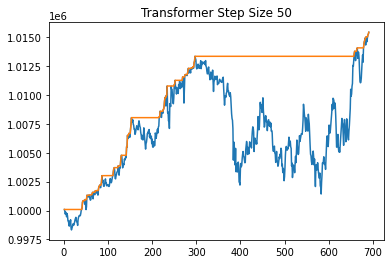

In [6]:
model = build_model(
    x_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]


try:
    with tf.device("/device:GPU:0"):
        model.fit(
            x_train,
            y_train,
            epochs=200,
            batch_size=64,
            callbacks=callbacks,
        )
except:
    model.fit(
        x_train,
        y_train,
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
    )

x, y = run_stepped_inc(
    model, x_test, y_test, step_size=50, epochs=5, batch_size=64, callbacks=callbacks
)
rets_agg["Transformer Step Size 50"], tf_rets50 = summ_and_plot(x, y, title="Transformer Step Size 50")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 26)]     0           []                               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 50, 26)      52          ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 50, 26)      109594      ['layer_normalization_16[0][0]', 
 eadAttention)                                                    'layer_normalization_16[0][0]'] 
                                                                                            

15/15 [==============================] - 14s 34ms/step - loss: 2411.9092
Epoch 2/200
15/15 [==============================] - ETA: 0s - loss: 2078.2920

15/15 [==============================] - 0s 28ms/step - loss: 2078.2920
Epoch 3/200
15/15 [==============================] - ETA: 0s - loss: 1770.0908

15/15 [==============================] - 0s 27ms/step - loss: 1770.0908
Epoch 4/200
15/15 [==============================] - ETA: 0s - loss: 1505.9037

15/15 [==============================] - 0s 28ms/step - loss: 1505.9037
Epoch 5/200
15/15 [==============================] - ETA: 0s - loss: 1411.0635

15/15 [==============================] - 0s 28ms/step - loss: 1411.0635
Epoch 6/200
15/15 [==============================] - ETA: 0s - loss: 1134.1530

15/15 [==============================] - 0s 29ms/step - loss: 1134.1530
Epoch 7/200
15/15 [==============================] - ETA: 0s - loss: 1041.5281

15/15 [==============================] - 0s 28ms/step - loss: 1041.5281
Epoch 8/200
15/15 [==============================] - ETA: 0s - loss: 835.2076

15/15 [==============================] - 0s 28ms/step - loss: 835.2076
Epoch 9/200
15/15 [==============================] - ETA: 0s - loss: 690.7390

15/15 [==============================] - 0s 27ms/step - loss: 690.7390
Epoch 10/200
15/15 [==============================] - ETA: 0s - loss: 631.1382

15/15 [==============================] - 0s 28ms/step - loss: 631.1382
Epoch 11/200
15/15 [==============================] - ETA: 0s - loss: 497.8648

15/15 [==============================] - 0s 28ms/step - loss: 497.8648
Epoch 12/200
15/15 [==============================] - ETA: 0s - loss: 444.7868

15/15 [==============================] - 0s 28ms/step - loss: 444.7868
Epoch 13/200
15/15 [==============================] - ETA: 0s - loss: 371.9929

15/15 [==============================] - 0s 28ms/step - loss: 371.9929
Epoch 14/200
15/15 [==============================] - ETA: 0s - loss: 313.4940

15/15 [==============================] - 0s 27ms/step - loss: 313.4940
Epoch 15/200
15/15 [==============================] - ETA: 0s - loss: 263.6137

15/15 [==============================] - 0s 28ms/step - loss: 263.6137
Epoch 16/200
15/15 [==============================] - ETA: 0s - loss: 227.5974

15/15 [==============================] - 0s 27ms/step - loss: 227.5974
Epoch 17/200
15/15 [==============================] - ETA: 0s - loss: 209.3829

15/15 [==============================] - 0s 28ms/step - loss: 209.3829
Epoch 18/200
15/15 [==============================] - ETA: 0s - loss: 155.4440

15/15 [==============================] - 0s 28ms/step - loss: 155.4440
Epoch 19/200
15/15 [==============================] - ETA: 0s - loss: 143.4889

15/15 [==============================] - 0s 27ms/step - loss: 143.4889
Epoch 20/200
15/15 [==============================] - ETA: 0s - loss: 118.8346

15/15 [==============================] - 0s 28ms/step - loss: 118.8346
Epoch 21/200
15/15 [==============================] - ETA: 0s - loss: 102.7981

15/15 [==============================] - 0s 28ms/step - loss: 102.7981
Epoch 22/200
15/15 [==============================] - ETA: 0s - loss: 88.8325

15/15 [==============================] - 0s 29ms/step - loss: 88.8325
Epoch 23/200
15/15 [==============================] - ETA: 0s - loss: 70.3943

15/15 [==============================] - 0s 29ms/step - loss: 70.3943
Epoch 24/200
15/15 [==============================] - ETA: 0s - loss: 67.0226

15/15 [==============================] - 0s 31ms/step - loss: 67.0226
Epoch 25/200
15/15 [==============================] - ETA: 0s - loss: 57.7077

15/15 [==============================] - 0s 31ms/step - loss: 57.7077
Epoch 26/200
15/15 [==============================] - ETA: 0s - loss: 49.2782

15/15 [==============================] - 0s 30ms/step - loss: 49.2782
Epoch 27/200
15/15 [==============================] - ETA: 0s - loss: 43.8667

15/15 [==============================] - 0s 31ms/step - loss: 43.8667
Epoch 28/200
15/15 [==============================] - ETA: 0s - loss: 36.5694

15/15 [==============================] - 0s 31ms/step - loss: 36.5694
Epoch 29/200
15/15 [==============================] - ETA: 0s - loss: 34.0945

15/15 [==============================] - 0s 31ms/step - loss: 34.0945
Epoch 30/200
15/15 [==============================] - ETA: 0s - loss: 28.9469

15/15 [==============================] - 0s 31ms/step - loss: 28.9469
Epoch 31/200
15/15 [==============================] - ETA: 0s - loss: 26.0106

15/15 [==============================] - 0s 32ms/step - loss: 26.0106
Epoch 32/200
15/15 [==============================] - ETA: 0s - loss: 24.3450

15/15 [==============================] - 0s 30ms/step - loss: 24.3450
Epoch 33/200
15/15 [==============================] - ETA: 0s - loss: 19.9759

15/15 [==============================] - 0s 28ms/step - loss: 19.9759
Epoch 34/200
15/15 [==============================] - ETA: 0s - loss: 18.9810

15/15 [==============================] - 0s 28ms/step - loss: 18.9810
Epoch 35/200
15/15 [==============================] - ETA: 0s - loss: 17.4512

15/15 [==============================] - 0s 28ms/step - loss: 17.4512
Epoch 36/200
15/15 [==============================] - ETA: 0s - loss: 16.5936

15/15 [==============================] - 0s 28ms/step - loss: 16.5936
Epoch 37/200
15/15 [==============================] - ETA: 0s - loss: 13.5875

15/15 [==============================] - 0s 28ms/step - loss: 13.5875
Epoch 38/200
15/15 [==============================] - ETA: 0s - loss: 12.3392

15/15 [==============================] - 0s 28ms/step - loss: 12.3392
Epoch 39/200
15/15 [==============================] - ETA: 0s - loss: 12.6347

15/15 [==============================] - 0s 28ms/step - loss: 12.6347
Epoch 40/200
15/15 [==============================] - ETA: 0s - loss: 11.6775

15/15 [==============================] - 0s 28ms/step - loss: 11.6775
Epoch 41/200
15/15 [==============================] - ETA: 0s - loss: 10.7900

15/15 [==============================] - 0s 29ms/step - loss: 10.7900
Epoch 42/200
15/15 [==============================] - ETA: 0s - loss: 11.4168

15/15 [==============================] - 0s 28ms/step - loss: 11.4168
Epoch 43/200
15/15 [==============================] - ETA: 0s - loss: 11.3742

15/15 [==============================] - 0s 28ms/step - loss: 11.3742
Epoch 44/200
15/15 [==============================] - ETA: 0s - loss: 10.3690

15/15 [==============================] - 0s 28ms/step - loss: 10.3690
Epoch 45/200
15/15 [==============================] - ETA: 0s - loss: 10.0492

15/15 [==============================] - 0s 28ms/step - loss: 10.0492
Epoch 46/200
15/15 [==============================] - ETA: 0s - loss: 11.1273

15/15 [==============================] - 0s 29ms/step - loss: 11.1273
Epoch 47/200
15/15 [==============================] - ETA: 0s - loss: 9.5774

15/15 [==============================] - 0s 27ms/step - loss: 9.5774
Epoch 48/200
15/15 [==============================] - ETA: 0s - loss: 10.5961

15/15 [==============================] - 0s 28ms/step - loss: 10.5961
Epoch 49/200
15/15 [==============================] - ETA: 0s - loss: 10.8636

15/15 [==============================] - 0s 28ms/step - loss: 10.8636
Epoch 50/200
15/15 [==============================] - ETA: 0s - loss: 10.3364

15/15 [==============================] - 0s 29ms/step - loss: 10.3364
Epoch 51/200
15/15 [==============================] - ETA: 0s - loss: 8.8388

15/15 [==============================] - 0s 29ms/step - loss: 8.8388
Epoch 52/200
15/15 [==============================] - ETA: 0s - loss: 8.5803

15/15 [==============================] - 0s 28ms/step - loss: 8.5803
Epoch 53/200
15/15 [==============================] - ETA: 0s - loss: 10.5818

15/15 [==============================] - 0s 28ms/step - loss: 10.5818
Epoch 54/200
15/15 [==============================] - ETA: 0s - loss: 9.1388

15/15 [==============================] - 0s 28ms/step - loss: 9.1388
Epoch 55/200
15/15 [==============================] - ETA: 0s - loss: 9.6090

15/15 [==============================] - 0s 29ms/step - loss: 9.6090
Epoch 56/200
15/15 [==============================] - ETA: 0s - loss: 10.2347

15/15 [==============================] - 0s 31ms/step - loss: 10.2347
Epoch 57/200
15/15 [==============================] - ETA: 0s - loss: 8.6478

15/15 [==============================] - 0s 30ms/step - loss: 8.6478
Epoch 58/200
15/15 [==============================] - ETA: 0s - loss: 9.3955

15/15 [==============================] - 0s 30ms/step - loss: 9.3955
Epoch 59/200
15/15 [==============================] - ETA: 0s - loss: 8.8119

15/15 [==============================] - 0s 31ms/step - loss: 8.8119
Epoch 60/200
15/15 [==============================] - ETA: 0s - loss: 8.7069

15/15 [==============================] - 0s 32ms/step - loss: 8.7069
Epoch 61/200
15/15 [==============================] - ETA: 0s - loss: 8.0021

15/15 [==============================] - 0s 31ms/step - loss: 8.0021
Epoch 62/200
15/15 [==============================] - ETA: 0s - loss: 8.6702

15/15 [==============================] - 0s 30ms/step - loss: 8.6702
Epoch 63/200
15/15 [==============================] - ETA: 0s - loss: 8.3363

15/15 [==============================] - 0s 31ms/step - loss: 8.3363
Epoch 64/200
15/15 [==============================] - ETA: 0s - loss: 8.2809

15/15 [==============================] - 0s 30ms/step - loss: 8.2809
Epoch 65/200
15/15 [==============================] - ETA: 0s - loss: 8.5467

15/15 [==============================] - 0s 29ms/step - loss: 8.5467
Epoch 66/200
15/15 [==============================] - ETA: 0s - loss: 8.1067

15/15 [==============================] - 0s 28ms/step - loss: 8.1067
Epoch 67/200
15/15 [==============================] - ETA: 0s - loss: 8.3797

15/15 [==============================] - 0s 29ms/step - loss: 8.3797
Epoch 68/200
15/15 [==============================] - ETA: 0s - loss: 8.2663

15/15 [==============================] - 0s 29ms/step - loss: 8.2663
Epoch 69/200
15/15 [==============================] - ETA: 0s - loss: 7.6872

15/15 [==============================] - 0s 28ms/step - loss: 7.6872
Epoch 70/200
15/15 [==============================] - ETA: 0s - loss: 7.6724

15/15 [==============================] - 0s 29ms/step - loss: 7.6724
Epoch 71/200
15/15 [==============================] - ETA: 0s - loss: 8.0116

15/15 [==============================] - 0s 29ms/step - loss: 8.0116
Epoch 72/200
15/15 [==============================] - ETA: 0s - loss: 8.4993

15/15 [==============================] - 0s 30ms/step - loss: 8.4993
Epoch 73/200
15/15 [==============================] - ETA: 0s - loss: 7.6089

15/15 [==============================] - 0s 29ms/step - loss: 7.6089
Epoch 74/200
15/15 [==============================] - ETA: 0s - loss: 8.2598

15/15 [==============================] - 0s 29ms/step - loss: 8.2598
Epoch 75/200
15/15 [==============================] - ETA: 0s - loss: 7.9901

15/15 [==============================] - 0s 28ms/step - loss: 7.9901
Epoch 76/200
15/15 [==============================] - ETA: 0s - loss: 7.2057

15/15 [==============================] - 0s 29ms/step - loss: 7.2057
Epoch 77/200
15/15 [==============================] - ETA: 0s - loss: 7.9194

15/15 [==============================] - 0s 29ms/step - loss: 7.9194
Epoch 78/200
15/15 [==============================] - ETA: 0s - loss: 7.1522

15/15 [==============================] - 0s 29ms/step - loss: 7.1522
Epoch 79/200
15/15 [==============================] - ETA: 0s - loss: 8.3254

15/15 [==============================] - 0s 29ms/step - loss: 8.3254
Epoch 80/200
15/15 [==============================] - ETA: 0s - loss: 7.8502

15/15 [==============================] - 0s 28ms/step - loss: 7.8502
Epoch 81/200
15/15 [==============================] - ETA: 0s - loss: 7.2589

15/15 [==============================] - 0s 29ms/step - loss: 7.2589
Epoch 82/200
15/15 [==============================] - ETA: 0s - loss: 7.8609

15/15 [==============================] - 0s 28ms/step - loss: 7.8609
Epoch 83/200
15/15 [==============================] - ETA: 0s - loss: 7.0636

15/15 [==============================] - 0s 29ms/step - loss: 7.0636
Epoch 84/200
15/15 [==============================] - ETA: 0s - loss: 7.6300

15/15 [==============================] - 0s 28ms/step - loss: 7.6300
Epoch 85/200
15/15 [==============================] - ETA: 0s - loss: 7.4273

15/15 [==============================] - 0s 28ms/step - loss: 7.4273
Epoch 86/200
15/15 [==============================] - ETA: 0s - loss: 6.8900

15/15 [==============================] - 0s 29ms/step - loss: 6.8900
Epoch 87/200
15/15 [==============================] - ETA: 0s - loss: 7.0768

15/15 [==============================] - 0s 31ms/step - loss: 7.0768
Epoch 88/200
15/15 [==============================] - ETA: 0s - loss: 7.4851

15/15 [==============================] - 1s 33ms/step - loss: 7.4851
Epoch 89/200
15/15 [==============================] - ETA: 0s - loss: 7.1730

15/15 [==============================] - 0s 30ms/step - loss: 7.1730
Epoch 90/200
15/15 [==============================] - ETA: 0s - loss: 7.4870

15/15 [==============================] - 0s 31ms/step - loss: 7.4870
Epoch 91/200
15/15 [==============================] - ETA: 0s - loss: 7.5747

15/15 [==============================] - 0s 32ms/step - loss: 7.5747
Epoch 92/200
15/15 [==============================] - ETA: 0s - loss: 6.5496

15/15 [==============================] - 0s 32ms/step - loss: 6.5496
Epoch 93/200
15/15 [==============================] - ETA: 0s - loss: 7.2043

15/15 [==============================] - 0s 31ms/step - loss: 7.2043
Epoch 94/200
15/15 [==============================] - ETA: 0s - loss: 7.0858

15/15 [==============================] - 0s 30ms/step - loss: 7.0858
Epoch 95/200
15/15 [==============================] - ETA: 0s - loss: 6.9596

15/15 [==============================] - 0s 32ms/step - loss: 6.9596
Epoch 96/200
15/15 [==============================] - ETA: 0s - loss: 7.0951

15/15 [==============================] - 0s 29ms/step - loss: 7.0951
Epoch 97/200
15/15 [==============================] - ETA: 0s - loss: 6.6463

15/15 [==============================] - 0s 29ms/step - loss: 6.6463
Epoch 98/200
15/15 [==============================] - ETA: 0s - loss: 6.8526

15/15 [==============================] - 0s 29ms/step - loss: 6.8526
Epoch 99/200
15/15 [==============================] - ETA: 0s - loss: 7.0791

15/15 [==============================] - 0s 28ms/step - loss: 7.0791
Epoch 100/200
15/15 [==============================] - ETA: 0s - loss: 7.1105

15/15 [==============================] - 0s 28ms/step - loss: 7.1105
Epoch 101/200
15/15 [==============================] - ETA: 0s - loss: 6.3885

15/15 [==============================] - 0s 29ms/step - loss: 6.3885
Epoch 102/200
15/15 [==============================] - ETA: 0s - loss: 6.5396

15/15 [==============================] - 0s 29ms/step - loss: 6.5396
Epoch 103/200
15/15 [==============================] - ETA: 0s - loss: 7.2137

15/15 [==============================] - 0s 29ms/step - loss: 7.2137
Epoch 104/200
15/15 [==============================] - ETA: 0s - loss: 6.4420

15/15 [==============================] - 0s 28ms/step - loss: 6.4420
Epoch 105/200
15/15 [==============================] - ETA: 0s - loss: 6.7268

15/15 [==============================] - 0s 28ms/step - loss: 6.7268
Epoch 106/200
15/15 [==============================] - ETA: 0s - loss: 6.8340

15/15 [==============================] - 0s 29ms/step - loss: 6.8340
Epoch 107/200
15/15 [==============================] - ETA: 0s - loss: 6.8708

15/15 [==============================] - 0s 29ms/step - loss: 6.8708
Epoch 108/200
15/15 [==============================] - ETA: 0s - loss: 6.6488

15/15 [==============================] - 0s 29ms/step - loss: 6.6488
Epoch 109/200
15/15 [==============================] - ETA: 0s - loss: 7.2764

15/15 [==============================] - 0s 28ms/step - loss: 7.2764
Epoch 110/200
15/15 [==============================] - ETA: 0s - loss: 6.6324

15/15 [==============================] - 0s 28ms/step - loss: 6.6324
Epoch 111/200
15/15 [==============================] - ETA: 0s - loss: 6.9199

15/15 [==============================] - 0s 29ms/step - loss: 6.9199
Epoch 112/200
15/15 [==============================] - ETA: 0s - loss: 6.6454

15/15 [==============================] - 0s 29ms/step - loss: 6.6454
Epoch 113/200
15/15 [==============================] - ETA: 0s - loss: 6.4461

15/15 [==============================] - 0s 29ms/step - loss: 6.4461
Epoch 114/200
15/15 [==============================] - ETA: 0s - loss: 6.0006

15/15 [==============================] - 0s 28ms/step - loss: 6.0006
Epoch 115/200
15/15 [==============================] - ETA: 0s - loss: 6.5869

15/15 [==============================] - 0s 28ms/step - loss: 6.5869
Epoch 116/200
15/15 [==============================] - ETA: 0s - loss: 6.4405

15/15 [==============================] - 0s 29ms/step - loss: 6.4405
Epoch 117/200
15/15 [==============================] - ETA: 0s - loss: 6.4760

15/15 [==============================] - 0s 28ms/step - loss: 6.4760
Epoch 118/200
15/15 [==============================] - ETA: 0s - loss: 6.6333

15/15 [==============================] - 0s 30ms/step - loss: 6.6333
Epoch 119/200
15/15 [==============================] - ETA: 0s - loss: 6.4249

15/15 [==============================] - 0s 30ms/step - loss: 6.4249
Epoch 120/200
15/15 [==============================] - ETA: 0s - loss: 6.1967

15/15 [==============================] - 0s 30ms/step - loss: 6.1967
Epoch 121/200
15/15 [==============================] - ETA: 0s - loss: 6.5979

15/15 [==============================] - 0s 29ms/step - loss: 6.5979
Epoch 122/200
15/15 [==============================] - ETA: 0s - loss: 5.7283

15/15 [==============================] - 0s 30ms/step - loss: 5.7283
Epoch 123/200
15/15 [==============================] - ETA: 0s - loss: 5.9163

15/15 [==============================] - 0s 30ms/step - loss: 5.9163
Epoch 124/200
15/15 [==============================] - ETA: 0s - loss: 6.5971

15/15 [==============================] - 0s 29ms/step - loss: 6.5971
Epoch 125/200
15/15 [==============================] - ETA: 0s - loss: 6.4012

15/15 [==============================] - 0s 32ms/step - loss: 6.4012
Epoch 126/200
15/15 [==============================] - ETA: 0s - loss: 6.6356

15/15 [==============================] - 0s 31ms/step - loss: 6.6356
Epoch 127/200
15/15 [==============================] - ETA: 0s - loss: 6.4896

15/15 [==============================] - 0s 31ms/step - loss: 6.4896
Epoch 128/200
15/15 [==============================] - ETA: 0s - loss: 6.5755

15/15 [==============================] - 0s 31ms/step - loss: 6.5755
Epoch 129/200
15/15 [==============================] - ETA: 0s - loss: 7.0300

15/15 [==============================] - 0s 28ms/step - loss: 7.0300
Epoch 130/200
15/15 [==============================] - ETA: 0s - loss: 6.4996

15/15 [==============================] - 0s 28ms/step - loss: 6.4996
Epoch 131/200
15/15 [==============================] - ETA: 0s - loss: 6.0842

15/15 [==============================] - 0s 28ms/step - loss: 6.0842
Epoch 132/200
15/15 [==============================] - ETA: 0s - loss: 5.8109

15/15 [==============================] - 0s 29ms/step - loss: 5.8109
Epoch 133/200
15/15 [==============================] - ETA: 0s - loss: 6.2070

15/15 [==============================] - 0s 28ms/step - loss: 6.2070
Epoch 134/200
15/15 [==============================] - ETA: 0s - loss: 5.7398

15/15 [==============================] - 0s 29ms/step - loss: 5.7398
Epoch 135/200
15/15 [==============================] - ETA: 0s - loss: 5.9808

15/15 [==============================] - 0s 29ms/step - loss: 5.9808
Epoch 136/200
15/15 [==============================] - ETA: 0s - loss: 6.1590

15/15 [==============================] - 0s 29ms/step - loss: 6.1590
Epoch 137/200
15/15 [==============================] - ETA: 0s - loss: 6.4321

15/15 [==============================] - 0s 29ms/step - loss: 6.4321
Epoch 138/200
15/15 [==============================] - ETA: 0s - loss: 6.3623

15/15 [==============================] - 0s 29ms/step - loss: 6.3623
Epoch 139/200
15/15 [==============================] - ETA: 0s - loss: 6.2622

15/15 [==============================] - 0s 28ms/step - loss: 6.2622
Epoch 140/200
15/15 [==============================] - ETA: 0s - loss: 5.9317

15/15 [==============================] - 0s 30ms/step - loss: 5.9317
Epoch 141/200
15/15 [==============================] - ETA: 0s - loss: 6.1109

15/15 [==============================] - 0s 29ms/step - loss: 6.1109
Epoch 142/200
15/15 [==============================] - ETA: 0s - loss: 5.6400

15/15 [==============================] - 0s 29ms/step - loss: 5.6400
Epoch 143/200
15/15 [==============================] - ETA: 0s - loss: 5.9519

15/15 [==============================] - 0s 29ms/step - loss: 5.9519
Epoch 144/200
15/15 [==============================] - ETA: 0s - loss: 5.9121

15/15 [==============================] - 0s 28ms/step - loss: 5.9121
Epoch 145/200
15/15 [==============================] - ETA: 0s - loss: 5.8401

15/15 [==============================] - 0s 28ms/step - loss: 5.8401
Epoch 146/200
15/15 [==============================] - ETA: 0s - loss: 5.5482

15/15 [==============================] - 0s 29ms/step - loss: 5.5482
Epoch 147/200
15/15 [==============================] - ETA: 0s - loss: 5.4040

15/15 [==============================] - 0s 29ms/step - loss: 5.4040
Epoch 148/200
15/15 [==============================] - ETA: 0s - loss: 5.5061

15/15 [==============================] - 0s 29ms/step - loss: 5.5061
Epoch 149/200
15/15 [==============================] - ETA: 0s - loss: 5.6030

15/15 [==============================] - 0s 29ms/step - loss: 5.6030
Epoch 150/200
15/15 [==============================] - ETA: 0s - loss: 5.5359

15/15 [==============================] - 0s 28ms/step - loss: 5.5359
Epoch 151/200
15/15 [==============================] - ETA: 0s - loss: 5.3523

15/15 [==============================] - 0s 32ms/step - loss: 5.3523
Epoch 152/200
15/15 [==============================] - ETA: 0s - loss: 6.0189

15/15 [==============================] - 0s 31ms/step - loss: 6.0189
Epoch 153/200
15/15 [==============================] - ETA: 0s - loss: 5.6008

15/15 [==============================] - 0s 30ms/step - loss: 5.6008
Epoch 154/200
15/15 [==============================] - ETA: 0s - loss: 5.7566

15/15 [==============================] - 0s 30ms/step - loss: 5.7566
Epoch 155/200
15/15 [==============================] - ETA: 0s - loss: 5.7039

15/15 [==============================] - 0s 33ms/step - loss: 5.7039
Epoch 156/200
15/15 [==============================] - ETA: 0s - loss: 5.2305

15/15 [==============================] - 0s 30ms/step - loss: 5.2305
Epoch 157/200
15/15 [==============================] - ETA: 0s - loss: 5.6599

15/15 [==============================] - 0s 30ms/step - loss: 5.6599
Epoch 158/200
15/15 [==============================] - ETA: 0s - loss: 5.6004

15/15 [==============================] - 0s 29ms/step - loss: 5.6004
Epoch 159/200
15/15 [==============================] - ETA: 0s - loss: 5.5181

15/15 [==============================] - 0s 32ms/step - loss: 5.5181
Epoch 160/200
15/15 [==============================] - ETA: 0s - loss: 5.5282

15/15 [==============================] - 0s 31ms/step - loss: 5.5282
Epoch 161/200
15/15 [==============================] - ETA: 0s - loss: 5.7930

15/15 [==============================] - 0s 29ms/step - loss: 5.7930
Epoch 162/200
15/15 [==============================] - ETA: 0s - loss: 5.4353

15/15 [==============================] - 0s 29ms/step - loss: 5.4353
Epoch 163/200
15/15 [==============================] - ETA: 0s - loss: 5.3271

15/15 [==============================] - 0s 28ms/step - loss: 5.3271
Epoch 164/200
15/15 [==============================] - ETA: 0s - loss: 5.4471

15/15 [==============================] - 0s 30ms/step - loss: 5.4471
Epoch 165/200
15/15 [==============================] - ETA: 0s - loss: 5.4362

15/15 [==============================] - 0s 28ms/step - loss: 5.4362
Epoch 166/200
15/15 [==============================] - ETA: 0s - loss: 5.7438

15/15 [==============================] - 0s 28ms/step - loss: 5.7438
Epoch 167/200
15/15 [==============================] - ETA: 0s - loss: 5.5590

15/15 [==============================] - 0s 29ms/step - loss: 5.5590
Epoch 168/200
15/15 [==============================] - ETA: 0s - loss: 5.3391

15/15 [==============================] - 0s 28ms/step - loss: 5.3391
Epoch 169/200
15/15 [==============================] - ETA: 0s - loss: 5.2036

15/15 [==============================] - 0s 29ms/step - loss: 5.2036
Epoch 170/200
15/15 [==============================] - ETA: 0s - loss: 5.1118

15/15 [==============================] - 0s 28ms/step - loss: 5.1118
Epoch 171/200
15/15 [==============================] - ETA: 0s - loss: 4.9792

15/15 [==============================] - 0s 29ms/step - loss: 4.9792
Epoch 172/200
15/15 [==============================] - ETA: 0s - loss: 5.3101

15/15 [==============================] - 0s 29ms/step - loss: 5.3101
Epoch 173/200
15/15 [==============================] - ETA: 0s - loss: 5.2148

15/15 [==============================] - 0s 30ms/step - loss: 5.2148
Epoch 174/200
15/15 [==============================] - ETA: 0s - loss: 5.0455

15/15 [==============================] - 0s 29ms/step - loss: 5.0455
Epoch 175/200
15/15 [==============================] - ETA: 0s - loss: 5.3110

15/15 [==============================] - 0s 29ms/step - loss: 5.3110
Epoch 176/200
15/15 [==============================] - ETA: 0s - loss: 5.6801

15/15 [==============================] - 0s 29ms/step - loss: 5.6801
Epoch 177/200
15/15 [==============================] - ETA: 0s - loss: 5.1028

15/15 [==============================] - 0s 28ms/step - loss: 5.1028
Epoch 178/200
15/15 [==============================] - ETA: 0s - loss: 4.9346

15/15 [==============================] - 0s 28ms/step - loss: 4.9346
Epoch 179/200
15/15 [==============================] - ETA: 0s - loss: 4.8499

15/15 [==============================] - 0s 28ms/step - loss: 4.8499
Epoch 180/200
15/15 [==============================] - ETA: 0s - loss: 5.4437

15/15 [==============================] - 0s 29ms/step - loss: 5.4437
Epoch 181/200
15/15 [==============================] - ETA: 0s - loss: 5.4231

15/15 [==============================] - 0s 29ms/step - loss: 5.4231
Epoch 182/200
15/15 [==============================] - ETA: 0s - loss: 5.5273

15/15 [==============================] - 0s 29ms/step - loss: 5.5273
Epoch 183/200
15/15 [==============================] - ETA: 0s - loss: 4.8385

15/15 [==============================] - 0s 31ms/step - loss: 4.8385
Epoch 184/200
15/15 [==============================] - ETA: 0s - loss: 5.1386

15/15 [==============================] - 0s 31ms/step - loss: 5.1386
Epoch 185/200
15/15 [==============================] - ETA: 0s - loss: 4.9810

15/15 [==============================] - 0s 31ms/step - loss: 4.9810
Epoch 186/200
15/15 [==============================] - ETA: 0s - loss: 5.4148

15/15 [==============================] - 0s 30ms/step - loss: 5.4148
Epoch 187/200
15/15 [==============================] - ETA: 0s - loss: 5.0065

15/15 [==============================] - 0s 30ms/step - loss: 5.0065
Epoch 188/200
15/15 [==============================] - ETA: 0s - loss: 4.8452

15/15 [==============================] - 0s 32ms/step - loss: 4.8452
Epoch 189/200
15/15 [==============================] - ETA: 0s - loss: 5.4263

15/15 [==============================] - 0s 32ms/step - loss: 5.4263
Epoch 190/200
15/15 [==============================] - ETA: 0s - loss: 4.8281

15/15 [==============================] - 0s 31ms/step - loss: 4.8281
Epoch 191/200
15/15 [==============================] - ETA: 0s - loss: 5.0037

15/15 [==============================] - 0s 31ms/step - loss: 5.0037
Epoch 192/200
15/15 [==============================] - ETA: 0s - loss: 4.9163

15/15 [==============================] - 0s 31ms/step - loss: 4.9163
Epoch 193/200
15/15 [==============================] - ETA: 0s - loss: 5.3650

15/15 [==============================] - 0s 29ms/step - loss: 5.3650
Epoch 194/200
15/15 [==============================] - ETA: 0s - loss: 5.0185

15/15 [==============================] - 0s 29ms/step - loss: 5.0185
Epoch 195/200
15/15 [==============================] - ETA: 0s - loss: 5.1764

15/15 [==============================] - 0s 29ms/step - loss: 5.1764
Epoch 196/200
15/15 [==============================] - ETA: 0s - loss: 5.2069

15/15 [==============================] - 0s 29ms/step - loss: 5.2069
Epoch 197/200
15/15 [==============================] - ETA: 0s - loss: 4.7957

15/15 [==============================] - 0s 28ms/step - loss: 4.7957
Epoch 198/200
15/15 [==============================] - ETA: 0s - loss: 5.1134

15/15 [==============================] - 0s 29ms/step - loss: 5.1134
Epoch 199/200
15/15 [==============================] - ETA: 0s - loss: 5.0242

15/15 [==============================] - 0s 29ms/step - loss: 5.0242
Epoch 200/200
15/15 [==============================] - ETA: 0s - loss: 5.0102

15/15 [==============================] - 0s 29ms/step - loss: 5.0102


  0%|          | 0/70 [00:00<?, ?it/s]

4/4 [==============================] - 0s 12ms/step
Epoch 1/5
2/2 [==============================] - ETA: 0s - loss: 4.5208

2/2 [==============================] - 0s 75ms/step - loss: 4.5208
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5781

2/2 [==============================] - 0s 28ms/step - loss: 3.8083
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0040

2/2 [==============================] - 0s 26ms/step - loss: 4.8493
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8162

2/2 [==============================] - 0s 26ms/step - loss: 5.2358
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8218

2/2 [==============================] - 0s 28ms/step - loss: 5.7193


  1%|▏         | 1/70 [00:00<01:03,  1.08it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1593

2/2 [==============================] - 0s 28ms/step - loss: 3.9312
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3863

2/2 [==============================] - 0s 40ms/step - loss: 5.1052
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1013

2/2 [==============================] - 0s 26ms/step - loss: 4.9050
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7117

2/2 [==============================] - 0s 28ms/step - loss: 4.6275
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 6.3384

2/2 [==============================] - 0s 31ms/step - loss: 5.9157


  3%|▎         | 2/70 [00:01<00:58,  1.17it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5416

2/2 [==============================] - 0s 31ms/step - loss: 4.6750
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.9893

2/2 [==============================] - 0s 28ms/step - loss: 6.4632
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.6489

2/2 [==============================] - 0s 28ms/step - loss: 5.4237
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 6.7137

2/2 [==============================] - 0s 25ms/step - loss: 5.9944
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5692

2/2 [==============================] - 0s 29ms/step - loss: 4.3091


  4%|▍         | 3/70 [00:02<00:54,  1.22it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7136

2/2 [==============================] - 0s 27ms/step - loss: 6.0814
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0439

2/2 [==============================] - 0s 29ms/step - loss: 4.3966
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8378

2/2 [==============================] - 0s 27ms/step - loss: 5.1460
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.9710

2/2 [==============================] - 0s 26ms/step - loss: 5.5822
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3456

2/2 [==============================] - 0s 30ms/step - loss: 5.2766


  6%|▌         | 4/70 [00:03<00:52,  1.25it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7774

2/2 [==============================] - 0s 30ms/step - loss: 3.7048
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7170

2/2 [==============================] - 0s 26ms/step - loss: 4.7122
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1336

2/2 [==============================] - 0s 30ms/step - loss: 4.6067
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 6.5653

2/2 [==============================] - 0s 35ms/step - loss: 5.6884
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 6.2056

2/2 [==============================] - 0s 27ms/step - loss: 5.3011


  7%|▋         | 5/70 [00:04<00:51,  1.26it/s]

4/4 [==============================] - 0s 6ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5400

2/2 [==============================] - 0s 42ms/step - loss: 4.2131
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3481

2/2 [==============================] - 0s 30ms/step - loss: 5.2996
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8441

2/2 [==============================] - 0s 25ms/step - loss: 4.2131
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4374

2/2 [==============================] - 0s 25ms/step - loss: 5.0621
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7704

2/2 [==============================] - 0s 28ms/step - loss: 4.6955


  9%|▊         | 6/70 [00:04<00:44,  1.44it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1029

2/2 [==============================] - 0s 31ms/step - loss: 5.0679
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 7.0192

2/2 [==============================] - 0s 25ms/step - loss: 5.9771
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1675

2/2 [==============================] - 0s 28ms/step - loss: 4.4988
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5461

2/2 [==============================] - 0s 29ms/step - loss: 5.6676
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6753

2/2 [==============================] - 0s 30ms/step - loss: 4.7516


 10%|█         | 7/70 [00:05<00:45,  1.39it/s]

4/4 [==============================] - 0s 6ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6350

2/2 [==============================] - 0s 26ms/step - loss: 4.5791
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2523

2/2 [==============================] - 0s 27ms/step - loss: 3.7617
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.6064

2/2 [==============================] - 0s 28ms/step - loss: 5.6297
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 6.6590

2/2 [==============================] - 0s 37ms/step - loss: 5.8146
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3856

2/2 [==============================] - 0s 31ms/step - loss: 3.9742


 11%|█▏        | 8/70 [00:06<00:45,  1.35it/s]

4/4 [==============================] - 0s 6ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.3815

2/2 [==============================] - 0s 29ms/step - loss: 3.2464
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0161

2/2 [==============================] - 0s 41ms/step - loss: 5.2301
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6206

2/2 [==============================] - 0s 42ms/step - loss: 4.2574
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 6.1650

2/2 [==============================] - 0s 45ms/step - loss: 5.8077
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3350

2/2 [==============================] - 0s 37ms/step - loss: 5.2167


 13%|█▎        | 9/70 [00:06<00:46,  1.32it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0184

2/2 [==============================] - 0s 32ms/step - loss: 3.7298
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 6.4001

2/2 [==============================] - 0s 32ms/step - loss: 5.5679
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4904

2/2 [==============================] - 0s 36ms/step - loss: 5.2062
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 6.4417

2/2 [==============================] - 0s 36ms/step - loss: 6.0343
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 7.4331

2/2 [==============================] - 0s 34ms/step - loss: 6.8392


 14%|█▍        | 10/70 [00:07<00:47,  1.28it/s]

4/4 [==============================] - 0s 9ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0110

2/2 [==============================] - 0s 40ms/step - loss: 3.9350
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3030

2/2 [==============================] - 0s 36ms/step - loss: 5.6315
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1685

2/2 [==============================] - 0s 35ms/step - loss: 4.9031
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9713

2/2 [==============================] - 0s 36ms/step - loss: 5.2524
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4977

2/2 [==============================] - 0s 36ms/step - loss: 4.7643


 16%|█▌        | 11/70 [00:08<00:43,  1.36it/s]

4/4 [==============================] - 0s 9ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7930

2/2 [==============================] - 0s 45ms/step - loss: 6.1294
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7506

2/2 [==============================] - 0s 45ms/step - loss: 5.2553
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1970

2/2 [==============================] - 0s 37ms/step - loss: 4.2658
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 6.0282

2/2 [==============================] - 0s 32ms/step - loss: 5.1768
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8371

2/2 [==============================] - 0s 34ms/step - loss: 5.1578


 17%|█▋        | 12/70 [00:09<00:40,  1.42it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7730

2/2 [==============================] - 0s 33ms/step - loss: 4.5758
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6792

2/2 [==============================] - 0s 31ms/step - loss: 5.6496
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1505

2/2 [==============================] - 0s 39ms/step - loss: 4.0188
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.6162

2/2 [==============================] - 0s 34ms/step - loss: 5.3533
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2221

2/2 [==============================] - 0s 37ms/step - loss: 4.6310


 19%|█▊        | 13/70 [00:09<00:42,  1.34it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5193

2/2 [==============================] - 0s 54ms/step - loss: 3.9111
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2255

2/2 [==============================] - 0s 26ms/step - loss: 4.8987
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.9090

2/2 [==============================] - 0s 26ms/step - loss: 5.8932
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1721

2/2 [==============================] - 0s 27ms/step - loss: 4.2423
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5581

2/2 [==============================] - 0s 25ms/step - loss: 5.1750


 20%|██        | 14/70 [00:10<00:43,  1.29it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2602

2/2 [==============================] - 0s 28ms/step - loss: 4.6642
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0876

2/2 [==============================] - 0s 29ms/step - loss: 5.7559
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2840

2/2 [==============================] - 0s 28ms/step - loss: 4.2286
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2799

2/2 [==============================] - 0s 27ms/step - loss: 4.5757
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6924

2/2 [==============================] - 0s 29ms/step - loss: 4.3373


 21%|██▏       | 15/70 [00:11<00:43,  1.28it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6079

2/2 [==============================] - 0s 33ms/step - loss: 4.6162
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2260

2/2 [==============================] - 0s 32ms/step - loss: 4.3580
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2935

2/2 [==============================] - 0s 26ms/step - loss: 3.5315
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5488

2/2 [==============================] - 0s 29ms/step - loss: 4.1219
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5889

2/2 [==============================] - 0s 31ms/step - loss: 4.4870


 23%|██▎       | 16/70 [00:12<00:37,  1.43it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4490

2/2 [==============================] - 0s 26ms/step - loss: 5.2691
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2210

2/2 [==============================] - 0s 27ms/step - loss: 4.6582
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3715

2/2 [==============================] - 0s 35ms/step - loss: 5.6036
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2579

2/2 [==============================] - 0s 32ms/step - loss: 5.2257
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8191

2/2 [==============================] - 0s 33ms/step - loss: 3.5186


 24%|██▍       | 17/70 [00:12<00:38,  1.36it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5558

2/2 [==============================] - 0s 32ms/step - loss: 4.9385
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5595

2/2 [==============================] - 0s 29ms/step - loss: 4.5986
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2037

2/2 [==============================] - 0s 24ms/step - loss: 4.9734
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1935

2/2 [==============================] - 0s 27ms/step - loss: 4.1668
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4128

2/2 [==============================] - 0s 25ms/step - loss: 4.8592


 26%|██▌       | 18/70 [00:13<00:34,  1.49it/s]

4/4 [==============================] - 0s 6ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 6.0264

2/2 [==============================] - 0s 38ms/step - loss: 5.0535
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1791

2/2 [==============================] - 0s 28ms/step - loss: 4.8426
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4236

2/2 [==============================] - 0s 27ms/step - loss: 4.8193
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5536

2/2 [==============================] - 0s 28ms/step - loss: 3.8993
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 6.4183

2/2 [==============================] - 0s 26ms/step - loss: 6.4125


 27%|██▋       | 19/70 [00:14<00:36,  1.41it/s]

4/4 [==============================] - 0s 9ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4865

2/2 [==============================] - 0s 34ms/step - loss: 5.7259
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3859

2/2 [==============================] - 0s 35ms/step - loss: 4.5784
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3902

2/2 [==============================] - 0s 32ms/step - loss: 5.7843
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6187

2/2 [==============================] - 0s 35ms/step - loss: 4.4944
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.9388

2/2 [==============================] - 0s 28ms/step - loss: 5.8054


 29%|██▊       | 20/70 [00:14<00:36,  1.36it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2746

2/2 [==============================] - 0s 29ms/step - loss: 5.1158
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4848

2/2 [==============================] - 0s 29ms/step - loss: 4.9146
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0986

2/2 [==============================] - 0s 25ms/step - loss: 5.1598
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5789

2/2 [==============================] - 0s 27ms/step - loss: 4.4285
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5731

2/2 [==============================] - 0s 26ms/step - loss: 4.4861


 30%|███       | 21/70 [00:15<00:32,  1.51it/s]

4/4 [==============================] - 0s 6ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 6.0562

2/2 [==============================] - 0s 30ms/step - loss: 5.9141
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.9424

2/2 [==============================] - 0s 31ms/step - loss: 5.0569
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2828

2/2 [==============================] - 0s 36ms/step - loss: 4.3435
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4989

2/2 [==============================] - 0s 28ms/step - loss: 4.3372
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1557

2/2 [==============================] - 0s 28ms/step - loss: 5.2667


 31%|███▏      | 22/70 [00:15<00:30,  1.60it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8655

2/2 [==============================] - 0s 29ms/step - loss: 5.2302
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9909

2/2 [==============================] - 0s 26ms/step - loss: 4.4259
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9075

2/2 [==============================] - 0s 27ms/step - loss: 5.1375
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9780

2/2 [==============================] - 0s 26ms/step - loss: 4.0254
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3350

2/2 [==============================] - 0s 29ms/step - loss: 4.0182


 33%|███▎      | 23/70 [00:16<00:31,  1.49it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6614

2/2 [==============================] - 0s 34ms/step - loss: 5.7537
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0718

2/2 [==============================] - 0s 27ms/step - loss: 4.3518
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.3822

2/2 [==============================] - 0s 25ms/step - loss: 3.6015
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7293

2/2 [==============================] - 0s 25ms/step - loss: 4.5963
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9004

2/2 [==============================] - 0s 35ms/step - loss: 4.3541


 34%|███▍      | 24/70 [00:17<00:28,  1.62it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7006

2/2 [==============================] - 0s 35ms/step - loss: 4.0329
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6361

2/2 [==============================] - 0s 31ms/step - loss: 4.1152
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1078

2/2 [==============================] - 0s 30ms/step - loss: 4.2300
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5484

2/2 [==============================] - 0s 29ms/step - loss: 5.2637
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4581

2/2 [==============================] - 0s 27ms/step - loss: 5.0446


 36%|███▌      | 25/70 [00:17<00:26,  1.69it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2611

2/2 [==============================] - 0s 29ms/step - loss: 4.4861
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2897

2/2 [==============================] - 0s 28ms/step - loss: 4.7837
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9022

2/2 [==============================] - 0s 27ms/step - loss: 4.4505
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.0118

2/2 [==============================] - 0s 29ms/step - loss: 2.8985
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3759

2/2 [==============================] - 0s 26ms/step - loss: 4.5010


 37%|███▋      | 26/70 [00:18<00:25,  1.75it/s]

4/4 [==============================] - 0s 6ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0239

2/2 [==============================] - 0s 28ms/step - loss: 4.9440
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2327

2/2 [==============================] - 0s 28ms/step - loss: 4.7457
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7817

2/2 [==============================] - 0s 32ms/step - loss: 5.6005
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7460

2/2 [==============================] - 0s 32ms/step - loss: 5.3914
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8963

2/2 [==============================] - 0s 29ms/step - loss: 4.8171


 39%|███▊      | 27/70 [00:18<00:23,  1.81it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5611

2/2 [==============================] - 0s 34ms/step - loss: 5.1405
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2816

2/2 [==============================] - 0s 26ms/step - loss: 5.5490
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1629

2/2 [==============================] - 0s 30ms/step - loss: 3.6410
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1190

2/2 [==============================] - 0s 27ms/step - loss: 5.2477
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2444

2/2 [==============================] - 0s 27ms/step - loss: 3.9668


 40%|████      | 28/70 [00:19<00:22,  1.86it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6305

2/2 [==============================] - 0s 29ms/step - loss: 4.0795
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3792

2/2 [==============================] - 0s 34ms/step - loss: 4.3976
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5510

2/2 [==============================] - 0s 29ms/step - loss: 4.4537
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3188

2/2 [==============================] - 0s 27ms/step - loss: 5.0891
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5475

2/2 [==============================] - 0s 37ms/step - loss: 3.8712


 41%|████▏     | 29/70 [00:20<00:25,  1.61it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0086

2/2 [==============================] - 0s 37ms/step - loss: 3.9549
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7971

2/2 [==============================] - 0s 43ms/step - loss: 5.0217
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3560

2/2 [==============================] - 0s 38ms/step - loss: 4.2776
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7534

2/2 [==============================] - 0s 34ms/step - loss: 4.0998
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7227

2/2 [==============================] - 0s 32ms/step - loss: 4.2929


 43%|████▎     | 30/70 [00:20<00:27,  1.46it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3461

2/2 [==============================] - 0s 48ms/step - loss: 5.6143
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2840

2/2 [==============================] - 0s 40ms/step - loss: 5.2523
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.6324

2/2 [==============================] - 0s 34ms/step - loss: 5.3504
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0029

2/2 [==============================] - 0s 47ms/step - loss: 4.5059
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1522

2/2 [==============================] - 0s 38ms/step - loss: 4.6043


 44%|████▍     | 31/70 [00:21<00:29,  1.34it/s]

4/4 [==============================] - 0s 10ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8299

2/2 [==============================] - 0s 39ms/step - loss: 3.9463
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2271

2/2 [==============================] - 0s 35ms/step - loss: 3.7419
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 7.0200

2/2 [==============================] - 0s 31ms/step - loss: 6.9943
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5770

2/2 [==============================] - 0s 41ms/step - loss: 5.6353
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4562

2/2 [==============================] - 0s 34ms/step - loss: 4.1027


 46%|████▌     | 32/70 [00:22<00:26,  1.41it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1429

2/2 [==============================] - 0s 43ms/step - loss: 4.6756
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2677

2/2 [==============================] - 0s 38ms/step - loss: 5.4037
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1283

2/2 [==============================] - 0s 52ms/step - loss: 5.1537
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7312

2/2 [==============================] - 0s 35ms/step - loss: 4.7306
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5726

2/2 [==============================] - 0s 35ms/step - loss: 5.0678


 47%|████▋     | 33/70 [00:23<00:25,  1.45it/s]

4/4 [==============================] - 0s 11ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4214

2/2 [==============================] - 0s 34ms/step - loss: 5.0498
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.1574

2/2 [==============================] - 0s 32ms/step - loss: 3.2882
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5755

2/2 [==============================] - 0s 33ms/step - loss: 5.0017
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7378

2/2 [==============================] - 0s 32ms/step - loss: 3.7893
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7286

2/2 [==============================] - 0s 31ms/step - loss: 5.4344


 49%|████▊     | 34/70 [00:23<00:23,  1.54it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1905

2/2 [==============================] - 0s 37ms/step - loss: 4.2284
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5691

2/2 [==============================] - 0s 48ms/step - loss: 3.8109
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0593

2/2 [==============================] - 0s 33ms/step - loss: 4.8040
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9826

2/2 [==============================] - 0s 40ms/step - loss: 4.0718
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0717

2/2 [==============================] - 0s 40ms/step - loss: 5.3700


 50%|█████     | 35/70 [00:24<00:24,  1.40it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0387

2/2 [==============================] - 0s 32ms/step - loss: 5.1985
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6481

2/2 [==============================] - 0s 31ms/step - loss: 4.9716
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8444

2/2 [==============================] - 0s 28ms/step - loss: 5.1529
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9705

2/2 [==============================] - 0s 30ms/step - loss: 4.7515
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6572

2/2 [==============================] - 0s 28ms/step - loss: 3.5658


 51%|█████▏    | 36/70 [00:25<00:25,  1.35it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9232

2/2 [==============================] - 0s 38ms/step - loss: 5.0596
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6172

2/2 [==============================] - 0s 27ms/step - loss: 5.3309
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3311

2/2 [==============================] - 0s 27ms/step - loss: 4.1813
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5575

2/2 [==============================] - 0s 37ms/step - loss: 5.2022
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9742

2/2 [==============================] - 0s 28ms/step - loss: 4.2363


 53%|█████▎    | 37/70 [00:25<00:22,  1.47it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5054

2/2 [==============================] - 0s 30ms/step - loss: 4.1530
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1728

2/2 [==============================] - 0s 27ms/step - loss: 4.0201
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9216

2/2 [==============================] - 0s 33ms/step - loss: 4.8740
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0635

2/2 [==============================] - 0s 27ms/step - loss: 3.8216
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8364

2/2 [==============================] - 0s 27ms/step - loss: 5.2993


 54%|█████▍    | 38/70 [00:26<00:20,  1.59it/s]

4/4 [==============================] - 0s 9ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 6.1160

2/2 [==============================] - 0s 28ms/step - loss: 5.5502
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7685

2/2 [==============================] - 0s 30ms/step - loss: 5.4799
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2719

2/2 [==============================] - 0s 27ms/step - loss: 4.5930
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9482

2/2 [==============================] - 0s 29ms/step - loss: 4.0306
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2387

2/2 [==============================] - 0s 30ms/step - loss: 3.6209


 56%|█████▌    | 39/70 [00:27<00:21,  1.46it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.6673

2/2 [==============================] - 0s 32ms/step - loss: 5.8824
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8325

2/2 [==============================] - 0s 30ms/step - loss: 5.5134
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7482

2/2 [==============================] - 0s 31ms/step - loss: 4.9980
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8375

2/2 [==============================] - 0s 32ms/step - loss: 3.8843
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3093

2/2 [==============================] - 0s 29ms/step - loss: 4.4753


 57%|█████▋    | 40/70 [00:27<00:19,  1.57it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3006

2/2 [==============================] - 0s 34ms/step - loss: 4.8560
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.9675

2/2 [==============================] - 0s 31ms/step - loss: 5.2515
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.6990

2/2 [==============================] - 0s 29ms/step - loss: 5.3648
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5222

2/2 [==============================] - 0s 26ms/step - loss: 4.9048
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0565

2/2 [==============================] - 0s 27ms/step - loss: 4.5676


 59%|█████▊    | 41/70 [00:28<00:19,  1.45it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3840

2/2 [==============================] - 0s 30ms/step - loss: 4.1298
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4703

2/2 [==============================] - 0s 28ms/step - loss: 3.7348
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8877

2/2 [==============================] - 0s 35ms/step - loss: 6.0880
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4875

2/2 [==============================] - 0s 35ms/step - loss: 4.8979
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.6024

2/2 [==============================] - 0s 32ms/step - loss: 5.5638


 60%|██████    | 42/70 [00:29<00:17,  1.58it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2358

2/2 [==============================] - 0s 35ms/step - loss: 3.7496
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8620

2/2 [==============================] - 0s 28ms/step - loss: 4.9867
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6420

2/2 [==============================] - 0s 35ms/step - loss: 4.4493
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1111

2/2 [==============================] - 0s 31ms/step - loss: 4.3129
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5695

2/2 [==============================] - 0s 29ms/step - loss: 4.5436


 61%|██████▏   | 43/70 [00:29<00:18,  1.47it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0941

2/2 [==============================] - 0s 32ms/step - loss: 4.6154
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8105

2/2 [==============================] - 0s 32ms/step - loss: 4.5614
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 6.5999

2/2 [==============================] - 0s 25ms/step - loss: 5.7382
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5159

2/2 [==============================] - 0s 33ms/step - loss: 5.1682
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.1466

2/2 [==============================] - 0s 28ms/step - loss: 3.3523


 63%|██████▎   | 44/70 [00:30<00:16,  1.57it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2476

2/2 [==============================] - 0s 28ms/step - loss: 6.3436
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.1559

2/2 [==============================] - 0s 33ms/step - loss: 3.8706
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3143

2/2 [==============================] - 0s 27ms/step - loss: 5.6796
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6569

2/2 [==============================] - 0s 28ms/step - loss: 3.6440
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6488

2/2 [==============================] - 0s 31ms/step - loss: 3.9859


 64%|██████▍   | 45/70 [00:30<00:15,  1.66it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 2.9766

2/2 [==============================] - 0s 31ms/step - loss: 3.8147
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4896

2/2 [==============================] - 0s 26ms/step - loss: 4.2080
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0097

2/2 [==============================] - 0s 33ms/step - loss: 4.6560
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3558

2/2 [==============================] - 0s 28ms/step - loss: 4.0905
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9623

2/2 [==============================] - 0s 27ms/step - loss: 4.8190


 66%|██████▌   | 46/70 [00:31<00:15,  1.51it/s]

4/4 [==============================] - 0s 6ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2428

2/2 [==============================] - 0s 32ms/step - loss: 4.2577
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5865

2/2 [==============================] - 0s 28ms/step - loss: 3.4721
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8205

2/2 [==============================] - 0s 34ms/step - loss: 4.2918
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9632

2/2 [==============================] - 0s 29ms/step - loss: 5.2753
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1278

2/2 [==============================] - 0s 27ms/step - loss: 3.9849


 67%|██████▋   | 47/70 [00:32<00:14,  1.61it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3493

2/2 [==============================] - 0s 30ms/step - loss: 4.6610
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9276

2/2 [==============================] - 0s 31ms/step - loss: 5.5988
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8920

2/2 [==============================] - 0s 27ms/step - loss: 4.4476
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0930

2/2 [==============================] - 0s 33ms/step - loss: 4.8895
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6569

2/2 [==============================] - 0s 27ms/step - loss: 3.7838


 69%|██████▊   | 48/70 [00:33<00:14,  1.48it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6753

2/2 [==============================] - 0s 28ms/step - loss: 5.0817
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6739

2/2 [==============================] - 0s 31ms/step - loss: 3.6501
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8968

2/2 [==============================] - 0s 26ms/step - loss: 3.8819
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1476

2/2 [==============================] - 0s 26ms/step - loss: 4.7408
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4890

2/2 [==============================] - 0s 25ms/step - loss: 4.2868


 70%|███████   | 49/70 [00:33<00:14,  1.42it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0285

2/2 [==============================] - 0s 35ms/step - loss: 4.5655
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2476

2/2 [==============================] - 0s 32ms/step - loss: 4.8914
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0550

2/2 [==============================] - 0s 28ms/step - loss: 4.3573
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0737

2/2 [==============================] - 0s 36ms/step - loss: 4.2565
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5650

2/2 [==============================] - 0s 26ms/step - loss: 3.7114


 71%|███████▏  | 50/70 [00:34<00:12,  1.55it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9538

2/2 [==============================] - 0s 41ms/step - loss: 3.7182
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6249

2/2 [==============================] - 0s 40ms/step - loss: 4.6666
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3878

2/2 [==============================] - 0s 35ms/step - loss: 4.5852
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8157

2/2 [==============================] - 0s 42ms/step - loss: 5.2631
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6876

2/2 [==============================] - 0s 42ms/step - loss: 5.9776


 73%|███████▎  | 51/70 [00:35<00:13,  1.43it/s]

4/4 [==============================] - 0s 10ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0266

2/2 [==============================] - 0s 53ms/step - loss: 4.0491
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 6.1484

2/2 [==============================] - 0s 40ms/step - loss: 6.0103
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2108

2/2 [==============================] - 0s 41ms/step - loss: 5.1310
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.0627

2/2 [==============================] - 0s 38ms/step - loss: 3.1061
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7507

2/2 [==============================] - 0s 40ms/step - loss: 5.1720


 74%|███████▍  | 52/70 [00:35<00:12,  1.44it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1611

2/2 [==============================] - 0s 32ms/step - loss: 4.9417
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3371

2/2 [==============================] - 0s 38ms/step - loss: 4.5836
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6203

2/2 [==============================] - 0s 31ms/step - loss: 4.2157
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4303

2/2 [==============================] - 0s 32ms/step - loss: 4.4674
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0946

2/2 [==============================] - 0s 37ms/step - loss: 4.3098


 76%|███████▌  | 53/70 [00:36<00:11,  1.52it/s]

4/4 [==============================] - 0s 10ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6736

2/2 [==============================] - 0s 34ms/step - loss: 3.9660
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2491

2/2 [==============================] - 0s 42ms/step - loss: 3.9884
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0248

2/2 [==============================] - 0s 34ms/step - loss: 4.9538
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.3179

2/2 [==============================] - 0s 40ms/step - loss: 4.0526
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2317

2/2 [==============================] - 0s 35ms/step - loss: 5.2565


 77%|███████▋  | 54/70 [00:37<00:10,  1.53it/s]

4/4 [==============================] - 0s 10ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 3.6391

2/2 [==============================] - 0s 40ms/step - loss: 4.7562
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8413

2/2 [==============================] - 0s 46ms/step - loss: 4.9978
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2090

2/2 [==============================] - 0s 49ms/step - loss: 3.5302
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5941

2/2 [==============================] - 0s 39ms/step - loss: 4.6067
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5877

2/2 [==============================] - 0s 53ms/step - loss: 4.3222


 79%|███████▊  | 55/70 [00:37<00:10,  1.47it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7141

2/2 [==============================] - 0s 35ms/step - loss: 6.3060
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.2389

2/2 [==============================] - 0s 32ms/step - loss: 4.5243
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7012

2/2 [==============================] - 0s 38ms/step - loss: 5.3063
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1607

2/2 [==============================] - 0s 44ms/step - loss: 4.4436
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4697

2/2 [==============================] - 0s 48ms/step - loss: 4.8292


 80%|████████  | 56/70 [00:38<00:10,  1.35it/s]

4/4 [==============================] - 0s 13ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3324

2/2 [==============================] - 0s 38ms/step - loss: 3.7216
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.0804

2/2 [==============================] - 0s 41ms/step - loss: 3.9144
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9548

2/2 [==============================] - 0s 37ms/step - loss: 4.3665
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4058

2/2 [==============================] - 0s 27ms/step - loss: 4.3005
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9908

2/2 [==============================] - 0s 27ms/step - loss: 4.6793


 81%|████████▏ | 57/70 [00:39<00:10,  1.29it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.8284

2/2 [==============================] - 0s 34ms/step - loss: 5.9076
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.3202

2/2 [==============================] - 0s 34ms/step - loss: 5.0562
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 6.0826

2/2 [==============================] - 0s 28ms/step - loss: 5.4706
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0833

2/2 [==============================] - 0s 30ms/step - loss: 3.8983
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0881

2/2 [==============================] - 0s 32ms/step - loss: 4.0973


 83%|████████▎ | 58/70 [00:40<00:09,  1.27it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4104

2/2 [==============================] - 0s 31ms/step - loss: 4.4013
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9490

2/2 [==============================] - 0s 28ms/step - loss: 4.3322
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.4006

2/2 [==============================] - 0s 30ms/step - loss: 5.6616
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.0955

2/2 [==============================] - 0s 28ms/step - loss: 4.7802
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2297

2/2 [==============================] - 0s 36ms/step - loss: 4.1181


 84%|████████▍ | 59/70 [00:41<00:08,  1.26it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6559

2/2 [==============================] - 0s 44ms/step - loss: 5.0592
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2689

2/2 [==============================] - 0s 36ms/step - loss: 3.5989
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3110

2/2 [==============================] - 0s 32ms/step - loss: 3.4087
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8998

2/2 [==============================] - 0s 39ms/step - loss: 4.8202
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6084

2/2 [==============================] - 0s 34ms/step - loss: 4.2896


 86%|████████▌ | 60/70 [00:41<00:07,  1.37it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8137

2/2 [==============================] - 0s 29ms/step - loss: 4.6318
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4122

2/2 [==============================] - 0s 34ms/step - loss: 3.6620
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7300

2/2 [==============================] - 0s 36ms/step - loss: 5.0363
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 5.1580

2/2 [==============================] - 0s 33ms/step - loss: 5.1343
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.6611

2/2 [==============================] - 0s 28ms/step - loss: 5.1862


 87%|████████▋ | 61/70 [00:42<00:06,  1.50it/s]

4/4 [==============================] - 0s 7ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2491

2/2 [==============================] - 0s 36ms/step - loss: 4.6301
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3175

2/2 [==============================] - 0s 31ms/step - loss: 4.3720
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.1572

2/2 [==============================] - 0s 29ms/step - loss: 4.1364
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8069

2/2 [==============================] - 0s 29ms/step - loss: 3.7445
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8891

2/2 [==============================] - 0s 28ms/step - loss: 4.1748


 89%|████████▊ | 62/70 [00:42<00:04,  1.61it/s]

4/4 [==============================] - 0s 10ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.2304

2/2 [==============================] - 0s 32ms/step - loss: 4.3975
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7914

2/2 [==============================] - 0s 29ms/step - loss: 6.1907
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5270

2/2 [==============================] - 0s 33ms/step - loss: 4.8060
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8948

2/2 [==============================] - 0s 28ms/step - loss: 5.0487
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.4458

2/2 [==============================] - 0s 27ms/step - loss: 4.0610


 90%|█████████ | 63/70 [00:43<00:04,  1.47it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.8218

2/2 [==============================] - 0s 44ms/step - loss: 4.3744
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 2.8068

2/2 [==============================] - 0s 33ms/step - loss: 3.7482
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5141

2/2 [==============================] - 0s 30ms/step - loss: 4.5616
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.5831

2/2 [==============================] - 0s 36ms/step - loss: 4.0617
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1066

2/2 [==============================] - 0s 33ms/step - loss: 4.9603


 91%|█████████▏| 64/70 [00:44<00:04,  1.40it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5421

2/2 [==============================] - 0s 28ms/step - loss: 4.1649
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 5.7771

2/2 [==============================] - 0s 30ms/step - loss: 5.1692
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.9594

2/2 [==============================] - 0s 28ms/step - loss: 4.2361
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.2129

2/2 [==============================] - 0s 30ms/step - loss: 3.8361
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.1948

2/2 [==============================] - 0s 26ms/step - loss: 3.7701


 93%|█████████▎| 65/70 [00:44<00:03,  1.51it/s]

4/4 [==============================] - 0s 10ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1319

2/2 [==============================] - 0s 32ms/step - loss: 4.1441
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7715

2/2 [==============================] - 0s 29ms/step - loss: 4.2655
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4199

2/2 [==============================] - 0s 28ms/step - loss: 4.4347
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3608

2/2 [==============================] - 0s 33ms/step - loss: 4.8854
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0025

2/2 [==============================] - 0s 29ms/step - loss: 3.9705


 94%|█████████▍| 66/70 [00:45<00:02,  1.61it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0314

2/2 [==============================] - 0s 33ms/step - loss: 4.0469
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.9405

2/2 [==============================] - 0s 30ms/step - loss: 4.2295
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.5709

2/2 [==============================] - 0s 30ms/step - loss: 4.1442
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 4.0846

2/2 [==============================] - 0s 31ms/step - loss: 3.6140
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 3.8477

2/2 [==============================] - 0s 35ms/step - loss: 3.7692


 96%|█████████▌| 67/70 [00:46<00:02,  1.48it/s]

4/4 [==============================] - 0s 6ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 5.5148

2/2 [==============================] - 0s 30ms/step - loss: 4.9751
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 4.3340

2/2 [==============================] - 0s 35ms/step - loss: 4.2483
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 4.1214

2/2 [==============================] - 0s 31ms/step - loss: 4.2758
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7767

2/2 [==============================] - 0s 30ms/step - loss: 4.6528
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.7618

2/2 [==============================] - 0s 34ms/step - loss: 4.5803


 97%|█████████▋| 68/70 [00:46<00:01,  1.42it/s]

4/4 [==============================] - 0s 8ms/step
Epoch 1/5
1/2 [==============>...............] - ETA: 0s - loss: 2.6952

2/2 [==============================] - 0s 36ms/step - loss: 2.6081
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7457

2/2 [==============================] - 0s 36ms/step - loss: 3.9035
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7938

2/2 [==============================] - 0s 32ms/step - loss: 4.2134
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 3.7380

2/2 [==============================] - 0s 29ms/step - loss: 3.8768
Epoch 5/5
1/2 [==============>...............] - ETA: 0s - loss: 4.4268

2/2 [==============================] - 0s 41ms/step - loss: 4.5573


 99%|█████████▊| 69/70 [00:47<00:00,  1.35it/s]

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 2.3665

1/1 [==============================] - 0s 43ms/step - loss: 2.3665
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.9616

1/1 [==============================] - 0s 43ms/step - loss: 1.9616
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 1.7321

1/1 [==============================] - 0s 41ms/step - loss: 1.7321
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 8.8074

1/1 [==============================] - 0s 38ms/step - loss: 8.8074
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 2.0826

1/1 [==============================] - 0s 37ms/step - loss: 2.0826


100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


,Transformer Step Size 100
Annualized Return,-0.009988
Annualized Volatility,0.008885
Annualized Sharpe Ratio,-1.124118
Annualized Sortino Ratio,-1.735421
Skewness,0.446790
Kurtosis,5.004730
VaR (0.05),-0.000884
CVaR (0.05),-0.001270
Min,-0.002342
Max,0.004026


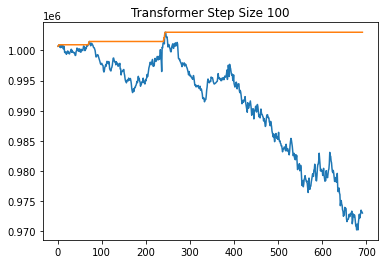

In [7]:
model = build_model(
    x_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]


try:
    with tf.device("/device:GPU:0"):
        model.fit(
            x_train,
            y_train,
            epochs=200,
            batch_size=64,
            callbacks=callbacks,
        )
except:
    model.fit(
        x_train,
        y_train,
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
    )

x, y = run_stepped_inc(
    model, x_test, y_test, step_size=100, epochs=5, batch_size=64, callbacks=callbacks
)
rets_agg["Transformer Step Size 100"], tf_rets100 = summ_and_plot(x, y, title="Transformer Step Size 100")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 26)]     0           []                               
                                                                                                  
 layer_normalization_24 (LayerN  (None, 50, 26)      52          ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_12 (Multi  (None, 50, 26)      109594      ['layer_normalization_24[0][0]', 
 HeadAttention)                                                   'layer_normalization_24[0][0]'] 
                                                                                            

15/15 [==============================] - 13s 32ms/step - loss: 3443.4871
Epoch 2/200
15/15 [==============================] - ETA: 0s - loss: 1908.6128

15/15 [==============================] - 0s 30ms/step - loss: 1908.6128
Epoch 3/200
15/15 [==============================] - ETA: 0s - loss: 1630.7736

15/15 [==============================] - 0s 31ms/step - loss: 1630.7736
Epoch 4/200
15/15 [==============================] - ETA: 0s - loss: 1540.7324

15/15 [==============================] - 0s 32ms/step - loss: 1540.7324
Epoch 5/200
15/15 [==============================] - ETA: 0s - loss: 1251.5974

15/15 [==============================] - 0s 30ms/step - loss: 1251.5974
Epoch 6/200
15/15 [==============================] - ETA: 0s - loss: 1265.3781

15/15 [==============================] - 0s 30ms/step - loss: 1265.3781
Epoch 7/200
15/15 [==============================] - ETA: 0s - loss: 1161.7316

15/15 [==============================] - 0s 31ms/step - loss: 1161.7316
Epoch 8/200
15/15 [==============================] - ETA: 0s - loss: 1012.4551

15/15 [==============================] - 0s 32ms/step - loss: 1012.4551
Epoch 9/200
15/15 [==============================] - ETA: 0s - loss: 930.0732

15/15 [==============================] - 0s 30ms/step - loss: 930.0732
Epoch 10/200
15/15 [==============================] - ETA: 0s - loss: 723.9828

15/15 [==============================] - 0s 31ms/step - loss: 723.9828
Epoch 11/200
15/15 [==============================] - ETA: 0s - loss: 663.7956

15/15 [==============================] - 0s 28ms/step - loss: 663.7956
Epoch 12/200
15/15 [==============================] - ETA: 0s - loss: 634.5637

15/15 [==============================] - 0s 27ms/step - loss: 634.5637
Epoch 13/200
15/15 [==============================] - ETA: 0s - loss: 548.7809

15/15 [==============================] - 0s 28ms/step - loss: 548.7809
Epoch 14/200
15/15 [==============================] - ETA: 0s - loss: 510.7980

15/15 [==============================] - 0s 29ms/step - loss: 510.7980
Epoch 15/200
15/15 [==============================] - ETA: 0s - loss: 388.4019

15/15 [==============================] - 0s 28ms/step - loss: 388.4019
Epoch 16/200
15/15 [==============================] - ETA: 0s - loss: 328.9643

15/15 [==============================] - 0s 28ms/step - loss: 328.9643
Epoch 17/200
15/15 [==============================] - ETA: 0s - loss: 282.9353

15/15 [==============================] - 0s 28ms/step - loss: 282.9353
Epoch 18/200
15/15 [==============================] - ETA: 0s - loss: 219.3210

15/15 [==============================] - 0s 28ms/step - loss: 219.3210
Epoch 19/200
15/15 [==============================] - ETA: 0s - loss: 192.9206

15/15 [==============================] - 0s 29ms/step - loss: 192.9206
Epoch 20/200
15/15 [==============================] - ETA: 0s - loss: 161.1385

15/15 [==============================] - 0s 28ms/step - loss: 161.1385
Epoch 21/200
15/15 [==============================] - ETA: 0s - loss: 128.1341

15/15 [==============================] - 0s 28ms/step - loss: 128.1341
Epoch 22/200
15/15 [==============================] - ETA: 0s - loss: 89.7503

15/15 [==============================] - 0s 29ms/step - loss: 89.7503
Epoch 23/200
15/15 [==============================] - ETA: 0s - loss: 73.8754

15/15 [==============================] - 0s 28ms/step - loss: 73.8754
Epoch 24/200
15/15 [==============================] - ETA: 0s - loss: 56.8221

15/15 [==============================] - 0s 28ms/step - loss: 56.8221
Epoch 25/200
15/15 [==============================] - ETA: 0s - loss: 51.4373

15/15 [==============================] - 0s 28ms/step - loss: 51.4373
Epoch 26/200
15/15 [==============================] - ETA: 0s - loss: 44.2310

15/15 [==============================] - 0s 27ms/step - loss: 44.2310
Epoch 27/200
15/15 [==============================] - ETA: 0s - loss: 31.8400

15/15 [==============================] - 0s 28ms/step - loss: 31.8400
Epoch 28/200
15/15 [==============================] - ETA: 0s - loss: 24.6519

15/15 [==============================] - 0s 28ms/step - loss: 24.6519
Epoch 29/200
15/15 [==============================] - ETA: 0s - loss: 22.5773

15/15 [==============================] - 0s 28ms/step - loss: 22.5773
Epoch 30/200
15/15 [==============================] - ETA: 0s - loss: 18.5810

15/15 [==============================] - 0s 28ms/step - loss: 18.5810
Epoch 31/200
15/15 [==============================] - ETA: 0s - loss: 16.5097

15/15 [==============================] - 0s 29ms/step - loss: 16.5097
Epoch 32/200
15/15 [==============================] - ETA: 0s - loss: 14.6075

15/15 [==============================] - 0s 28ms/step - loss: 14.6075
Epoch 33/200
15/15 [==============================] - ETA: 0s - loss: 13.4408

15/15 [==============================] - 0s 28ms/step - loss: 13.4408
Epoch 34/200
15/15 [==============================] - ETA: 0s - loss: 11.8509

15/15 [==============================] - 0s 30ms/step - loss: 11.8509
Epoch 35/200
15/15 [==============================] - ETA: 0s - loss: 11.7023

15/15 [==============================] - 0s 30ms/step - loss: 11.7023
Epoch 36/200
15/15 [==============================] - ETA: 0s - loss: 12.2827

15/15 [==============================] - 0s 29ms/step - loss: 12.2827
Epoch 37/200
15/15 [==============================] - ETA: 0s - loss: 12.0847

15/15 [==============================] - 0s 29ms/step - loss: 12.0847
Epoch 38/200
15/15 [==============================] - ETA: 0s - loss: 10.6308

15/15 [==============================] - 0s 31ms/step - loss: 10.6308
Epoch 39/200
15/15 [==============================] - ETA: 0s - loss: 10.5431

15/15 [==============================] - 0s 30ms/step - loss: 10.5431
Epoch 40/200
15/15 [==============================] - ETA: 0s - loss: 10.5065

15/15 [==============================] - 0s 30ms/step - loss: 10.5065
Epoch 41/200
15/15 [==============================] - ETA: 0s - loss: 11.2475

15/15 [==============================] - 0s 31ms/step - loss: 11.2475
Epoch 42/200
15/15 [==============================] - ETA: 0s - loss: 11.2822

15/15 [==============================] - 0s 31ms/step - loss: 11.2822
Epoch 43/200
15/15 [==============================] - ETA: 0s - loss: 9.1506

15/15 [==============================] - 0s 29ms/step - loss: 9.1506
Epoch 44/200
15/15 [==============================] - ETA: 0s - loss: 9.2145

15/15 [==============================] - 0s 28ms/step - loss: 9.2145
Epoch 45/200
15/15 [==============================] - ETA: 0s - loss: 10.6980

15/15 [==============================] - 0s 28ms/step - loss: 10.6980
Epoch 46/200
15/15 [==============================] - ETA: 0s - loss: 8.8911

15/15 [==============================] - 0s 28ms/step - loss: 8.8911
Epoch 47/200
15/15 [==============================] - ETA: 0s - loss: 9.6548

15/15 [==============================] - 0s 29ms/step - loss: 9.6548
Epoch 48/200
15/15 [==============================] - ETA: 0s - loss: 10.0842

15/15 [==============================] - 0s 28ms/step - loss: 10.0842
Epoch 49/200
15/15 [==============================] - ETA: 0s - loss: 9.4804

15/15 [==============================] - 0s 29ms/step - loss: 9.4804
Epoch 50/200
15/15 [==============================] - ETA: 0s - loss: 9.5904

15/15 [==============================] - 0s 28ms/step - loss: 9.5904
Epoch 51/200
15/15 [==============================] - ETA: 0s - loss: 9.5513

15/15 [==============================] - 0s 28ms/step - loss: 9.5513
Epoch 52/200
15/15 [==============================] - ETA: 0s - loss: 9.7845

15/15 [==============================] - 0s 29ms/step - loss: 9.7845
Epoch 53/200
15/15 [==============================] - ETA: 0s - loss: 9.1262

15/15 [==============================] - 0s 28ms/step - loss: 9.1262
Epoch 54/200
15/15 [==============================] - ETA: 0s - loss: 8.6331

15/15 [==============================] - 0s 29ms/step - loss: 8.6331
Epoch 55/200
15/15 [==============================] - ETA: 0s - loss: 9.1516

15/15 [==============================] - 0s 29ms/step - loss: 9.1516
Epoch 56/200
15/15 [==============================] - ETA: 0s - loss: 8.1921

15/15 [==============================] - 0s 28ms/step - loss: 8.1921
Epoch 57/200
15/15 [==============================] - ETA: 0s - loss: 8.4517

15/15 [==============================] - 0s 29ms/step - loss: 8.4517
Epoch 58/200
15/15 [==============================] - ETA: 0s - loss: 7.9974

15/15 [==============================] - 0s 28ms/step - loss: 7.9974
Epoch 59/200
15/15 [==============================] - ETA: 0s - loss: 9.3775

15/15 [==============================] - 0s 28ms/step - loss: 9.3775
Epoch 60/200
15/15 [==============================] - ETA: 0s - loss: 9.0061

15/15 [==============================] - 0s 29ms/step - loss: 9.0061
Epoch 61/200
15/15 [==============================] - ETA: 0s - loss: 9.1904

15/15 [==============================] - 0s 29ms/step - loss: 9.1904
Epoch 62/200
15/15 [==============================] - ETA: 0s - loss: 8.2864

15/15 [==============================] - 0s 28ms/step - loss: 8.2864
Epoch 63/200
15/15 [==============================] - ETA: 0s - loss: 9.1536

15/15 [==============================] - 0s 28ms/step - loss: 9.1536
Epoch 64/200
15/15 [==============================] - ETA: 0s - loss: 8.9427

15/15 [==============================] - 0s 29ms/step - loss: 8.9427
Epoch 65/200
15/15 [==============================] - ETA: 0s - loss: 7.6257

15/15 [==============================] - 0s 28ms/step - loss: 7.6257
Epoch 66/200
15/15 [==============================] - ETA: 0s - loss: 7.9476

15/15 [==============================] - 0s 30ms/step - loss: 7.9476
Epoch 67/200
15/15 [==============================] - ETA: 0s - loss: 7.3295

15/15 [==============================] - 0s 29ms/step - loss: 7.3295
Epoch 68/200
15/15 [==============================] - ETA: 0s - loss: 8.1982

15/15 [==============================] - 0s 30ms/step - loss: 8.1982
Epoch 69/200
15/15 [==============================] - ETA: 0s - loss: 7.5795

15/15 [==============================] - 0s 30ms/step - loss: 7.5795
Epoch 70/200
15/15 [==============================] - ETA: 0s - loss: 7.8635

15/15 [==============================] - 0s 30ms/step - loss: 7.8635
Epoch 71/200
15/15 [==============================] - ETA: 0s - loss: 8.1026

15/15 [==============================] - 0s 30ms/step - loss: 8.1026
Epoch 72/200
15/15 [==============================] - ETA: 0s - loss: 7.8635

15/15 [==============================] - 0s 30ms/step - loss: 7.8635
Epoch 73/200
15/15 [==============================] - ETA: 0s - loss: 7.6478

15/15 [==============================] - 0s 31ms/step - loss: 7.6478
Epoch 74/200
15/15 [==============================] - ETA: 0s - loss: 7.5836

15/15 [==============================] - 0s 31ms/step - loss: 7.5836
Epoch 75/200
15/15 [==============================] - ETA: 0s - loss: 8.2747

15/15 [==============================] - 0s 29ms/step - loss: 8.2747
Epoch 76/200
15/15 [==============================] - ETA: 0s - loss: 7.9119

15/15 [==============================] - 0s 28ms/step - loss: 7.9119
Epoch 77/200
15/15 [==============================] - ETA: 0s - loss: 8.1280

15/15 [==============================] - 0s 28ms/step - loss: 8.1280
Epoch 78/200
15/15 [==============================] - ETA: 0s - loss: 8.0177

15/15 [==============================] - 0s 29ms/step - loss: 8.0177
Epoch 79/200
15/15 [==============================] - ETA: 0s - loss: 7.5855

15/15 [==============================] - 0s 29ms/step - loss: 7.5855
Epoch 80/200
15/15 [==============================] - ETA: 0s - loss: 7.8155

15/15 [==============================] - 0s 29ms/step - loss: 7.8155
Epoch 81/200
15/15 [==============================] - ETA: 0s - loss: 7.5344

15/15 [==============================] - 0s 28ms/step - loss: 7.5344
Epoch 82/200
15/15 [==============================] - ETA: 0s - loss: 7.3478

15/15 [==============================] - 0s 28ms/step - loss: 7.3478
Epoch 83/200
15/15 [==============================] - ETA: 0s - loss: 7.7220

15/15 [==============================] - 0s 28ms/step - loss: 7.7220
Epoch 84/200
15/15 [==============================] - ETA: 0s - loss: 7.2816

15/15 [==============================] - 0s 28ms/step - loss: 7.2816
Epoch 85/200
15/15 [==============================] - ETA: 0s - loss: 7.5143

15/15 [==============================] - 0s 28ms/step - loss: 7.5143
Epoch 86/200
15/15 [==============================] - ETA: 0s - loss: 7.2072

15/15 [==============================] - 0s 28ms/step - loss: 7.2072
Epoch 87/200
15/15 [==============================] - ETA: 0s - loss: 8.0116

15/15 [==============================] - 0s 28ms/step - loss: 8.0116
Epoch 88/200
15/15 [==============================] - ETA: 0s - loss: 7.1276

15/15 [==============================] - 0s 29ms/step - loss: 7.1276
Epoch 89/200
15/15 [==============================] - ETA: 0s - loss: 7.8214

15/15 [==============================] - 0s 29ms/step - loss: 7.8214
Epoch 90/200
15/15 [==============================] - ETA: 0s - loss: 7.8189

15/15 [==============================] - 0s 28ms/step - loss: 7.8189
Epoch 91/200
15/15 [==============================] - ETA: 0s - loss: 7.1460

15/15 [==============================] - 0s 28ms/step - loss: 7.1460
Epoch 92/200
15/15 [==============================] - ETA: 0s - loss: 6.7595

15/15 [==============================] - 0s 28ms/step - loss: 6.7595
Epoch 93/200
15/15 [==============================] - ETA: 0s - loss: 7.3385

15/15 [==============================] - 0s 28ms/step - loss: 7.3385
Epoch 94/200
15/15 [==============================] - ETA: 0s - loss: 7.4866

15/15 [==============================] - 0s 29ms/step - loss: 7.4866
Epoch 95/200
15/15 [==============================] - ETA: 0s - loss: 6.7096

15/15 [==============================] - 0s 29ms/step - loss: 6.7096
Epoch 96/200
15/15 [==============================] - ETA: 0s - loss: 6.6197

15/15 [==============================] - 0s 28ms/step - loss: 6.6197
Epoch 97/200
15/15 [==============================] - ETA: 0s - loss: 6.7491

15/15 [==============================] - 0s 28ms/step - loss: 6.7491
Epoch 98/200
15/15 [==============================] - ETA: 0s - loss: 6.8810

15/15 [==============================] - 0s 32ms/step - loss: 6.8810
Epoch 99/200
15/15 [==============================] - ETA: 0s - loss: 6.6593

15/15 [==============================] - 0s 30ms/step - loss: 6.6593
Epoch 100/200
15/15 [==============================] - ETA: 0s - loss: 6.9191

15/15 [==============================] - 0s 29ms/step - loss: 6.9191
Epoch 101/200
15/15 [==============================] - ETA: 0s - loss: 7.7933

15/15 [==============================] - 0s 31ms/step - loss: 7.7933
Epoch 102/200
15/15 [==============================] - ETA: 0s - loss: 6.4664

15/15 [==============================] - 0s 29ms/step - loss: 6.4664
Epoch 103/200
15/15 [==============================] - ETA: 0s - loss: 6.9375

15/15 [==============================] - 0s 30ms/step - loss: 6.9375
Epoch 104/200
15/15 [==============================] - ETA: 0s - loss: 6.9358

15/15 [==============================] - 1s 33ms/step - loss: 6.9358
Epoch 105/200
15/15 [==============================] - ETA: 0s - loss: 7.4660

15/15 [==============================] - 0s 30ms/step - loss: 7.4660
Epoch 106/200
15/15 [==============================] - ETA: 0s - loss: 6.7001

15/15 [==============================] - 0s 31ms/step - loss: 6.7001
Epoch 107/200
15/15 [==============================] - ETA: 0s - loss: 7.0114

15/15 [==============================] - 0s 29ms/step - loss: 7.0114
Epoch 108/200
15/15 [==============================] - ETA: 0s - loss: 6.8198

15/15 [==============================] - 0s 28ms/step - loss: 6.8198
Epoch 109/200
15/15 [==============================] - ETA: 0s - loss: 6.3172

15/15 [==============================] - 0s 28ms/step - loss: 6.3172
Epoch 110/200
15/15 [==============================] - ETA: 0s - loss: 6.9831

15/15 [==============================] - 0s 28ms/step - loss: 6.9831
Epoch 111/200
15/15 [==============================] - ETA: 0s - loss: 6.4637

15/15 [==============================] - 0s 29ms/step - loss: 6.4637
Epoch 112/200
15/15 [==============================] - ETA: 0s - loss: 6.6942

15/15 [==============================] - 0s 28ms/step - loss: 6.6942
Epoch 113/200
15/15 [==============================] - ETA: 0s - loss: 6.7923

15/15 [==============================] - 0s 29ms/step - loss: 6.7923
Epoch 114/200
15/15 [==============================] - ETA: 0s - loss: 6.5552

15/15 [==============================] - 0s 29ms/step - loss: 6.5552
Epoch 115/200
15/15 [==============================] - ETA: 0s - loss: 7.0191

15/15 [==============================] - 0s 29ms/step - loss: 7.0191
Epoch 116/200
15/15 [==============================] - ETA: 0s - loss: 6.8494

15/15 [==============================] - 0s 29ms/step - loss: 6.8494
Epoch 117/200
15/15 [==============================] - ETA: 0s - loss: 6.3899

15/15 [==============================] - 0s 28ms/step - loss: 6.3899
Epoch 118/200
15/15 [==============================] - ETA: 0s - loss: 6.8812

15/15 [==============================] - 0s 28ms/step - loss: 6.8812
Epoch 119/200
15/15 [==============================] - ETA: 0s - loss: 6.3114

15/15 [==============================] - 0s 28ms/step - loss: 6.3114
Epoch 120/200
15/15 [==============================] - ETA: 0s - loss: 6.7489

15/15 [==============================] - 0s 29ms/step - loss: 6.7489
Epoch 121/200
15/15 [==============================] - ETA: 0s - loss: 6.6398

15/15 [==============================] - 0s 28ms/step - loss: 6.6398
Epoch 122/200
15/15 [==============================] - ETA: 0s - loss: 6.0584

15/15 [==============================] - 0s 28ms/step - loss: 6.0584
Epoch 123/200
15/15 [==============================] - ETA: 0s - loss: 6.8142

15/15 [==============================] - 0s 28ms/step - loss: 6.8142
Epoch 124/200
15/15 [==============================] - ETA: 0s - loss: 7.1722

15/15 [==============================] - 0s 30ms/step - loss: 7.1722
Epoch 125/200
15/15 [==============================] - ETA: 0s - loss: 7.0126

15/15 [==============================] - 0s 29ms/step - loss: 7.0126
Epoch 126/200
15/15 [==============================] - ETA: 0s - loss: 6.8150

15/15 [==============================] - 0s 28ms/step - loss: 6.8150
Epoch 127/200
15/15 [==============================] - ETA: 0s - loss: 6.7990

15/15 [==============================] - 0s 28ms/step - loss: 6.7990
Epoch 128/200
15/15 [==============================] - ETA: 0s - loss: 5.9480

15/15 [==============================] - 0s 28ms/step - loss: 5.9480
Epoch 129/200
15/15 [==============================] - ETA: 0s - loss: 5.7520

15/15 [==============================] - 0s 29ms/step - loss: 5.7520
Epoch 130/200
15/15 [==============================] - ETA: 0s - loss: 6.5582

15/15 [==============================] - 0s 29ms/step - loss: 6.5582
Epoch 131/200
15/15 [==============================] - ETA: 0s - loss: 6.4716

15/15 [==============================] - 0s 31ms/step - loss: 6.4716
Epoch 132/200
15/15 [==============================] - ETA: 0s - loss: 6.2792

15/15 [==============================] - 0s 29ms/step - loss: 6.2792
Epoch 133/200
15/15 [==============================] - ETA: 0s - loss: 6.3567

15/15 [==============================] - 0s 30ms/step - loss: 6.3567
Epoch 134/200
15/15 [==============================] - ETA: 0s - loss: 6.0401

15/15 [==============================] - 0s 30ms/step - loss: 6.0401
Epoch 135/200
15/15 [==============================] - ETA: 0s - loss: 6.6451

15/15 [==============================] - 0s 30ms/step - loss: 6.6451
Epoch 136/200
15/15 [==============================] - ETA: 0s - loss: 7.0535

15/15 [==============================] - 0s 31ms/step - loss: 7.0535
Epoch 137/200
15/15 [==============================] - ETA: 0s - loss: 6.2813

15/15 [==============================] - 0s 30ms/step - loss: 6.2813
Epoch 138/200
15/15 [==============================] - ETA: 0s - loss: 6.2234

15/15 [==============================] - 0s 32ms/step - loss: 6.2234
Epoch 139/200
15/15 [==============================] - ETA: 0s - loss: 6.5602

15/15 [==============================] - 0s 30ms/step - loss: 6.5602
Epoch 140/200
15/15 [==============================] - ETA: 0s - loss: 5.8657

15/15 [==============================] - 0s 29ms/step - loss: 5.8657
Epoch 141/200
15/15 [==============================] - ETA: 0s - loss: 6.3617

15/15 [==============================] - 0s 28ms/step - loss: 6.3617
Epoch 142/200
15/15 [==============================] - ETA: 0s - loss: 6.0467

15/15 [==============================] - 0s 28ms/step - loss: 6.0467
Epoch 143/200
15/15 [==============================] - ETA: 0s - loss: 5.8521

15/15 [==============================] - 0s 29ms/step - loss: 5.8521
Epoch 144/200
15/15 [==============================] - ETA: 0s - loss: 5.9291

15/15 [==============================] - 0s 28ms/step - loss: 5.9291
Epoch 145/200
15/15 [==============================] - ETA: 0s - loss: 6.1226

15/15 [==============================] - 0s 29ms/step - loss: 6.1226
Epoch 146/200
15/15 [==============================] - ETA: 0s - loss: 5.7907

15/15 [==============================] - 0s 28ms/step - loss: 5.7907
Epoch 147/200
15/15 [==============================] - ETA: 0s - loss: 6.1643

15/15 [==============================] - 0s 29ms/step - loss: 6.1643
Epoch 148/200
15/15 [==============================] - ETA: 0s - loss: 6.4632

15/15 [==============================] - 0s 28ms/step - loss: 6.4632
Epoch 149/200
15/15 [==============================] - ETA: 0s - loss: 5.6555

15/15 [==============================] - 0s 28ms/step - loss: 5.6555
Epoch 150/200
15/15 [==============================] - ETA: 0s - loss: 5.9949

15/15 [==============================] - 0s 29ms/step - loss: 5.9949
Epoch 151/200
15/15 [==============================] - ETA: 0s - loss: 5.7606

15/15 [==============================] - 0s 29ms/step - loss: 5.7606
Epoch 152/200
15/15 [==============================] - ETA: 0s - loss: 5.7932

15/15 [==============================] - 0s 28ms/step - loss: 5.7932
Epoch 153/200
15/15 [==============================] - ETA: 0s - loss: 5.9168

15/15 [==============================] - 0s 28ms/step - loss: 5.9168
Epoch 154/200
15/15 [==============================] - ETA: 0s - loss: 5.8008

15/15 [==============================] - 0s 28ms/step - loss: 5.8008
Epoch 155/200
15/15 [==============================] - ETA: 0s - loss: 5.9728

15/15 [==============================] - 0s 29ms/step - loss: 5.9728
Epoch 156/200
15/15 [==============================] - ETA: 0s - loss: 6.1112

15/15 [==============================] - 0s 29ms/step - loss: 6.1112
Epoch 157/200
15/15 [==============================] - ETA: 0s - loss: 5.1687

15/15 [==============================] - 0s 28ms/step - loss: 5.1687
Epoch 158/200
15/15 [==============================] - ETA: 0s - loss: 5.6578

15/15 [==============================] - 0s 29ms/step - loss: 5.6578
Epoch 159/200
15/15 [==============================] - ETA: 0s - loss: 6.5929

15/15 [==============================] - 0s 28ms/step - loss: 6.5929
Epoch 160/200
15/15 [==============================] - ETA: 0s - loss: 6.1821

15/15 [==============================] - 0s 29ms/step - loss: 6.1821
Epoch 161/200
15/15 [==============================] - ETA: 0s - loss: 5.3311

15/15 [==============================] - 0s 28ms/step - loss: 5.3311
Epoch 162/200
15/15 [==============================] - ETA: 0s - loss: 5.7320

15/15 [==============================] - 0s 31ms/step - loss: 5.7320
Epoch 163/200
15/15 [==============================] - ETA: 0s - loss: 5.6867

15/15 [==============================] - 0s 31ms/step - loss: 5.6867
Epoch 164/200
15/15 [==============================] - ETA: 0s - loss: 5.5196

15/15 [==============================] - 0s 30ms/step - loss: 5.5196
Epoch 165/200
15/15 [==============================] - ETA: 0s - loss: 5.9309

15/15 [==============================] - 0s 31ms/step - loss: 5.9309
Epoch 166/200
15/15 [==============================] - ETA: 0s - loss: 5.3091

15/15 [==============================] - 0s 31ms/step - loss: 5.3091
Epoch 167/200
15/15 [==============================] - ETA: 0s - loss: 5.3015

15/15 [==============================] - 0s 29ms/step - loss: 5.3015
Epoch 168/200
15/15 [==============================] - ETA: 0s - loss: 6.2495

15/15 [==============================] - 0s 30ms/step - loss: 6.2495
Epoch 169/200
15/15 [==============================] - ETA: 0s - loss: 6.1005

15/15 [==============================] - 0s 32ms/step - loss: 6.1005
Epoch 170/200
15/15 [==============================] - ETA: 0s - loss: 5.1892

15/15 [==============================] - 0s 30ms/step - loss: 5.1892
Epoch 171/200
15/15 [==============================] - ETA: 0s - loss: 5.9059

15/15 [==============================] - 0s 31ms/step - loss: 5.9059
Epoch 172/200
15/15 [==============================] - ETA: 0s - loss: 5.8881

15/15 [==============================] - 0s 29ms/step - loss: 5.8881
Epoch 173/200
15/15 [==============================] - ETA: 0s - loss: 5.5067

15/15 [==============================] - 0s 29ms/step - loss: 5.5067
Epoch 174/200
15/15 [==============================] - ETA: 0s - loss: 5.8778

15/15 [==============================] - 0s 28ms/step - loss: 5.8778
Epoch 175/200
15/15 [==============================] - ETA: 0s - loss: 5.4642

15/15 [==============================] - 0s 28ms/step - loss: 5.4642
Epoch 176/200
15/15 [==============================] - ETA: 0s - loss: 5.5337

15/15 [==============================] - 0s 28ms/step - loss: 5.5337
Epoch 177/200
15/15 [==============================] - ETA: 0s - loss: 5.6382

15/15 [==============================] - 0s 28ms/step - loss: 5.6382
Epoch 178/200
15/15 [==============================] - ETA: 0s - loss: 5.6443

15/15 [==============================] - 0s 29ms/step - loss: 5.6443
Epoch 179/200
15/15 [==============================] - ETA: 0s - loss: 5.4838

15/15 [==============================] - 0s 29ms/step - loss: 5.4838
Epoch 180/200
15/15 [==============================] - ETA: 0s - loss: 5.3285

15/15 [==============================] - 0s 29ms/step - loss: 5.3285
Epoch 181/200
15/15 [==============================] - ETA: 0s - loss: 5.4797

15/15 [==============================] - 0s 28ms/step - loss: 5.4797
Epoch 182/200
15/15 [==============================] - ETA: 0s - loss: 5.2333

15/15 [==============================] - 0s 28ms/step - loss: 5.2333
Epoch 183/200
15/15 [==============================] - ETA: 0s - loss: 5.4812

15/15 [==============================] - 0s 29ms/step - loss: 5.4812
Epoch 184/200
15/15 [==============================] - ETA: 0s - loss: 5.2292

15/15 [==============================] - 0s 29ms/step - loss: 5.2292
Epoch 185/200
15/15 [==============================] - ETA: 0s - loss: 5.2233

15/15 [==============================] - 0s 29ms/step - loss: 5.2233
Epoch 186/200
15/15 [==============================] - ETA: 0s - loss: 5.3176

15/15 [==============================] - 0s 29ms/step - loss: 5.3176
Epoch 187/200
15/15 [==============================] - ETA: 0s - loss: 5.1876

15/15 [==============================] - 0s 28ms/step - loss: 5.1876
Epoch 188/200
15/15 [==============================] - ETA: 0s - loss: 5.0417

15/15 [==============================] - 0s 28ms/step - loss: 5.0417
Epoch 189/200
15/15 [==============================] - ETA: 0s - loss: 5.2458

15/15 [==============================] - 0s 29ms/step - loss: 5.2458
Epoch 190/200
15/15 [==============================] - ETA: 0s - loss: 5.0656

15/15 [==============================] - 0s 30ms/step - loss: 5.0656
Epoch 191/200
15/15 [==============================] - ETA: 0s - loss: 5.6721

15/15 [==============================] - 0s 29ms/step - loss: 5.6721
Epoch 192/200
15/15 [==============================] - ETA: 0s - loss: 5.2370

15/15 [==============================] - 0s 28ms/step - loss: 5.2370
Epoch 193/200
15/15 [==============================] - ETA: 0s - loss: 5.7147

15/15 [==============================] - 0s 30ms/step - loss: 5.7147
Epoch 194/200
15/15 [==============================] - ETA: 0s - loss: 5.0853

15/15 [==============================] - 0s 28ms/step - loss: 5.0853
Epoch 195/200
15/15 [==============================] - ETA: 0s - loss: 5.0969

15/15 [==============================] - 0s 32ms/step - loss: 5.0969
Epoch 196/200
15/15 [==============================] - ETA: 0s - loss: 4.7895

15/15 [==============================] - 0s 30ms/step - loss: 4.7895
Epoch 197/200
15/15 [==============================] - ETA: 0s - loss: 4.8871

15/15 [==============================] - 0s 31ms/step - loss: 4.8871
Epoch 198/200
15/15 [==============================] - ETA: 0s - loss: 4.7501

15/15 [==============================] - 0s 29ms/step - loss: 4.7501
Epoch 199/200
15/15 [==============================] - ETA: 0s - loss: 5.2114

15/15 [==============================] - 0s 30ms/step - loss: 5.2114
Epoch 200/200
15/15 [==============================] - ETA: 0s - loss: 4.9218

15/15 [==============================] - 0s 29ms/step - loss: 4.9218


  0%|          | 0/14 [00:00<?, ?it/s]

16/16 [==============================] - 1s 11ms/step
Epoch 1/10
8/8 [==============================] - ETA: 0s - loss: 4.5036

8/8 [==============================] - 0s 43ms/step - loss: 4.5036
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 5.7667

8/8 [==============================] - 0s 31ms/step - loss: 5.8168
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 5.0364

8/8 [==============================] - 0s 32ms/step - loss: 5.0410
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 4.8668

8/8 [==============================] - 0s 30ms/step - loss: 4.7394
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 4.7401

8/8 [==============================] - 0s 27ms/step - loss: 4.6943
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 4.7716

8/8 [==============================] - 0s 28ms/step - loss: 4.7450
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 4.9562

8/8 [==============================] - 0s 27ms/step - loss: 4.8474
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 5.0142

8/8 [==============================] - 0s 28ms/step - loss: 4.9997
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5903

8/8 [==============================] - 0s 28ms/step - loss: 4.5247
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1190

8/8 [==============================] - 0s 28ms/step - loss: 4.2590


  7%|▋         | 1/14 [00:03<00:45,  3.53s/it]

16/16 [==============================] - 0s 6ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 5.1684

8/8 [==============================] - 0s 29ms/step - loss: 5.1392
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 4.4956

8/8 [==============================] - 0s 29ms/step - loss: 4.4400
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0428

8/8 [==============================] - 0s 29ms/step - loss: 4.1395
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1218

8/8 [==============================] - 0s 29ms/step - loss: 4.1257
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 4.8492

8/8 [==============================] - 0s 28ms/step - loss: 4.8498
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 4.6772

8/8 [==============================] - 0s 29ms/step - loss: 4.5645
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5693

8/8 [==============================] - 0s 28ms/step - loss: 4.4588
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 4.8347

8/8 [==============================] - 0s 28ms/step - loss: 4.7028
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 4.8775

8/8 [==============================] - 0s 28ms/step - loss: 4.8993
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5885

8/8 [==============================] - 0s 28ms/step - loss: 4.5606


 14%|█▍        | 2/14 [00:06<00:35,  3.00s/it]

16/16 [==============================] - 0s 6ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5760

8/8 [==============================] - 0s 29ms/step - loss: 4.6198
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 5.1381

8/8 [==============================] - 0s 28ms/step - loss: 5.1684
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 4.7689

8/8 [==============================] - 0s 29ms/step - loss: 4.5806
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 5.1159

8/8 [==============================] - 0s 29ms/step - loss: 5.2392
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 4.6533

8/8 [==============================] - 0s 29ms/step - loss: 4.6164
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2758

8/8 [==============================] - 0s 28ms/step - loss: 4.4057
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 4.9820

8/8 [==============================] - 0s 28ms/step - loss: 4.9517
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 4.7015

8/8 [==============================] - 0s 28ms/step - loss: 4.5901
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 4.6546

8/8 [==============================] - 0s 28ms/step - loss: 4.4145
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 4.8378

8/8 [==============================] - 0s 28ms/step - loss: 4.6608


 21%|██▏       | 3/14 [00:08<00:32,  2.91s/it]

16/16 [==============================] - 0s 6ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 4.7236

8/8 [==============================] - 0s 29ms/step - loss: 4.6203
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2122

8/8 [==============================] - 0s 29ms/step - loss: 4.2767
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 5.0841

8/8 [==============================] - 0s 28ms/step - loss: 4.9734
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 4.9202

8/8 [==============================] - 0s 29ms/step - loss: 4.7774
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 4.8165

8/8 [==============================] - 0s 29ms/step - loss: 4.6622
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2745

8/8 [==============================] - 0s 28ms/step - loss: 4.4473
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 4.6537

8/8 [==============================] - 0s 29ms/step - loss: 4.8169
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5122

8/8 [==============================] - 0s 29ms/step - loss: 4.4401
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 3.9256

8/8 [==============================] - 0s 30ms/step - loss: 3.9037
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2712

8/8 [==============================] - 0s 29ms/step - loss: 4.2114


 29%|██▊       | 4/14 [00:11<00:28,  2.80s/it]

16/16 [==============================] - 0s 6ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6850

8/8 [==============================] - 0s 32ms/step - loss: 3.6703
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 4.7917

8/8 [==============================] - 0s 31ms/step - loss: 4.7138
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1417

8/8 [==============================] - 0s 30ms/step - loss: 4.2119
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7827

8/8 [==============================] - 0s 29ms/step - loss: 3.6966
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1451

8/8 [==============================] - 0s 30ms/step - loss: 4.1032
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0163

8/8 [==============================] - 0s 30ms/step - loss: 4.0536
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.8637

8/8 [==============================] - 0s 29ms/step - loss: 4.0048
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 4.3099

8/8 [==============================] - 0s 32ms/step - loss: 4.3302
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 5.3041

8/8 [==============================] - 0s 31ms/step - loss: 5.1374
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 4.6292

8/8 [==============================] - 0s 30ms/step - loss: 4.6383


 36%|███▌      | 5/14 [00:14<00:25,  2.79s/it]

16/16 [==============================] - 0s 7ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2533

8/8 [==============================] - 0s 30ms/step - loss: 4.2047
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 4.3543

8/8 [==============================] - 0s 31ms/step - loss: 4.3071
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 4.3466

8/8 [==============================] - 0s 30ms/step - loss: 4.3763
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.9495

8/8 [==============================] - 0s 30ms/step - loss: 3.8867
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1678

8/8 [==============================] - 0s 30ms/step - loss: 4.1645
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2445

8/8 [==============================] - 0s 32ms/step - loss: 4.0818
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 4.5677

8/8 [==============================] - 0s 33ms/step - loss: 4.5082
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6663

8/8 [==============================] - 0s 31ms/step - loss: 3.7595
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2720

8/8 [==============================] - 0s 29ms/step - loss: 4.3014
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7360

8/8 [==============================] - 0s 28ms/step - loss: 3.7372


 43%|████▎     | 6/14 [00:17<00:22,  2.81s/it]

16/16 [==============================] - 0s 6ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7095

8/8 [==============================] - 0s 29ms/step - loss: 3.5573
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0915

8/8 [==============================] - 0s 29ms/step - loss: 4.1457
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 3.9495

8/8 [==============================] - 0s 29ms/step - loss: 4.0376
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 4.2216

8/8 [==============================] - 0s 30ms/step - loss: 4.1357
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1934

8/8 [==============================] - 0s 30ms/step - loss: 4.1505
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 3.8802

8/8 [==============================] - 0s 28ms/step - loss: 3.9780
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6632

8/8 [==============================] - 0s 28ms/step - loss: 3.7051
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4506

8/8 [==============================] - 0s 29ms/step - loss: 3.4164
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7881

8/8 [==============================] - 0s 30ms/step - loss: 3.7606
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0005

8/8 [==============================] - 0s 29ms/step - loss: 4.1493


 50%|█████     | 7/14 [00:20<00:19,  2.81s/it]

16/16 [==============================] - 0s 7ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.8172

8/8 [==============================] - 0s 30ms/step - loss: 3.7297
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6825

8/8 [==============================] - 0s 30ms/step - loss: 3.6166
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 3.6924

8/8 [==============================] - 0s 30ms/step - loss: 3.7604
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0471

8/8 [==============================] - 0s 30ms/step - loss: 4.0092
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 3.7976

8/8 [==============================] - 0s 29ms/step - loss: 3.6446
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 3.3755

8/8 [==============================] - 0s 28ms/step - loss: 3.4757
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.3955

8/8 [==============================] - 0s 29ms/step - loss: 3.3979
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5226

8/8 [==============================] - 0s 29ms/step - loss: 3.4883
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0085

8/8 [==============================] - 0s 30ms/step - loss: 3.8470
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 4.0730

8/8 [==============================] - 0s 28ms/step - loss: 4.0389


 57%|█████▋    | 8/14 [00:22<00:16,  2.80s/it]

16/16 [==============================] - 0s 6ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5015

8/8 [==============================] - 0s 30ms/step - loss: 3.5379
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 3.9183

8/8 [==============================] - 0s 29ms/step - loss: 3.9344
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 4.1175

8/8 [==============================] - 0s 29ms/step - loss: 4.0535
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4977

8/8 [==============================] - 0s 29ms/step - loss: 3.4942
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5470

8/8 [==============================] - 0s 30ms/step - loss: 3.4632
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 3.3230

8/8 [==============================] - 0s 31ms/step - loss: 3.1887
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 3.4869

8/8 [==============================] - 0s 30ms/step - loss: 3.4136
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 3.5719

8/8 [==============================] - 0s 30ms/step - loss: 3.5480
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 2.9146

8/8 [==============================] - 0s 30ms/step - loss: 2.9788
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2723

8/8 [==============================] - 0s 29ms/step - loss: 3.2673


 64%|██████▍   | 9/14 [00:25<00:13,  2.79s/it]

16/16 [==============================] - 0s 6ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.3272

8/8 [==============================] - 0s 30ms/step - loss: 3.2579
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 3.0092

8/8 [==============================] - 0s 30ms/step - loss: 2.9230
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 3.3875

8/8 [==============================] - 0s 30ms/step - loss: 3.3165
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2971

8/8 [==============================] - 0s 33ms/step - loss: 3.2242
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 3.3113

8/8 [==============================] - 0s 32ms/step - loss: 3.3286
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 3.0877

8/8 [==============================] - 0s 31ms/step - loss: 3.1035
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 2.8476

8/8 [==============================] - 0s 30ms/step - loss: 2.8569
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 2.4515

8/8 [==============================] - 0s 29ms/step - loss: 2.3796
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 3.3135

8/8 [==============================] - 0s 29ms/step - loss: 3.3493
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 3.2448

8/8 [==============================] - 0s 30ms/step - loss: 3.2441


 71%|███████▏  | 10/14 [00:28<00:11,  2.77s/it]

16/16 [==============================] - 0s 6ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 3.1469

8/8 [==============================] - 0s 31ms/step - loss: 3.0312
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 2.4983

8/8 [==============================] - 0s 29ms/step - loss: 2.6004
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 2.7456

8/8 [==============================] - 0s 32ms/step - loss: 2.7993
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 2.6812

8/8 [==============================] - 0s 34ms/step - loss: 2.6038
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 2.6717

8/8 [==============================] - 0s 30ms/step - loss: 2.7834
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 2.5937

8/8 [==============================] - 0s 29ms/step - loss: 2.7271
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 2.5348

8/8 [==============================] - 0s 30ms/step - loss: 2.5597
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 2.6283

8/8 [==============================] - 0s 34ms/step - loss: 2.6651
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 2.3919

8/8 [==============================] - 0s 31ms/step - loss: 2.4747
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 2.4032

8/8 [==============================] - 0s 30ms/step - loss: 2.4560


 79%|███████▊  | 11/14 [00:33<00:10,  3.58s/it]

16/16 [==============================] - 0s 8ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 2.5447

8/8 [==============================] - 0s 31ms/step - loss: 2.4714
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 2.4093

8/8 [==============================] - 0s 28ms/step - loss: 2.3975
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 2.4153

8/8 [==============================] - 0s 28ms/step - loss: 2.3702
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 2.3444

8/8 [==============================] - 0s 29ms/step - loss: 2.2716
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 2.6234

8/8 [==============================] - 0s 29ms/step - loss: 2.5359
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 2.5135

8/8 [==============================] - 0s 28ms/step - loss: 2.5231
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 2.3593

8/8 [==============================] - 0s 28ms/step - loss: 2.5099
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 2.5209

8/8 [==============================] - 0s 28ms/step - loss: 2.5118
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 2.1358

8/8 [==============================] - 0s 29ms/step - loss: 2.3390
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 2.3716

8/8 [==============================] - 0s 28ms/step - loss: 2.2947


 86%|████████▌ | 12/14 [00:36<00:06,  3.35s/it]

16/16 [==============================] - 0s 6ms/step
Epoch 1/10
7/8 [=========================>....] - ETA: 0s - loss: 2.4048

8/8 [==============================] - 0s 29ms/step - loss: 2.3749
Epoch 2/10
7/8 [=========================>....] - ETA: 0s - loss: 2.0491

8/8 [==============================] - 0s 30ms/step - loss: 2.0987
Epoch 3/10
7/8 [=========================>....] - ETA: 0s - loss: 1.9630

8/8 [==============================] - 0s 30ms/step - loss: 2.0235
Epoch 4/10
7/8 [=========================>....] - ETA: 0s - loss: 2.4234

8/8 [==============================] - 0s 28ms/step - loss: 2.4485
Epoch 5/10
7/8 [=========================>....] - ETA: 0s - loss: 2.0685

8/8 [==============================] - 0s 28ms/step - loss: 2.1329
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 2.1004

8/8 [==============================] - 0s 29ms/step - loss: 2.1594
Epoch 7/10
7/8 [=========================>....] - ETA: 0s - loss: 2.1965

8/8 [==============================] - 0s 29ms/step - loss: 2.2093
Epoch 8/10
7/8 [=========================>....] - ETA: 0s - loss: 1.8578

8/8 [==============================] - 0s 28ms/step - loss: 1.9374
Epoch 9/10
7/8 [=========================>....] - ETA: 0s - loss: 1.8832

8/8 [==============================] - 0s 29ms/step - loss: 1.8373
Epoch 10/10
7/8 [=========================>....] - ETA: 0s - loss: 2.0734

8/8 [==============================] - 0s 28ms/step - loss: 2.0671


 93%|█████████▎| 13/14 [00:39<00:03,  3.14s/it]

13/13 [==============================] - 0s 8ms/step
Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 2.0152

7/7 [==============================] - 0s 34ms/step - loss: 2.0152
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 1.7895

7/7 [==============================] - 0s 33ms/step - loss: 1.7895
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 1.8578

7/7 [==============================] - 0s 29ms/step - loss: 1.8578
Epoch 4/10
5/7 [====================>.........] - ETA: 0s - loss: 1.7951

7/7 [==============================] - 0s 30ms/step - loss: 1.7033
Epoch 5/10
5/7 [====================>.........] - ETA: 0s - loss: 1.7324

7/7 [==============================] - 0s 28ms/step - loss: 1.9094
Epoch 6/10
7/7 [==============================] - ETA: 0s - loss: 1.7192

7/7 [==============================] - 0s 29ms/step - loss: 1.7192
Epoch 7/10
7/7 [==============================] - ETA: 0s - loss: 1.8424

7/7 [==============================] - 0s 30ms/step - loss: 1.8424
Epoch 8/10
5/7 [====================>.........] - ETA: 0s - loss: 1.7355

7/7 [==============================] - 0s 28ms/step - loss: 1.7589
Epoch 9/10
7/7 [==============================] - ETA: 0s - loss: 1.7663

7/7 [==============================] - 0s 34ms/step - loss: 1.7663
Epoch 10/10
7/7 [==============================] - ETA: 0s - loss: 1.7730

7/7 [==============================] - 0s 37ms/step - loss: 1.7730


100%|██████████| 14/14 [00:42<00:00,  3.00s/it]


,Transformer Step Size 500
Annualized Return,0.005676
Annualized Volatility,0.008600
Annualized Sharpe Ratio,0.660052
Annualized Sortino Ratio,0.962277
Skewness,-0.115555
Kurtosis,2.453995
VaR (0.05),-0.000781
CVaR (0.05),-0.001213
Min,-0.002708
Max,0.002138


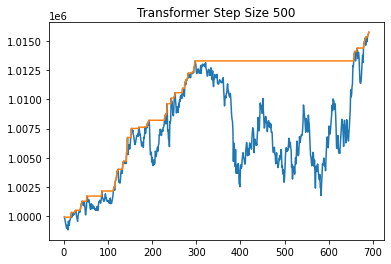

In [8]:
model = build_model(
    x_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]


try:
    with tf.device("/device:GPU:0"):
        model.fit(
            x_train,
            y_train,
            epochs=200,
            batch_size=64,
            callbacks=callbacks,
        )
except:
    model.fit(
        x_train,
        y_train,
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
    )

x, y = run_stepped_inc(
    model, x_test, y_test, step_size=500, epochs=10, batch_size=64, callbacks=callbacks
)
rets_agg["Transformer Step Size 500"], tf_rets500 = summ_and_plot(x, y, title="Transformer Step Size 500")

,Transformer Step Size 25,Transformer Step Size 50,Transformer Step Size 100,Transformer Step Size 500
Annualized Return,0.006417,0.005690,-0.009988,0.005676
Annualized Volatility,0.008719,0.008572,0.008885,0.008600
Annualized Sharpe Ratio,0.735893,0.663787,-1.124118,0.660052
Annualized Sortino Ratio,1.081631,0.972158,-1.735421,0.962277
Skewness,-0.079459,-0.099389,0.446790,-0.115555
Kurtosis,2.402640,2.471360,5.004730,2.453995
VaR (0.05),-0.000772,-0.000769,-0.000884,-0.000781
CVaR (0.05),-0.001209,-0.001191,-0.001270,-0.001213
Min,-0.002707,-0.002709,-0.002342,-0.002708
Max,0.002136,0.002136,0.004026,0.002138


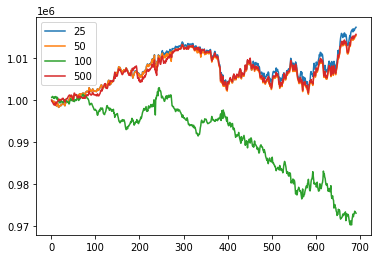

In [9]:
display(rets_agg)
plt.plot(tf_rets25["portfolio"], label="25")
plt.plot(tf_rets50["portfolio"], label="50")
plt.plot(tf_rets100["portfolio"], label="100")
plt.plot(tf_rets500["portfolio"], label="500")
plt.legend()
plt.show()

100%|██████████| 64/64 [00:07<00:00,  8.86it/s]


,XGBoost
Annualized Return,0.015313
Annualized Volatility,0.013224
Annualized Sharpe Ratio,1.158008
Annualized Sortino Ratio,1.851137
Skewness,0.124746
Kurtosis,0.789027
VaR (0.05),-0.001313
CVaR (0.05),-0.001762
Min,-0.002363
Max,0.002483


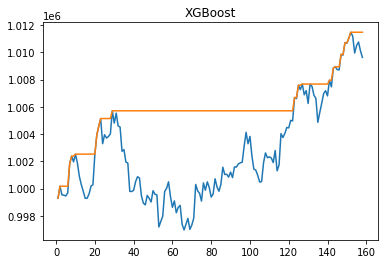

In [10]:
from xgboost import XGBRegressor

# XGBoost and Regression Models.
df_train_mod = df_train.copy()
df_test_mod = df_test.copy()

df_all = pd.concat([df_train, df_test], axis=0).drop_duplicates().reset_index(drop=True).copy()

x_all_mod = df_all.drop(target_col, axis=1)
y_all_mod = df_all[target_col].values

x_train_mod = df_train_mod.drop(target_col, axis=1)
y_train_mod = df_train_mod[target_col].values

x_test_mod = df_test_mod.drop(target_col, axis=1)
y_test_mod = df_test_mod[target_col].values

xgb_model = XGBRegressor(effect_learner_objective="reg:squarederror", verbosity=0)

x, y = run_stepped_retrain(xgb_model, x_all_mod, y_all_mod, step_size=25)
rets_agg["XGBoost Step Size 25"], xgb_rets = summ_and_plot(x, y, title="XGBoost")

100%|██████████| 317/317 [00:38<00:00,  8.19it/s]


,XGBoost
Annualized Return,0.012934
Annualized Volatility,0.012765
Annualized Sharpe Ratio,1.013260
Annualized Sortino Ratio,1.832434
Skewness,0.382646
Kurtosis,0.376093
VaR (0.05),-0.001256
CVaR (0.05),-0.001529
Min,-0.001837
Max,0.002390


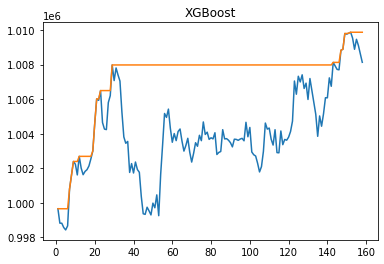

In [17]:
xgb_model = XGBRegressor(effect_learner_objective="reg:squarederror", verbosity=0)
x, y = run_stepped_retrain(xgb_model, x_all_mod, y_all_mod, step_size=5)
rets_agg["XGBoost Step Size 5"], xgb_rets = summ_and_plot(x, y, title="XGBoost")

100%|██████████| 16/16 [00:01<00:00,  8.73it/s]


,XGBoost
Annualized Return,0.006690
Annualized Volatility,0.011984
Annualized Sharpe Ratio,0.558294
Annualized Sortino Ratio,0.889155
Skewness,-0.007195
Kurtosis,0.427655
VaR (0.05),-0.001242
CVaR (0.05),-0.001669
Min,-0.001845
Max,0.002481


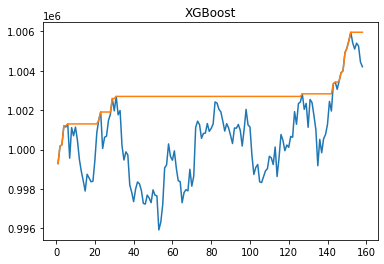

In [18]:
xgb_model = XGBRegressor(effect_learner_objective="reg:squarederror", verbosity=0)
x, y = run_stepped_retrain(xgb_model, x_all_mod, y_all_mod, step_size=100)
rets_agg["XGBoost Step Size 100"], xgb_rets = summ_and_plot(x, y, title="XGBoost")

100%|██████████| 64/64 [00:11<00:00,  5.79it/s]


,Random Forest
Annualized Return,-0.019788
Annualized Volatility,0.012130
Annualized Sharpe Ratio,-1.631347
Annualized Sortino Ratio,-2.249293
Skewness,-0.517732
Kurtosis,1.471151
VaR (0.05),-0.001267
CVaR (0.05),-0.001855
Min,-0.003146
Max,0.002086


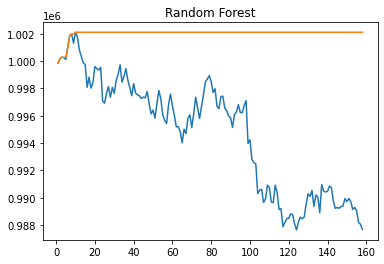

In [19]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=10, random_state=1)
x, y = run_stepped_retrain(forest, x_all_mod.values, y_all_mod, step_size=25)
# Note that this is highly overfit.
rets_agg["Random Forest Step Size 25"], rf_rets = summ_and_plot(x, y, title="Random Forest")

100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


,Random Forest
Annualized Return,0.034583
Annualized Volatility,0.011868
Annualized Sharpe Ratio,2.913952
Annualized Sortino Ratio,5.711286
Skewness,0.090598
Kurtosis,-0.322452
VaR (0.05),-0.001068
CVaR (0.05),-0.001314
Min,-0.001680
Max,0.002252


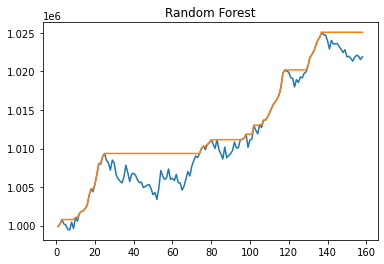

In [20]:
forest = RandomForestRegressor(n_estimators=10, random_state=1)
x, y = run_stepped_retrain(forest, x_all_mod.values, y_all_mod, step_size=1600)
# Increasing step size improves performance.
rets_agg["Random Forest Step Size 1600"], rf_rets = summ_and_plot(x, y, title="Random Forest")

100%|██████████| 317/317 [00:44<00:00,  7.07it/s]


,Random Forest
Annualized Return,-0.011229
Annualized Volatility,0.012063
Annualized Sharpe Ratio,-0.930867
Annualized Sortino Ratio,-1.415409
Skewness,0.016196
Kurtosis,0.814123
VaR (0.05),-0.001218
CVaR (0.05),-0.001677
Min,-0.002414
Max,0.002381


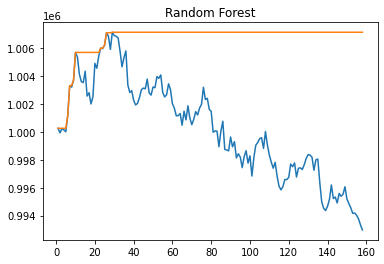

In [21]:
forest = RandomForestRegressor(n_estimators=10, random_state=1)
x, y = run_stepped_retrain(forest, x_all_mod.values, y_all_mod, step_size=5)
# Increasing step size improves performance.
rets_agg["Random Forest Step Size 5"], rf_rets = summ_and_plot(x, y, title="Random Forest")

100%|██████████| 64/64 [00:00<00:00, 443.11it/s]


,Linear Regression
Annualized Return,0.014187
Annualized Volatility,0.012343
Annualized Sharpe Ratio,1.149434
Annualized Sortino Ratio,1.846169
Skewness,0.489356
Kurtosis,3.857847
VaR (0.05),-0.001016
CVaR (0.05),-0.001634
Min,-0.002591
Max,0.003894


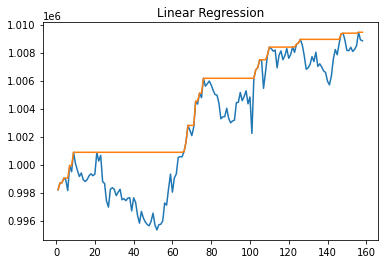

In [22]:
# Try normal regression.
from sklearn.linear_model import LinearRegression

mod = LinearRegression()
x, y = run_stepped_retrain(mod, x_all_mod.values, y_all_mod, step_size=25)
rets_agg["Linear Regression Step Size 25"], rf_rets = summ_and_plot(x, y, title="Linear Regression")

In [24]:
rets_agg.reindex(sorted(rets_agg.columns), axis=1)

,Linear Regression Step Size 25,Random Forest Step Size 100,Random Forest Step Size 1600,Random Forest Step Size 25,Random Forest Step Size 5,Transformer Step Size 100,Transformer Step Size 25,Transformer Step Size 50,Transformer Step Size 500,XGBoost Step Size 100,XGBoost Step Size 25,XGBoost Step Size 5
Annualized Return,0.014187,0.034583,0.034583,-0.019788,-0.011229,-0.009988,0.006417,0.005690,0.005676,0.006690,0.015313,0.012934
Annualized Volatility,0.012343,0.011868,0.011868,0.012130,0.012063,0.008885,0.008719,0.008572,0.008600,0.011984,0.013224,0.012765
Annualized Sharpe Ratio,1.149434,2.913952,2.913952,-1.631347,-0.930867,-1.124118,0.735893,0.663787,0.660052,0.558294,1.158008,1.013260
Annualized Sortino Ratio,1.846169,5.711286,5.711286,-2.249293,-1.415409,-1.735421,1.081631,0.972158,0.962277,0.889155,1.851137,1.832434
Skewness,0.489356,0.090598,0.090598,-0.517732,0.016196,0.446790,-0.079459,-0.099389,-0.115555,-0.007195,0.124746,0.382646
Kurtosis,3.857847,-0.322452,-0.322452,1.471151,0.814123,5.004730,2.402640,2.471360,2.453995,0.427655,0.789027,0.376093
VaR (0.05),-0.001016,-0.001068,-0.001068,-0.001267,-0.001218,-0.000884,-0.000772,-0.000769,-0.000781,-0.001242,-0.001313,-0.001256
CVaR (0.05),-0.001634,-0.001314,-0.001314,-0.001855,-0.001677,-0.001270,-0.001209,-0.001191,-0.001213,-0.001669,-0.001762,-0.001529
Min,-0.002591,-0.001680,-0.001680,-0.003146,-0.002414,-0.002342,-0.002707,-0.002709,-0.002708,-0.001845,-0.002363,-0.001837
Max,0.003894,0.002252,0.002252,0.002086,0.002381,0.004026,0.002136,0.002136,0.002138,0.002481,0.002483,0.002390
